# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [128]:
# <Student to fill this section>

# src/data/download_open_meteo_daily.py
from __future__ import annotations

# Standard library 
from datetime import date, timedelta
from pathlib import Path
from typing import Any, Dict, List, Optional
import json
import os
import time
import joblib
import numpy as np
import pandas as pd

# Third-party: API / HTTP
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
# --- Estimators
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge
from xgboost import XGBClassifier, XGBRegressor

# --- Preprocessing / Feature Engineering
from sklearn.feature_selection import f_classif, mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# --- Metrics / Diagnostics
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    average_precision_score,
    precision_recall_fscore_support,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_score,
    recall_score,
    r2_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.metrics import ConfusionMatrixDisplay  # keeps the display separate for clarity

# Hyperparameters Tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

---
## A. Project Description


In [4]:
# <Student to fill this section>
student_name = "Manh Tuan Nguyen"
student_id = "25739083"

In [5]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [6]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [7]:
# <Student to fill this section>
business_use_case_description = """
The primary goal of this project is to build predictive models that can **forecast the likelihood and intensity of rainfall** using historical weather and atmospheric data. This has practical applications in sectors such as **agriculture, water resource management, and urban planning**, where timely and accurate forecasts can reduce risks and support better decision-making. By providing insights into both **whether it will rain** and **how much precipitation to expect**, the models aim to improve planning efficiency and mitigate losses caused by unexpected weather events.
"""

**Business Use Case Description**

The primary goal of this project is to build predictive models that can **forecast the likelihood and intensity of rainfall** using historical weather and atmospheric data. This has practical applications in sectors such as **agriculture, water resource management, and urban planning**, where timely and accurate forecasts can reduce risks and support better decision-making. By providing insights into both **whether it will rain** and **how much precipitation to expect**, the models aim to improve planning efficiency and mitigate losses caused by unexpected weather events.


In [8]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

**Business Objectives**

Accurate results will:
- Enable **farmers and agricultural businesses** to plan irrigation schedules more effectively, optimizing crop yields and reducing water waste.
- Help **local authorities** prepare for potential flooding or drought conditions.
- Provide **energy providers** (e.g., solar or hydropower operators) with reliable inputs for demand and supply forecasting.

Incorrect results may:
- Lead to **poor planning decisions** (e.g., under-preparing for storms or overusing water in dry conditions).
- Cause **economic losses** due to crop damage, disrupted supply chains, or energy mismanagement.
- Reduce **stakeholder trust** in data-driven decision systems.


In [9]:
# <Student to fill this section>
business_objectives = """
Accurate results will:
- Enable **farmers and agricultural businesses** to plan irrigation schedules more effectively, optimizing crop yields and reducing water waste.
- Help **local authorities** prepare for potential flooding or drought conditions.
- Provide **energy providers** (e.g., solar or hydropower operators) with reliable inputs for demand and supply forecasting.

Incorrect results may:
- Lead to **poor planning decisions** (e.g., under-preparing for storms or overusing water in dry conditions).
- Cause **economic losses** due to crop damage, disrupted supply chains, or energy mismanagement.
- Reduce **stakeholder trust** in data-driven decision systems.
"""

In [10]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [11]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
**Users of predictions:**
- Agricultural planners and farmers (irrigation, crop protection).
- Water resource managers (reservoir levels, conservation strategies).
- Energy sector forecasters (solar/hydro capacity planning).
- Local governments and urban planners (infrastructure preparedness).

**How results will be used:**
- Daily or weekly **decision-making dashboards**.
- Automated **alerts and notifications** for extreme rainfall forecasts.
- Strategic **planning documents** for seasonal climate outlooks.

**Who will be impacted:**
- Businesses dependent on weather-sensitive operations.
- Communities affected by rainfall-related disruptions (flood, drought).
 Policymakers and regulators responsible for climate resilience.
"""

**Stakeholders’ Expectations Explanations**

**Users of predictions:**
- Agricultural planners and farmers (irrigation, crop protection).
- Water resource managers (reservoir levels, conservation strategies).
- Energy sector forecasters (solar/hydro capacity planning).
- Local governments and urban planners (infrastructure preparedness).

**How results will be used:**
- Daily or weekly **decision-making dashboards**.
- Automated **alerts and notifications** for extreme rainfall forecasts.
- Strategic **planning documents** for seasonal climate outlooks.

**Who will be impacted:**
- Businesses dependent on weather-sensitive operations.
- Communities affected by rainfall-related disruptions (flood, drought).
 Policymakers and regulators responsible for climate resilience.


In [12]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [13]:
# <Student to fill this section>

# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
# Project paths (Cookiecutter)

DATA = Path("../data")
RAW = DATA / "raw" / "open_meteo"
PROCESSED = DATA / "processed"
RAW.mkdir(parents=True, exist_ok=True)
PROCESSED.mkdir(parents=True, exist_ok=True)

print(f"Raw data path: {RAW}")
print(f"Processed data path: {PROCESSED}")

Raw data path: ..\data\raw\open_meteo
Processed data path: ..\data\processed


In [15]:
# Open Meteo datasets

#  --- Configuration
LAT = -33.8678
LON = 151.2073
TIMEZONE = "Australia/Sydney"

START_YEAR = 2000
END_YEAR = 2024  # inclusive

#  --- Daily variables (align with Open-Meteo "Daily Weather Variables")
DAILY_VARS: List[str] = [
    # Targets (used later to create labels, but these pulls are historical up to D only)
    "precipitation_sum",
    "rain_sum",
    "precipitation_hours",

    # Temperature / thermo
    "temperature_2m_mean",
    "temperature_2m_max",
    "temperature_2m_min",
    "wet_bulb_temperature_2m_mean",
    "vapour_pressure_deficit_max",

    # Cloud & radiation
    "cloudcover_mean",
    "shortwave_radiation_sum",
    "sunshine_duration",

    # Wind & pressure
    "wind_speed_10m_max",
    "wind_gusts_10m_max",
    "wind_direction_10m_dominant",
    "pressure_msl_mean",

    # Soil state
    "soil_moisture_0_to_7cm_mean",
    "soil_moisture_7_to_28cm_mean",
    "soil_temperature_0_to_7cm_mean",

    # ET0 reference
    "et0_fao_evapotranspiration",
]

OPEN_METEO_URL = "https://archive-api.open-meteo.com/v1/archive"


# --- Helpers: HTTP session
def requests_session_with_retries(total=5, backoff=0.5) -> requests.Session:
    retry = Retry(
        total=total,
        read=total,
        connect=total,
        backoff_factor=backoff,
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=frozenset(["GET"]),
        raise_on_status=False,
    )
    adapter = HTTPAdapter(max_retries=retry)
    s = requests.Session()
    s.mount("http://", adapter)
    s.mount("https://", adapter)
    return s


def fetch_daily_year(session: requests.Session, year: int, end_date: date | None = None) -> Dict:
    params = {
        "latitude": LAT,
        "longitude": LON,
        "timezone": TIMEZONE,
        "start_date": f"{year}-01-01",
        "timeformat": "iso8601",
        "windspeed_unit": "kmh",
        "precipitation_unit": "mm",
        "daily": ",".join(DAILY_VARS + ["weathercode"]),  # include weathercode for QC/EDA
        # model left as default "best_match"
    }
    if end_date:
        params["end_date"] = end_date.strftime("%Y-%m-%d")
    else:
        params["end_date"] = f"{year}-12-31"

    resp = session.get(OPEN_METEO_URL, params=params, timeout=60)
    resp.raise_for_status()
    return resp.json()


def daily_json_to_df(payload: Dict) -> pd.DataFrame:
    """Convert Open-Meteo daily payload to tidy DataFrame with a 'date' column."""
    daily = payload.get("daily", {})
    if not daily:
        return pd.DataFrame()

    df = pd.DataFrame(daily)
    # The datetime column is named 'time' in daily payloads
    if "time" not in df.columns:
        return pd.DataFrame()

    df = df.rename(columns={"time": "date"})
    df["date"] = pd.to_datetime(df["date"]).dt.date
    return df


def fetch_and_process_years(session: requests.Session, start_year: int, end_year: int, raw_dir: Path, sleep_time: int = 10) -> pd.DataFrame:
    all_years: List[pd.DataFrame] = []
    for year in range(start_year, end_year + 1):
        print(f"[INFO] Fetching daily data for {year}...")
        try:
            payload = fetch_daily_year(session, year)

            # Save raw JSON for traceability
            raw_path = raw_dir / f"sydney_daily_{year}.json"
            with raw_path.open("w", encoding="utf-8") as f:
                json.dump(payload, f, ensure_ascii=False, indent=2)

            # Convert to DataFrame
            df_year = daily_json_to_df(payload)
            if df_year.empty:
                print(f"[WARN] No data returned for {year}. Skipping.")
            else:
                df_year["year"] = year
                all_years.append(df_year)

        except Exception as e:
            print(f"[ERROR] Failed to fetch or process data for {year}: {e}")

        # Be polite to the API
        time.sleep(sleep_time)

    if not all_years:
        print("[WARN] No data collected for the specified range.")
        return pd.DataFrame()

    df = pd.concat(all_years, ignore_index=True).sort_values("date")

    # Add location constants for downstream joins/filters
    df["latitude"] = LAT
    df["longitude"] = LON
    df["timezone"] = TIMEZONE

    # Ensure no duplicate dates
    dupes = df["date"].duplicated().sum()
    if dupes:
        print(f"[WARN] Found {dupes} duplicated date rows. Keeping the first occurrence.")
        df = df.drop_duplicates(subset=["date"], keep="first")

    return df

def fetch_and_process_partial_year(session: requests.Session, year: int, raw_dir: Path, sleep_time: int = 2) -> pd.DataFrame:
    from datetime import date, timedelta
    today = date.today()
    # Fetch data for given year up to yesterday
    first_day_of_this_month = today.replace(day=1)
    end_date = today - timedelta(days=1)


    print(f"[INFO] Fetching daily data for {year} up to {end_date.strftime('%Y-%m-%d')}...")
    try:
        payload = fetch_daily_year(session, year, end_date=end_date)

        # Save raw JSON for traceability
        raw_path = raw_dir / f"sydney_daily_{year}_partial.json"
        with raw_path.open("w", encoding="utf-8") as f:
            json.dump(payload, f, ensure_ascii=False, indent=2)

        # Convert to DataFrame
        df_year = daily_json_to_df(payload)
        if df_year.empty:
            print(f"[WARN] No data returned for {year}. Skipping.")
            return pd.DataFrame()

        df_year["year"] = year
        # Add location constants for downstream joins/filters
        df_year["latitude"] = LAT
        df_year["longitude"] = LON
        df_year["timezone"] = TIMEZONE

        # Basic quality checks
        # Ensure no duplicate dates
        dupes = df_year["date"].duplicated().sum()
        if dupes:
            print(f"[WARN] Found {dupes} duplicated date rows. Keeping the first occurrence.")
            df_year = df_year.drop_duplicates(subset=["date"], keep="first")

        return df_year

    except Exception as e:
        print(f"[ERROR] Failed to fetch or process data for {year}: {e}")
        return pd.DataFrame()



def save_dataframe(df: pd.DataFrame, base_filename: str, processed_dir: Path):
    if df.empty:
        print(f"[WARN] DataFrame is empty. Skipping save for {base_filename}.")
        return

    csv_path = processed_dir / f"{base_filename}.csv"
    parquet_path = processed_dir / f"{base_filename}.parquet"

    df.to_csv(csv_path, index=False)
    try:
        df.to_parquet(parquet_path, index=False)
    except Exception as e:
        print(f"[WARN] Parquet save failed for {base_filename} ({e})")

    print(f"[OK] Saved {base_filename}:")
    print(f"- CSV: {csv_path}")
    print(f"- Parquet: {parquet_path}")


def main():
    session = requests_session_with_retries()

    # Fetch and save training/validation/testing data (2000-2024)
    df_train = fetch_and_process_years(session, START_YEAR, END_YEAR, RAW)
    save_dataframe(df_train, f"sydney_daily_{START_YEAR}_{END_YEAR}", PROCESSED)

    # Fetch and save production data (2025)
    print("\n" + "-"*50)
    df_production = fetch_and_process_partial_year(session, 2025, RAW)
    save_dataframe(df_production, "sydney_daily_2025_partial", PROCESSED)

if __name__ == "__main__":
    main()

[INFO] Fetching daily data for 2000...
[INFO] Fetching daily data for 2001...
[INFO] Fetching daily data for 2002...
[INFO] Fetching daily data for 2003...
[INFO] Fetching daily data for 2004...
[INFO] Fetching daily data for 2005...
[INFO] Fetching daily data for 2006...
[INFO] Fetching daily data for 2007...
[INFO] Fetching daily data for 2008...
[INFO] Fetching daily data for 2009...
[INFO] Fetching daily data for 2010...
[INFO] Fetching daily data for 2011...
[INFO] Fetching daily data for 2012...
[INFO] Fetching daily data for 2013...
[INFO] Fetching daily data for 2014...
[INFO] Fetching daily data for 2015...
[INFO] Fetching daily data for 2016...
[INFO] Fetching daily data for 2017...
[INFO] Fetching daily data for 2018...
[INFO] Fetching daily data for 2019...
[INFO] Fetching daily data for 2020...
[INFO] Fetching daily data for 2021...
[INFO] Fetching daily data for 2022...
[INFO] Fetching daily data for 2023...
[INFO] Fetching daily data for 2024...
[WARN] Parquet save faile

In [16]:
# Load CSVs from local directory:

train_path = PROCESSED / "sydney_daily_2000_2024.csv"
prod_path = PROCESSED / "sydney_daily_2025_partial.csv"

df_train = pd.read_csv(train_path, parse_dates=["date"])
df_production = pd.read_csv(prod_path, parse_dates=["date"])

print("[OK] Loaded datasets:")
print("df_train (2000–2024):", df_train.shape)
print("df_production (2025):", df_production.shape)

[OK] Loaded datasets:
df_train (2000–2024): (9132, 25)
df_production (2025): (268, 25)


In [17]:
# Understand datasets

print("Displaying Training DataFrame Info:")
display(df_train.info())
print("-"*50)
display(df_train.head())

print("\nDisplaying Production DataFrame Info:")
display(df_production.info())
print("-"*50)
display(df_production.head())

Displaying Training DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9132 entries, 0 to 9131
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            9132 non-null   datetime64[ns]
 1   precipitation_sum               9132 non-null   float64       
 2   rain_sum                        9132 non-null   float64       
 3   precipitation_hours             9132 non-null   float64       
 4   temperature_2m_mean             9132 non-null   float64       
 5   temperature_2m_max              9132 non-null   float64       
 6   temperature_2m_min              9132 non-null   float64       
 7   wet_bulb_temperature_2m_mean    9132 non-null   float64       
 8   vapour_pressure_deficit_max     9132 non-null   float64       
 9   cloudcover_mean                 9132 non-null   int64         
 10  shortwave_radiation_sum         9132

None

--------------------------------------------------


,date,precipitation_sum,rain_sum,precipitation_hours,temperature_2m_mean,temperature_2m_max,temperature_2m_min,wet_bulb_temperature_2m_mean,vapour_pressure_deficit_max,cloudcover_mean,...,pressure_msl_mean,soil_moisture_0_to_7cm_mean,soil_moisture_7_to_28cm_mean,soil_temperature_0_to_7cm_mean,et0_fao_evapotranspiration,weathercode,year,latitude,longitude,timezone
0,2000-01-01,0.0,0.0,0.0,17.6,20.4,15.6,13.6,1.14,98,...,1013.6,0.147,0.117,19.2,4.03,3,2000,-33.8678,151.2073,Australia/Sydney
1,2000-01-02,2.8,2.8,16.0,17.7,19.7,15.8,15.8,0.52,77,...,1018.0,0.184,0.117,19.2,2.86,51,2000,-33.8678,151.2073,Australia/Sydney
2,2000-01-03,0.1,0.1,1.0,20.0,24.2,15.2,16.9,1.41,37,...,1016.6,0.176,0.119,21.4,4.95,51,2000,-33.8678,151.2073,Australia/Sydney
3,2000-01-04,2.2,2.2,2.0,23.1,28.3,18.6,18.5,1.95,51,...,1008.9,0.158,0.118,23.4,5.43,61,2000,-33.8678,151.2073,Australia/Sydney
4,2000-01-05,0.0,0.0,0.0,19.4,23.1,16.5,13.4,1.66,34,...,1010.7,0.141,0.116,21.6,5.82,3,2000,-33.8678,151.2073,Australia/Sydney



Displaying Production DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            268 non-null    datetime64[ns]
 1   precipitation_sum               267 non-null    float64       
 2   rain_sum                        267 non-null    float64       
 3   precipitation_hours             268 non-null    float64       
 4   temperature_2m_mean             267 non-null    float64       
 5   temperature_2m_max              267 non-null    float64       
 6   temperature_2m_min              267 non-null    float64       
 7   wet_bulb_temperature_2m_mean    267 non-null    float64       
 8   vapour_pressure_deficit_max     267 non-null    float64       
 9   cloudcover_mean                 267 non-null    float64       
 10  shortwave_radiation_sum         267

None

--------------------------------------------------


,date,precipitation_sum,rain_sum,precipitation_hours,temperature_2m_mean,temperature_2m_max,temperature_2m_min,wet_bulb_temperature_2m_mean,vapour_pressure_deficit_max,cloudcover_mean,...,pressure_msl_mean,soil_moisture_0_to_7cm_mean,soil_moisture_7_to_28cm_mean,soil_temperature_0_to_7cm_mean,et0_fao_evapotranspiration,weathercode,year,latitude,longitude,timezone
0,2025-01-01,0.0,0.0,0.0,24.3,28.6,19.6,20.1,2.04,23.0,...,1012.2,0.038,0.142,28.2,6.14,1.0,2025,-33.8678,151.2073,Australia/Sydney
1,2025-01-02,3.0,3.0,11.0,21.2,22.5,19.9,17.5,1.18,85.0,...,1018.4,0.058,0.145,23.3,3.40,53.0,2025,-33.8678,151.2073,Australia/Sydney
2,2025-01-03,2.9,2.9,10.0,20.9,23.2,18.0,17.4,1.15,65.0,...,1020.5,0.081,0.144,22.7,4.08,53.0,2025,-33.8678,151.2073,Australia/Sydney
3,2025-01-04,0.0,0.0,0.0,23.2,27.2,18.5,18.4,1.84,40.0,...,1017.9,0.050,0.139,26.4,6.37,3.0,2025,-33.8678,151.2073,Australia/Sydney
4,2025-01-05,0.0,0.0,0.0,24.9,29.9,19.7,19.6,2.29,25.0,...,1015.7,0.046,0.130,27.6,6.61,3.0,2025,-33.8678,151.2073,Australia/Sydney


In [18]:
# Helpers - Sanity checks

def summarize_weather_frames(df_train: pd.DataFrame, df_production: pd.DataFrame):
    out = {}

    # Basic shapes & date ranges
    def basics(df, name):
        out[f"{name}_rows"] = len(df)
        out[f"{name}_date_min"] = df["date"].min()
        out[f"{name}_date_max"] = df["date"].max()
        out[f"{name}_missing_any"] = int(df.isna().any(axis=1).sum())
        out[f"{name}_missing_by_col"] = df.isna().sum().to_dict()
        return out

    basics(df_train, "train")
    basics(df_production, "production")

    # Duplicates by date
    out["train_dup_dates"] = int(df_train["date"].duplicated().sum())
    out["production_dup_dates"] = int(df_production["date"].duplicated().sum())

    # Correlation between precip variables (train only)
    if {"precipitation_sum", "rain_sum"}.issubset(df_train.columns):
        corr = df_train[["precipitation_sum", "rain_sum"]].corr().iloc[0,1]
        out["corr_precip_vs_rain_train"] = float(np.round(corr, 4))

    # Constant columns (train)
    const_cols = [c for c in df_train.columns if df_train[c].nunique(dropna=False) == 1]
    out["train_constant_cols"] = const_cols

    # Suggested drops
    drop_suggestions = [c for c in ["latitude", "longitude", "timezone", "year"] if c in df_train.columns]
    out["suggested_drop_cols"] = drop_suggestions

    # Print concise summary
    print("=== Dataset Summary ===")
    print(f"Train: {out['train_rows']} rows | {out['train_date_min'].date()} → {out['train_date_max'].date()}")
    print(f"Production: {out['production_rows']} rows | {out['production_date_min'].date()} → {out['production_date_max'].date()}")
    print(f"Missing rows (any NA): train={out['train_missing_any']}, prod={out['production_missing_any']}")
    print(f"Duplicate dates: train={out['train_dup_dates']}, prod={out['production_dup_dates']}")
    if "corr_precip_vs_rain_train" in out:
        print(f"Corr(precipitation_sum, rain_sum) [train] = {out['corr_precip_vs_rain_train']}")
    if const_cols:
        print(f"Constant cols (train): {const_cols}")
    if drop_suggestions:
        print(f"Suggested drops: {drop_suggestions}")

    # Return full dict
    return out

# Example use (assuming df_train / df_production already loaded):
summary = summarize_weather_frames(df_train, df_production)

=== Dataset Summary ===
Train: 9132 rows | 2000-01-01 → 2024-12-31
Production: 268 rows | 2025-01-01 → 2025-09-25
Missing rows (any NA): train=0, prod=1
Duplicate dates: train=0, prod=0
Corr(precipitation_sum, rain_sum) [train] = 1.0
Constant cols (train): ['latitude', 'longitude', 'timezone']
Suggested drops: ['latitude', 'longitude', 'timezone', 'year']


In [19]:
# Datasets Cleaning & Preparation

# --- Helpers
DROP_COLS: List[str] = ["latitude", "longitude", "timezone", "year"]
CLASS_TARGET_SRC = "rain_sum"            # rain_or_not model
REGRESS_TARGET_SRC = "precipitation_sum" # precipitation_fall model

def drop_unnecessary(df: pd.DataFrame, drop_cols: List[str] = DROP_COLS) -> pd.DataFrame:
    cols = [c for c in drop_cols if c in df.columns]
    return df.drop(columns=cols)

def strip_incomplete_production(df_prod: pd.DataFrame) -> pd.DataFrame:
    return df_prod.dropna(how="any").copy()

def feature_columns(df: pd.DataFrame, target_src: str, extra_exclude: List[str] | None = None) -> List[str]:
    """
    Return feature names excluding:
      - 'date'
      - the raw target source used for this model (e.g., 'rain_sum' OR 'precipitation_sum')
      - any engineered target columns (name starts with 'target_')
      - any user-specified extras (extra_exclude)
    """
    exclude = {"date", target_src}
    exclude |= {c for c in df.columns if c.startswith("target_")}
    if extra_exclude:
        exclude |= set(extra_exclude)
    return [c for c in df.columns if c not in exclude]

# --- Example one-time cleaning (run once, reuse in C3)
df_train_clean = drop_unnecessary(df_train, DROP_COLS)
df_production_clean = strip_incomplete_production(drop_unnecessary(df_production, DROP_COLS))

display(df_train_clean.info())
display(df_production_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9132 entries, 0 to 9131
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            9132 non-null   datetime64[ns]
 1   precipitation_sum               9132 non-null   float64       
 2   rain_sum                        9132 non-null   float64       
 3   precipitation_hours             9132 non-null   float64       
 4   temperature_2m_mean             9132 non-null   float64       
 5   temperature_2m_max              9132 non-null   float64       
 6   temperature_2m_min              9132 non-null   float64       
 7   wet_bulb_temperature_2m_mean    9132 non-null   float64       
 8   vapour_pressure_deficit_max     9132 non-null   float64       
 9   cloudcover_mean                 9132 non-null   int64         
 10  shortwave_radiation_sum         9132 non-null   float64       
 11  suns

None

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 0 to 266
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            267 non-null    datetime64[ns]
 1   precipitation_sum               267 non-null    float64       
 2   rain_sum                        267 non-null    float64       
 3   precipitation_hours             267 non-null    float64       
 4   temperature_2m_mean             267 non-null    float64       
 5   temperature_2m_max              267 non-null    float64       
 6   temperature_2m_min              267 non-null    float64       
 7   wet_bulb_temperature_2m_mean    267 non-null    float64       
 8   vapour_pressure_deficit_max     267 non-null    float64       
 9   cloudcover_mean                 267 non-null    float64       
 10  shortwave_radiation_sum         267 non-null    float64       
 11  sunshine_du

None

**Load Datasets Insights**

**Coverage**

*   **Train:** 9,132 days (2000-01-01 → 2024-12-31)
*   **Production:** 263 days (2025-01-01 → 2025-09-20); one day has missing values (API not finalized yet)

**Targets**

*   **Classification** (rain\_or\_not) target source: `rain_sum` → later binarize and shift +7 days
*   **Regression** (precipitation\_fall) target source: `precipitation_sum` → later 3-day future window sum

**Correlation & redundancy**

*   `precipitation_sum` ↔ `rain_sum`: **corr = 1.0** in train (Sydney rarely has snow → values effectively identical). Keep both columns; drop the non-needed one per model at training time.

**Constant / non-predictive columns**

*   **Drop:** `latitude`, `longitude`, `timezone`, `year`

**Production freshness**

*   Latest day may be incomplete → **drop rows with any NA** before inference.

### C.2 Define Target variable

In [20]:
# <Student to fill this section>

In [21]:
# <Student to fill this section>
target_definition_explanations = """
**Business objective.** Open Meteo must (i) inform clients whether it will **rain** exactly **one week ahead** in Sydney, and (ii) provide the **cumulated precipitation** expected over the **next three days**, enabling planning for outdoor operations, staffing, and risk mitigation.

**Targets.**
1. **Binary rain risk (classification)** — For each calendar day *D*, define the label from day *D+7*:
   - `will_rain_in_7d = 1` if `rain_sum(D+7) > 0.1 mm`, else `0`.
   - The **0.1 mm** cutoff follows a common operational convention to denote a *measurable* rain event, reducing noise from trace precipitation.
   - This alignment reflects the exact 7-day decision horizon and avoids information leakage (no future data beyond *D+7* is used to set the label for *D*).

2. **3-day precipitation volume (regression)** — For each day *D*, predict the sum over the next three days:
   - `precip_3d_next = precipitation_sum(D+1) + precipitation_sum(D+2) + precipitation_sum(D+3)`.
   - Excluding day *D* from the window ensures a **strictly prospective** target that matches the user story (“within the next 3 days”), while remaining operationally useful for short-term water management and scheduling.

**Leakage control.** Targets are constructed **only** from future days relative to *D* (i.e., *D+7* and *D+1..D+3*), and any rows whose target references are not yet available (end of series or not finalized by the API) are removed from the training set.
"""

**Target Variable Definition Insights**

**Business objective.** Open Meteo must (i) inform clients whether it will **rain** exactly **one week ahead** in Sydney, and (ii) provide the **cumulated precipitation** expected over the **next three days**, enabling planning for outdoor operations, staffing, and risk mitigation.

**Targets.**
1. **Binary rain risk (classification)** — For each calendar day *D*, define the label from day *D+7*:
   - `will_rain_in_7d = 1` if `rain_sum(D+7) > 0.1 mm`, else `0`.
   - The **0.1 mm** cutoff follows a common operational convention to denote a *measurable* rain event, reducing noise from trace precipitation.  
   - This alignment reflects the exact 7-day decision horizon and avoids information leakage (no future data beyond *D+7* is used to set the label for *D*).

2. **3-day precipitation volume (regression)** — For each day *D*, predict the sum over the next three days:
   - `precip_3d_next = precipitation_sum(D+1) + precipitation_sum(D+2) + precipitation_sum(D+3)`.
   - Excluding day *D* from the window ensures a **strictly prospective** target that matches the user story (“within the next 3 days”), while remaining operationally useful for short-term water management and scheduling.

**Leakage control.** Targets are constructed **only** from future days relative to *D* (i.e., *D+7* and *D+1..D+3*), and any rows whose target references are not yet available (end of series or not finalized by the API) are removed from the training set.

In [22]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [23]:
# <Student to fill this section>

target = ''

In [24]:
# Create Target variable

# --- Helpers

def add_targets(
    df: pd.DataFrame,
    rain_col: str = "rain_sum",
    precip_col: str = "precipitation_sum",
    rain_threshold_mm: float = 0.1,
    rain_horizon_days: int = 7,
    precip_horizon_days: int = 3,
) -> pd.DataFrame:
    """
    Adds:
      - target_will_rain_in_7d  (Int64: 1/0/NA) from rain_col at D+7 > threshold
      - target_precip_3d_next   (float) sum of precip_col at D+1..D+3
    """
    df = df.copy()

    # Classification target — preserve NA at horizon tail (avoid accidental False at tail)
    future_rain = df[rain_col].shift(-rain_horizon_days)
    df["target_will_rain_in_7d"] = pd.Series(
        np.where(future_rain.isna(), pd.NA, (future_rain > rain_threshold_mm).astype(int)),
        index=df.index,
        dtype="Int64"
    )

    # Regression target — explicit shifts; NA remains for the last 3 rows
    f1 = df[precip_col].shift(-1)
    f2 = df[precip_col].shift(-2)
    f3 = df[precip_col].shift(-3)
    df["target_precip_3d_next"] = f1 + f2 + f3

    return df

# --- Build targets on TRAIN ONLY
df_train_targets = add_targets(
    df_train_clean,
    rain_col=CLASS_TARGET_SRC,
    precip_col=REGRESS_TARGET_SRC,
    rain_threshold_mm=0.1,
    rain_horizon_days=7,
    precip_horizon_days=3,
)

# --- Model-specific training frames (drop rows lacking that model’s target)
df_train_cls = df_train_targets.dropna(subset=["target_will_rain_in_7d"]).copy()
df_train_reg = df_train_targets.dropna(subset=["target_precip_3d_next"]).copy()

# --- Feature lists — now auto-exclude any `target_*` columns
feature_cols_cls = feature_columns(df_train_cls, target_src=CLASS_TARGET_SRC)
feature_cols_reg = feature_columns(df_train_reg, target_src=REGRESS_TARGET_SRC)

print("=== Clean shapes ===")
print("df_train_clean:", df_train_clean.shape, "| df_production_clean:", df_production_clean.shape)
print("df_train_cls:", df_train_cls.shape, "| df_train_reg:", df_train_reg.shape)

print("\n=== Models' features ===")
print("Classification:", feature_cols_cls)
print("Regression    :", feature_cols_reg)

print("\n[Note] df_production_clean has NO targets (live/production).")

=== Clean shapes ===
df_train_clean: (9132, 21) | df_production_clean: (267, 21)
df_train_cls: (9125, 23) | df_train_reg: (9129, 23)

=== Models' features ===
Classification: ['precipitation_sum', 'precipitation_hours', 'temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min', 'wet_bulb_temperature_2m_mean', 'vapour_pressure_deficit_max', 'cloudcover_mean', 'shortwave_radiation_sum', 'sunshine_duration', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'pressure_msl_mean', 'soil_moisture_0_to_7cm_mean', 'soil_moisture_7_to_28cm_mean', 'soil_temperature_0_to_7cm_mean', 'et0_fao_evapotranspiration', 'weathercode']
Regression    : ['rain_sum', 'precipitation_hours', 'temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min', 'wet_bulb_temperature_2m_mean', 'vapour_pressure_deficit_max', 'cloudcover_mean', 'shortwave_radiation_sum', 'sunshine_duration', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'pressure_msl_mean', 

### C.4 Explore Target variable

In [25]:
# <Student to fill this section>

# For EDA frames
eda_cls = df_train_cls.drop(columns=["target_precip_3d_next"])
eda_reg = df_train_reg.drop(columns=["target_will_rain_in_7d"])

print("EDA Classification shape:", eda_cls.shape)
print("EDA Regression shape    :", eda_reg.shape)

EDA Classification shape: (9125, 22)
EDA Regression shape    : (9129, 22)


=== Classification Target ===


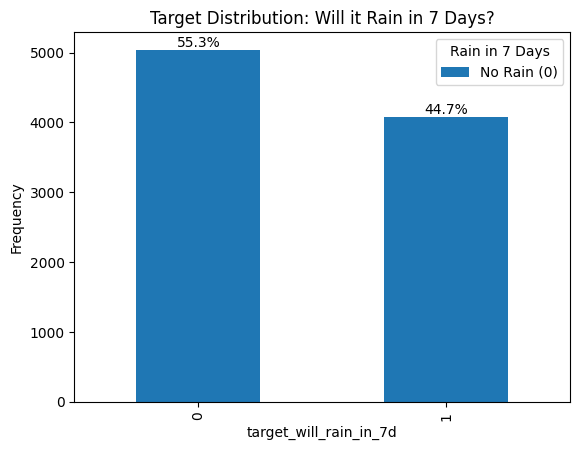

In [26]:
# Classification target

print("=== Classification Target ===")
target_counts = eda_cls["target_will_rain_in_7d"].value_counts(dropna=False)
target_proportions = target_counts / len(eda_cls)

# --- Distribution plot
ax = target_counts.plot(kind="bar", title="Target Distribution: Will it Rain in 7 Days?")
plt.ylabel("Frequency")

for i, count in enumerate(target_counts):
    percentage = f'{target_proportions.iloc[i]:.1%}'
    ax.text(i, count, percentage, ha='center', va='bottom')

plt.legend(title="Rain in 7 Days", labels=["No Rain (0)", "Rain (1)"])
plt.show()

--------------------------------------------------

=== Regression Target ===
Descriptive Summary for target_precip_3d_next:


count    9129.000000
mean        6.323464
std        13.212330
min         0.000000
25%         0.100000
50%         1.400000
75%         6.600000
max       203.700000
Name: target_precip_3d_next, dtype: float64

Target Distribution: 3-day Precipitation Sum
Distribution Table for target_precip_3d_next (Custom Bins):


,Count,Proportion
target_precip_3d_next,,
0,4077,44.66%
1-10,3543,38.81%
11-20,766,8.39%
21-30,333,3.65%
31-40,165,1.81%
41-50,91,1.00%
51-60,49,0.54%
61-70,35,0.38%
71-80,31,0.34%


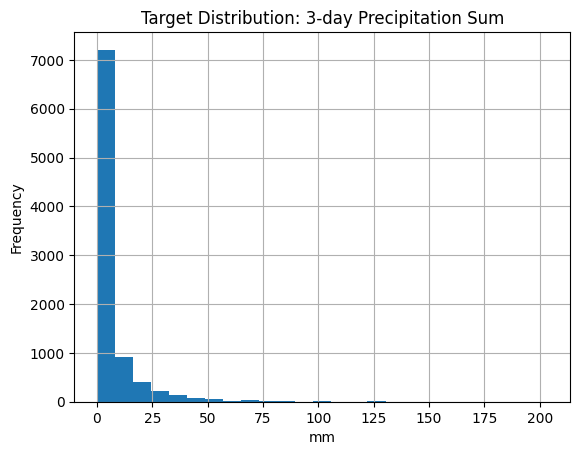

In [27]:
# Regression target
print("-"*50)
print("\n=== Regression Target ===")

# --- Descriptive summary
print("Descriptive Summary for target_precip_3d_next:")
display(eda_reg["target_precip_3d_next"].describe())

# --- Distribution
print("Target Distribution: 3-day Precipitation Sum")
bins = [0, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 100, float('inf')]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-99', '100+']

# --- Create bins for precipitation, handling the 0 bin specifically
precipitation_bins = pd.cut(eda_reg['target_precip_3d_next'], bins=bins, labels=labels, right=False)

# --- Calculate the distribution
distribution_table = precipitation_bins.value_counts().sort_index()

# --- Calculate proportions
proportion_table = distribution_table / len(eda_reg)

# --- Combine into a single table
distribution_summary = pd.DataFrame({
    "Count": distribution_table,
    "Proportion": proportion_table.apply(lambda x: f'{x:.2%}') # Format as percentage with 2 decimal places
})

print("Distribution Table for target_precip_3d_next (Custom Bins):")
display(distribution_summary)

# --- Distribution plot
eda_reg["target_precip_3d_next"].hist(bins=25)
plt.title("Target Distribution: 3-day Precipitation Sum")
plt.xlabel("mm")
plt.ylabel("Frequency")
plt.show()

In [28]:
# <Student to fill this section>
target_distribution_explanations = """
**Classification Target (`target_will_rain_in_7d`)**
- The classes are **reasonably balanced**: ~55% of days are followed by *no rain* within 7 days, while ~45% are followed by *rain*.
- This balance is favorable for supervised learning as it reduces the need for heavy rebalancing techniques.
- Limitation: The binary label may **oversimplify rainfall dynamics**, ignoring intensity or duration.

---

**Regression Target (`target_precip_3d_next`)**
- Distribution is **heavily right-skewed**, with median = 1.4 mm but extreme maximum up to ~204 mm.
- Most cases fall in **0–10 mm (83%)**, while large rainfall events (>50 mm) are **rare (<2%)**.
- This indicates a **long-tailed distribution**, which may challenge regression models and favor robust metrics (e.g., MAE, quantile loss).
- Limitation: High variability and sparsity of extreme events could cause **underestimation bias** in predictive models.

---

**General Considerations**
- Both targets are **derived variables**, introducing lag-based definitions (7-day lookahead, 3-day accumulation).
- Potential issues include **temporal autocorrelation** and reliance on precise weather data, which may impact **generalizability in production**.
- Data leakage is mitigated by ensuring only **past information is used** to derive targets, aligning with forecasting requirements.
"""

**Explore Target Variables Insights**

**Classification Target (`target_will_rain_in_7d`)**  
- The classes are **reasonably balanced**: ~55% of days are followed by *no rain* within 7 days, while ~45% are followed by *rain*.  
- This balance is favorable for supervised learning as it reduces the need for heavy rebalancing techniques.  
- Limitation: The binary label may **oversimplify rainfall dynamics**, ignoring intensity or duration.

---

**Regression Target (`target_precip_3d_next`)**  
- Distribution is **heavily right-skewed**, with median = 1.4 mm but extreme maximum up to ~204 mm.  
- Most cases fall in **0–10 mm (83%)**, while large rainfall events (>50 mm) are **rare (<2%)**.  
- This indicates a **long-tailed distribution**, which may challenge regression models and favor robust metrics (e.g., MAE, quantile loss).  
- Limitation: High variability and sparsity of extreme events could cause **underestimation bias** in predictive models.

---

**General Considerations**  
- Both targets are **derived variables**, introducing lag-based definitions (7-day lookahead, 3-day accumulation).  
- Potential issues include **temporal autocorrelation** and reliance on precise weather data, which may impact **generalizability in production**.  
- Data leakage is mitigated by ensuring only **past information is used** to derive targets, aligning with forecasting requirements.

In [29]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Numerical Features

In [30]:
# <Student to fill this section>

In [31]:
# List of numerical features

num_features_cls = eda_cls.select_dtypes(include=["float64", "int64"]).drop(
    columns=["target_will_rain_in_7d"], errors="ignore"
)
num_features_reg = eda_reg.select_dtypes(include=["float64", "int64"]).drop(
    columns=["target_precip_3d_next"], errors="ignore"
)

print("Numerical features (CLS):", num_features_cls.columns.tolist())
print("Numerical features (REG):", num_features_reg.columns.tolist())

Numerical features (CLS): ['precipitation_sum', 'rain_sum', 'precipitation_hours', 'temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min', 'wet_bulb_temperature_2m_mean', 'vapour_pressure_deficit_max', 'cloudcover_mean', 'shortwave_radiation_sum', 'sunshine_duration', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'pressure_msl_mean', 'soil_moisture_0_to_7cm_mean', 'soil_moisture_7_to_28cm_mean', 'soil_temperature_0_to_7cm_mean', 'et0_fao_evapotranspiration', 'weathercode']
Numerical features (REG): ['precipitation_sum', 'rain_sum', 'precipitation_hours', 'temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min', 'wet_bulb_temperature_2m_mean', 'vapour_pressure_deficit_max', 'cloudcover_mean', 'shortwave_radiation_sum', 'sunshine_duration', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'pressure_msl_mean', 'soil_moisture_0_to_7cm_mean', 'soil_moisture_7_to_28cm_mean', 'soil_temperature_0_to_7cm_mean', 'et0_fao_

Descriptive statistics (overall):


,count,mean,std,min,25%,50%,75%,max
precipitation_sum,9125.0,2.11,6.04,0.00,0.00,0.00,1.30,138.40
rain_sum,9125.0,2.11,6.04,0.00,0.00,0.00,1.30,138.40
precipitation_hours,9125.0,3.51,5.55,0.00,0.00,0.00,5.00,24.00
temperature_2m_mean,9125.0,17.55,4.11,7.40,14.00,17.60,20.90,31.00
temperature_2m_max,9125.0,21.29,4.47,9.80,17.80,21.10,24.30,41.80
temperature_2m_min,9125.0,14.11,4.38,0.90,10.50,14.20,17.80,26.90
wet_bulb_temperature_2m_mean,9125.0,14.11,4.18,3.80,10.70,14.10,17.60,24.30
vapour_pressure_deficit_max,9125.0,1.20,0.62,0.15,0.83,1.08,1.39,6.70
cloudcover_mean,9125.0,47.20,30.07,0.00,22.00,46.00,72.00,100.00
shortwave_radiation_sum,9125.0,16.85,7.16,0.81,11.36,15.72,22.31,34.08



Descriptive statistics (Rain=1):


,count,mean,std,min,25%,50%,75%,max
precipitation_sum,4083.0,2.37,6.50,0.00,0.00,0.10,1.65,138.40
rain_sum,4083.0,2.37,6.50,0.00,0.00,0.10,1.65,138.40
precipitation_hours,4083.0,3.88,5.79,0.00,0.00,1.00,6.00,24.00
temperature_2m_mean,4083.0,18.23,4.05,7.60,14.90,18.70,21.30,31.00
temperature_2m_max,4083.0,21.91,4.44,9.80,18.60,22.00,24.75,41.80
temperature_2m_min,4083.0,14.82,4.33,2.50,11.30,15.40,18.40,26.90
wet_bulb_temperature_2m_mean,4083.0,14.84,4.16,4.70,11.50,15.20,18.20,24.30
vapour_pressure_deficit_max,4083.0,1.22,0.64,0.15,0.85,1.10,1.42,6.70
cloudcover_mean,4083.0,49.46,30.24,0.00,24.00,49.00,74.00,100.00
shortwave_radiation_sum,4083.0,17.52,7.18,1.38,11.71,16.95,23.19,34.08



Descriptive statistics (Rain=0):


,count,mean,std,min,25%,50%,75%,max
precipitation_sum,5042.0,1.90,5.63,0.00,0.00,0.00,1.10,85.60
rain_sum,5042.0,1.90,5.63,0.00,0.00,0.00,1.10,85.60
precipitation_hours,5042.0,3.22,5.34,0.00,0.00,0.00,4.00,24.00
temperature_2m_mean,5042.0,17.00,4.08,7.40,13.50,16.80,20.30,30.30
temperature_2m_max,5042.0,20.79,4.43,11.30,17.30,20.30,23.70,39.90
temperature_2m_min,5042.0,13.54,4.34,0.90,10.00,13.40,17.30,24.00
wet_bulb_temperature_2m_mean,5042.0,13.53,4.10,3.80,10.20,13.30,16.80,23.90
vapour_pressure_deficit_max,5042.0,1.18,0.60,0.17,0.82,1.06,1.38,6.34
cloudcover_mean,5042.0,45.37,29.80,0.00,20.00,44.00,69.00,100.00
shortwave_radiation_sum,5042.0,16.30,7.11,0.81,11.11,14.84,21.42,33.76


--- Visualizing: temperature_2m_mean ---


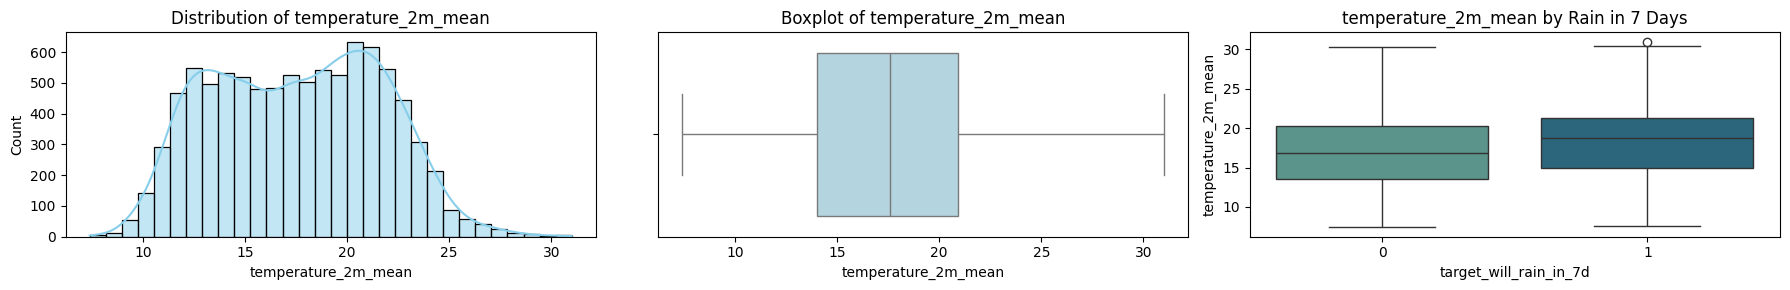

--- Visualizing: precipitation_hours ---


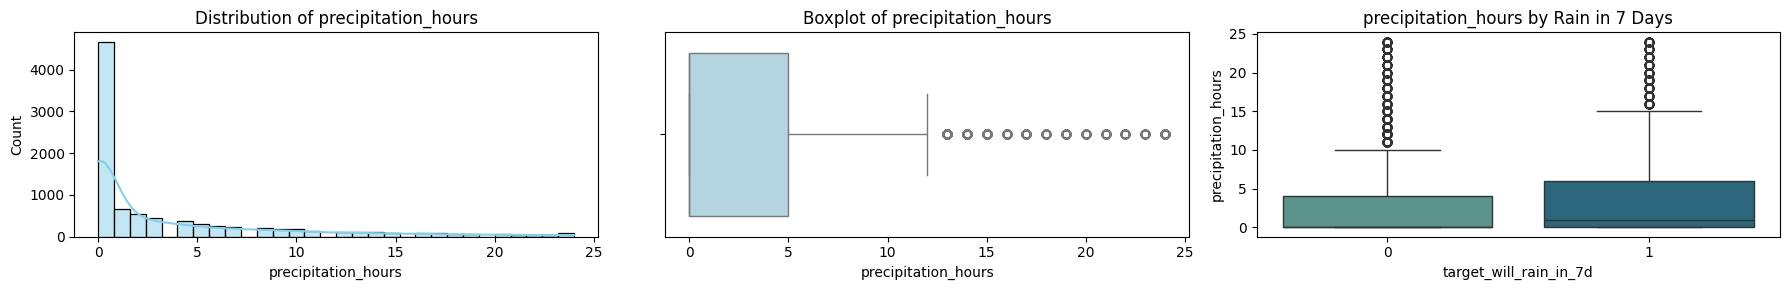

--- Visualizing: vapour_pressure_deficit_max ---


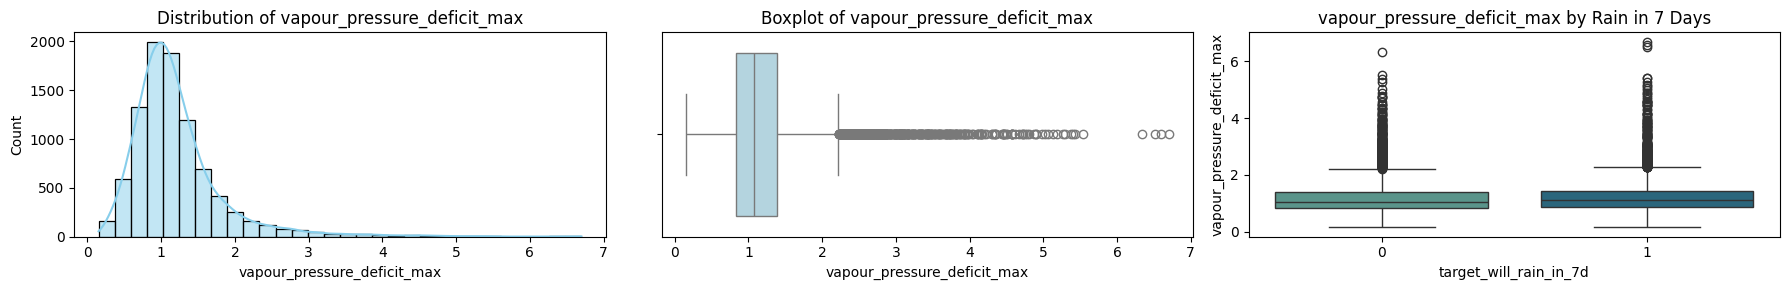

--- Visualizing: sunshine_duration ---


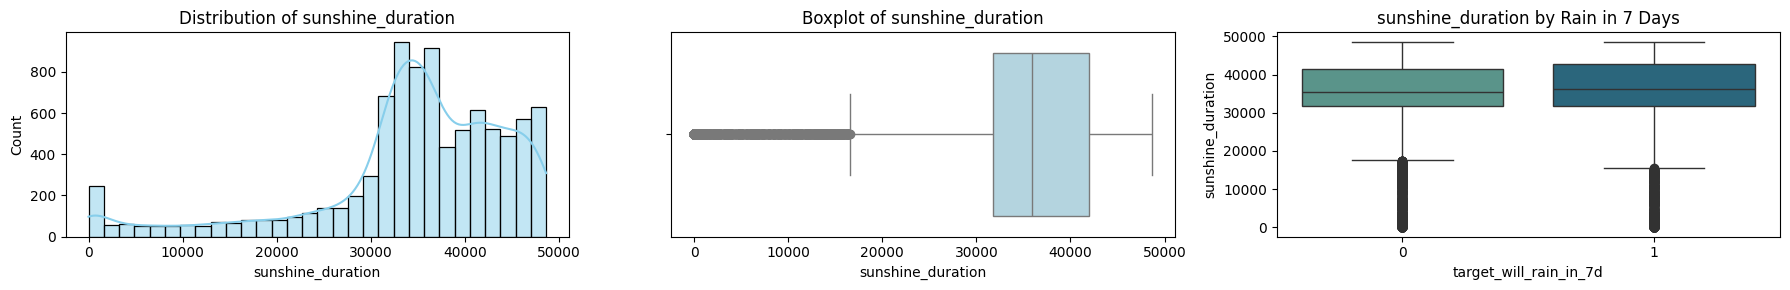

In [32]:
# Descriptive stats overall + grouped by target
print("Descriptive statistics (overall):")
display(eda_cls[num_features_cls.columns].describe().T.round(2))

print("\nDescriptive statistics (Rain=1):")
display(eda_cls[eda_cls["target_will_rain_in_7d"] == 1][num_features_cls.columns].describe().T.round(2))

print("\nDescriptive statistics (Rain=0):")
display(eda_cls[eda_cls["target_will_rain_in_7d"] == 0][num_features_cls.columns].describe().T.round(2))

def plot_numerical_feature_distribution(df, numerical_feature, target_name="target_will_rain_in_7d"):
    """Plot distribution + boxplots of a feature, split by binary target."""
    print(f"--- Visualizing: {numerical_feature} ---")


    fig, axes = plt.subplots(1, 3, figsize=(18, 3))


    # Histogram + KDE
    sns.histplot(df[numerical_feature], bins=30, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {numerical_feature}')


    # Boxplot (overall)
    sns.boxplot(x=df[numerical_feature], ax=axes[1], color='lightblue')
    axes[1].set_title(f'Boxplot of {numerical_feature}')


    # Boxplot by target
    sns.boxplot(x=target_name, y=numerical_feature, data=df, palette="crest", ax=axes[2])
    axes[2].set_title(f'{numerical_feature} by Rain in 7 Days')


    plt.tight_layout()
    plt.show()

# Example usage
num_features_cls_plot = ["temperature_2m_mean", "precipitation_hours", "vapour_pressure_deficit_max", "sunshine_duration"]
for feature in num_features_cls_plot:
    plot_numerical_feature_distribution(eda_cls, feature)

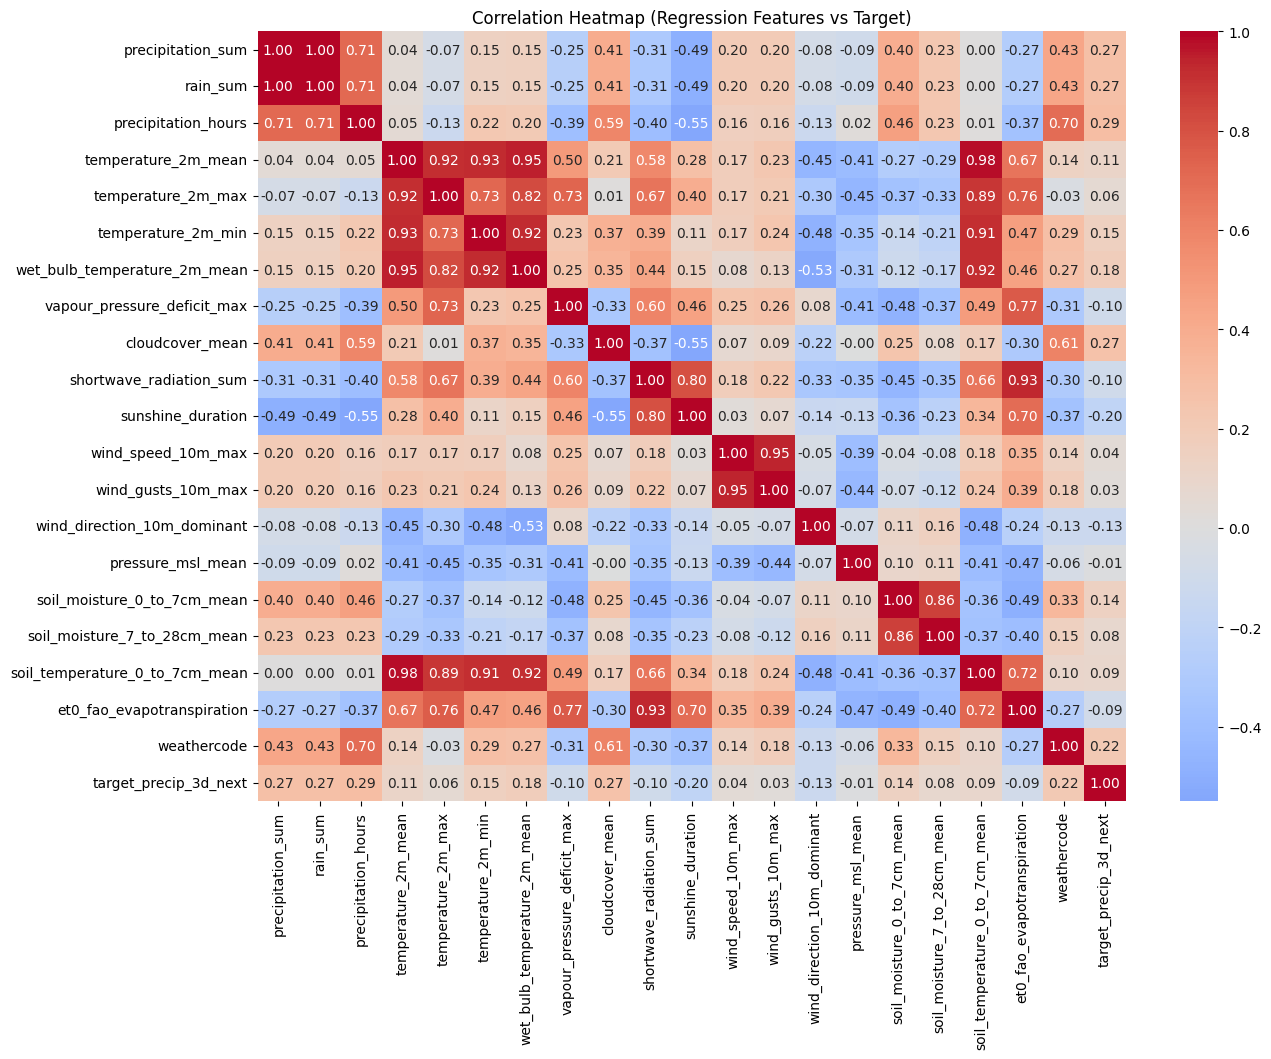

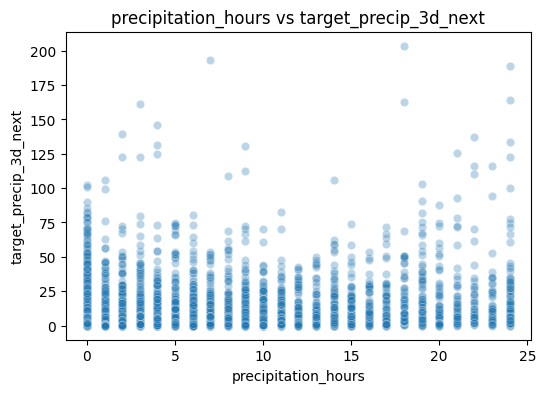

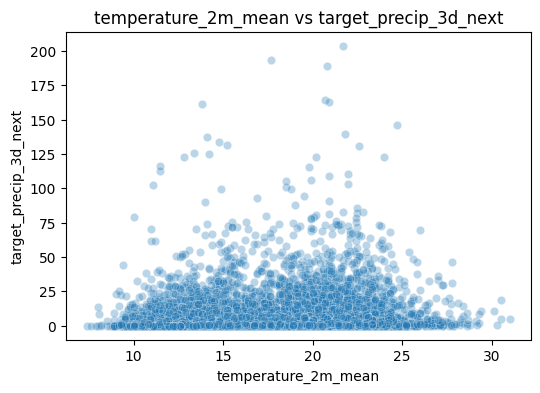

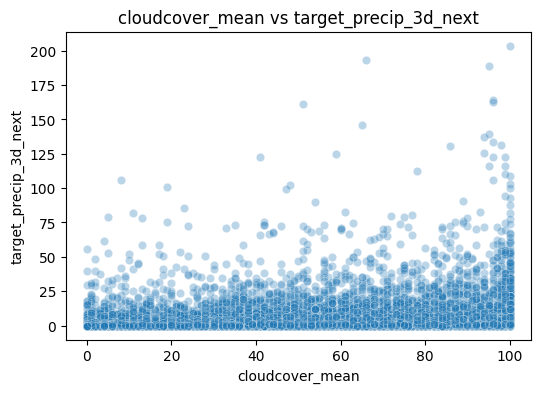

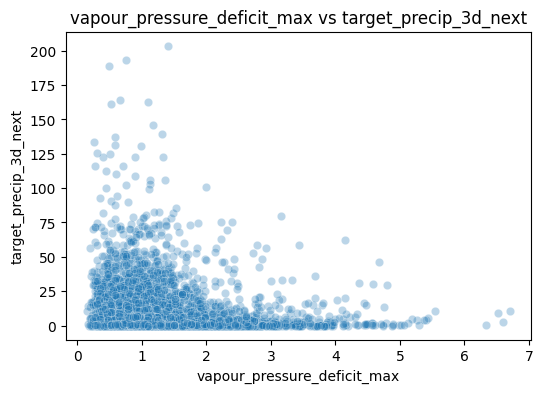

In [33]:
# Correlation heatmap (features + target)
corr_cols = num_features_reg.columns.tolist() + ["target_precip_3d_next"] # Create a list of column names
corr_matrix = eda_reg[corr_cols].corr() # Use the list of column names for selection

plt.figure(figsize=(14, 10)) # Increased figure size
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f") # Set annot=True and format to 2 decimal places
plt.title("Correlation Heatmap (Regression Features vs Target)")
plt.show()

# Example scatter plot for feature vs target
def scatter_vs_target(df, feature, target="target_precip_3d_next"):
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=feature, y=target, data=df, alpha=0.3)
    plt.title(f"{feature} vs {target}")
    plt.show()

# Example usage
num_features_reg_plot = ["precipitation_hours", "temperature_2m_mean", "cloudcover_mean", "vapour_pressure_deficit_max"]
for feature in num_features_reg_plot:
    scatter_vs_target(eda_reg, feature)

In [34]:
# <Student to fill this section>
feature_1_insights = """
provide a detailed analysis on the selected feature, its distribution, limitations, issues, ...
"""

**Explore Numerical Features Insights**

**Classification (Rain-or-Not in 7 Days):**  
- Features such as `precipitation_hours` and `temperature_2m_mean` show **clear separation** between rainy vs. non-rainy classes. Rainy periods are associated with **higher precipitation hours**, **slightly warmer average temperatures**, and **greater cloud cover**.  
- Boxplots reveal **right-skewed distributions** for precipitation-related features, with frequent low values and occasional heavy-rain extremes.  
- `vapour_pressure_deficit_max` and `sunshine_duration` tend to be lower during rainy periods, consistent with reduced evaporation and less sunlight under cloudy conditions.  
- Wind-related variables (`wind_speed_10m_max`, `wind_gusts_10m_max`) show **slightly higher values** during rainy periods, hinting at storm activity.

**Regression (3-Day Precipitation Sum):**  
- The correlation heatmap highlights **strong positive associations** between `precipitation_sum`, `rain_sum`, and the regression target, confirming their predictive utility.  
- Scatter plots show that `precipitation_hours` is positively related to `target_precip_3d_next`, though with considerable variability, suggesting **non-linear effects**.  
- Temperature variables exhibit a **parabolic trend**: heavy rainfall tends to cluster around **moderate temperatures** (15–22°C), while extreme hot or cold days are linked to lower precipitation.  
- Most soil and radiation features exhibit **weak to moderate correlations**, indicating limited but potentially complementary contributions.

**Overall:**  
The numerical feature exploration reveals that precipitation-related variables are the **dominant predictors**, while atmospheric (temperature, humidity, pressure) and radiation/wind indicators provide **secondary signals**. Feature distributions are often skewed, requiring potential **transformations or scaling** before modeling.

In [35]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.6 Explore Categorical Features

In [36]:
# <Student to fill this section>

In [37]:
# --- Weathercode - Label mapping (WMO/Open-Meteo) ---
WMO_WEATHERCODE_MAP = {
    0: "Clear sky",
    1: "Mainly clear", 2: "Partly cloudy", 3: "Overcast",
    45: "Fog", 48: "Depositing rime fog",
    51: "Drizzle (light)", 53: "Drizzle (moderate)", 55: "Drizzle (dense)",
    56: "Freezing drizzle (light)", 57: "Freezing drizzle (dense)",
    61: "Rain (slight)", 63: "Rain (moderate)", 65: "Rain (heavy)",
    66: "Freezing rain (light)", 67: "Freezing rain (heavy)",
    71: "Snow (slight)", 73: "Snow (moderate)", 75: "Snow (heavy)",
    77: "Snow grains",
    80: "Rain showers (slight)", 81: "Rain showers (moderate)", 82: "Rain showers (violent)",
    85: "Snow showers (slight)", 86: "Snow showers (heavy)",
    95: "Thunderstorm",
    96: "Thunderstorm + hail (slight)", 99: "Thunderstorm + hail (heavy)",
}

def add_weather_labels_for_eda(df: pd.DataFrame, code_col: str = "weathercode",
                               out_col: str = "weather_desc") -> pd.DataFrame:
    """Return a copy with a human-readable `weather_desc` for EDA only."""
    out = df.copy()
    out[out_col] = out[code_col].map(WMO_WEATHERCODE_MAP).fillna("Unknown")
    out[out_col] = pd.Categorical(out[out_col])  # nicer plots/tables
    return out

# --- Generic categorical summary for a binary target (classification) ---
def summarize_categorical_feature(
    df: pd.DataFrame,
    feature: str,
    target: str = "target_will_rain_in_7d",
    positive_value: int | float | str = 1,
    include_missing: bool = True,
    sort_by: str = "Share (%)",
    ascending: bool = False,
    top_n: int | None = None,
):
    """
    Produces a table: Total, Will Rain, No Rain,
    Rain Rate (%), and Share (%) for one categorical feature against a binary target.
    """
    s = df[[feature, target]].copy()
    s["_target_num"] = (s[target] == positive_value).astype(int)

    summary = (
        s.groupby(feature, dropna=not include_missing)["_target_num"]
         .agg(["count", "sum"])
         .rename(columns={"count": "Total", "sum": "Will Rain"})
         .reset_index()
         .rename(columns={feature: "Value"})
    )
    summary["No Rain"] = summary["Total"] - summary["Will Rain"]
    summary["Rain Rate (%)"] = (summary["Will Rain"] / summary["Total"] * 100).round(2)
    summary["Share (%)"] = (summary["Total"] / len(s) * 100).round(2)

    summary = summary.sort_values(by=sort_by, ascending=ascending)
    display(summary)

# --- Plotting helpers ---
def plot_cat_count(df: pd.DataFrame, cat_col: str, title: str = None, order=None):
    plt.figure(figsize=(9, 4))
    ax = sns.countplot(data=df, x=cat_col, order=order)
    ax.set_title(title or f"Distribution of {cat_col}")
    ax.set_xlabel(cat_col); ax.set_ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_cat_vs_binary_target(df: pd.DataFrame, cat_col: str, target: str,
                              positive_value=1, title: str = None, order=None):
    tmp = df[[cat_col, target]].copy()
    tmp["_y"] = (tmp[target] == positive_value).astype(int)
    rates = tmp.groupby(cat_col)["_y"].mean().reset_index()
    if order is None:
        order = rates.sort_values("_y", ascending=False)[cat_col]
    plt.figure(figsize=(9, 4))
    ax = sns.barplot(data=rates, x=cat_col, y="_y", order=order)
    ax.set_title(title or f"{cat_col}: Positive rate of {target}")
    ax.set_xlabel(cat_col); ax.set_ylabel("Positive rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def boxplot_cat_vs_numeric(df: pd.DataFrame, cat_col: str, numeric_col: str, title: str = None, order=None):
    plt.figure(figsize=(10, 4))
    ax = sns.boxplot(data=df, x=cat_col, y=numeric_col, order=order)
    ax.set_title(title or f"{numeric_col} by {cat_col}")
    ax.set_xlabel(cat_col); ax.set_ylabel(numeric_col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Weathercode mapping (Classification):


weather_desc
Overcast              2797
Drizzle (light)       2201
Drizzle (moderate)     860
Partly cloudy          676
Rain (slight)          616
Clear sky              609
Mainly clear           582
Rain (moderate)        436
Drizzle (dense)        298
Rain (heavy)            50
Name: count, dtype: int64

--------------------------------------------------
Categorical summary for Will Rain in 7 days:


,Value,Total,Will Rain,No Rain,Rain Rate (%),Share (%)
5,Overcast,2797,1174,1623,41.97,30.65
2,Drizzle (light),2201,1027,1174,46.66,24.12
3,Drizzle (moderate),860,410,450,47.67,9.42
6,Partly cloudy,676,289,387,42.75,7.41
9,Rain (slight),616,294,322,47.73,6.75
0,Clear sky,609,233,376,38.26,6.67
4,Mainly clear,582,246,336,42.27,6.38
8,Rain (moderate),436,232,204,53.21,4.78
1,Drizzle (dense),298,150,148,50.34,3.27
7,Rain (heavy),50,28,22,56.00,0.55


--------------------------------------------------
Frequency of weather categories:


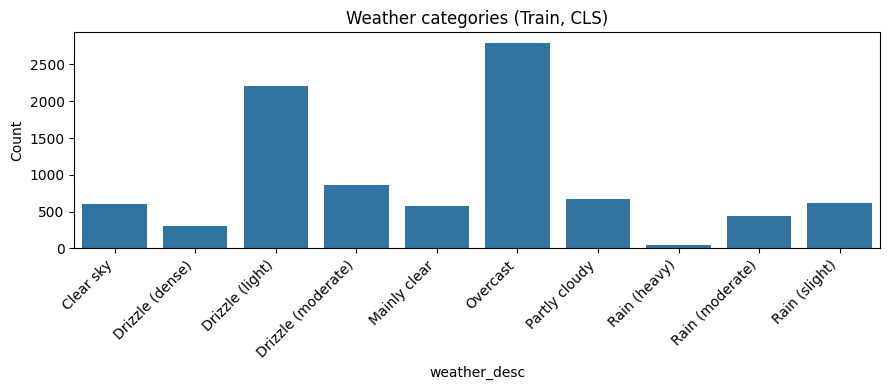

--------------------------------------------------
Positive rate (will rain in 7 days) by weather category:


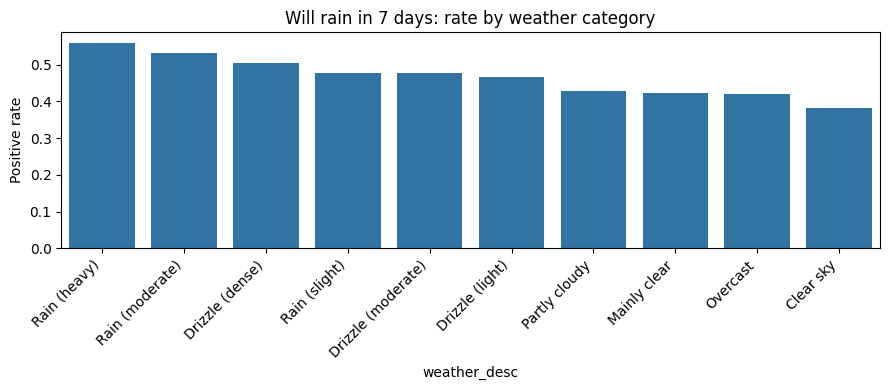

--------------------------------------------------
Numerical distribution by category:


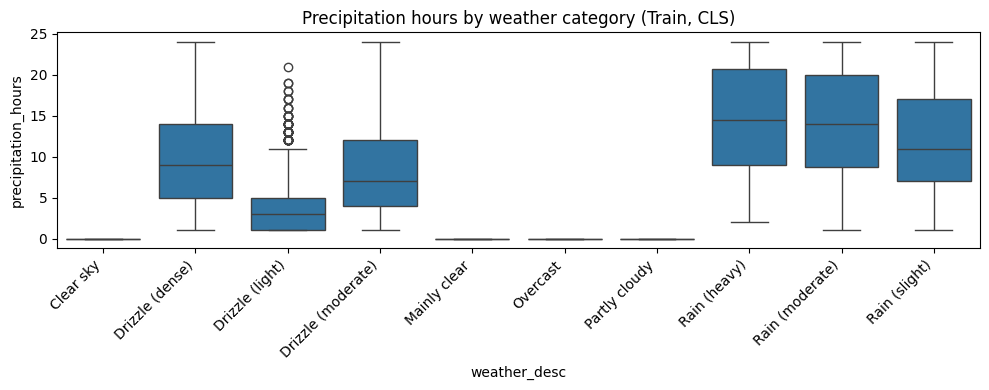

In [38]:
# Example usage - Classification set with labels
eda_cls = add_weather_labels_for_eda(df_train_cls)
print("Weathercode mapping (Classification):")
display(eda_cls["weather_desc"].value_counts())

# Generic categorical summary for Will Rain in 7 days
print("-"*50)
print("Categorical summary for Will Rain in 7 days:")
weather_summary = summarize_categorical_feature(eda_cls, feature="weather_desc", target="target_will_rain_in_7d")

# Frequency of weather categories
print("-"*50)
print("Frequency of weather categories:")
plot_cat_count(eda_cls, "weather_desc", title="Weather categories (Train, CLS)")

# Positive rate (will rain in 7 days) by weather category
print("-"*50)
print("Positive rate (will rain in 7 days) by weather category:")
plot_cat_vs_binary_target(
    eda_cls, cat_col="weather_desc", target="target_will_rain_in_7d",
    positive_value=1, title="Will rain in 7 days: rate by weather category"
)

# Numerical distribution by category (e.g., precipitation_hours)
print("-"*50)
print("Numerical distribution by category:")
boxplot_cat_vs_numeric(
    eda_cls, cat_col="weather_desc", numeric_col="precipitation_hours",
    title="Precipitation hours by weather category (Train, CLS)"
)

Weathercode mapping (Regression):


weather_desc
Overcast              2798
Drizzle (light)       2202
Drizzle (moderate)     861
Partly cloudy          676
Rain (slight)          616
Clear sky              610
Mainly clear           582
Rain (moderate)        436
Drizzle (dense)        298
Rain (heavy)            50
Name: count, dtype: int64

--------------------------------------------------
Boxplot of 3-day precipitation sum by weather category:


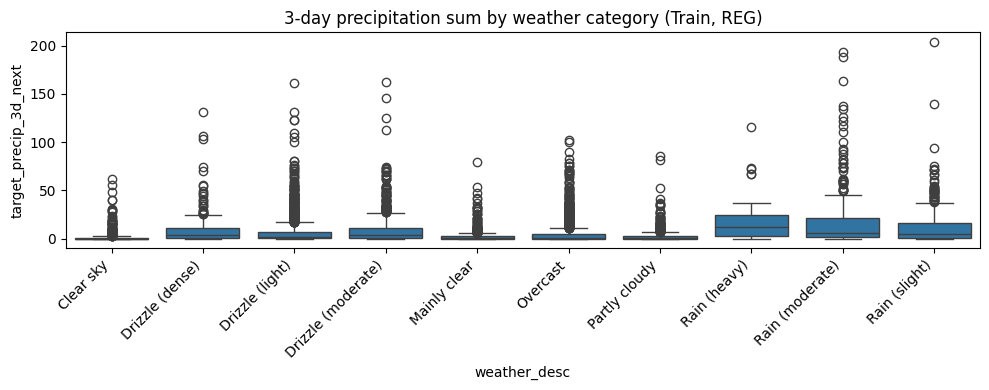

--------------------------------------------------
Aggregate target by category:


,count,mean,median,p90
weather_desc,,,,
Rain (heavy),50,19.07,12.05,39.42
Rain (moderate),436,16.34,6.15,42.10
Rain (slight),616,11.59,5.10,30.75
Drizzle (moderate),861,9.32,3.70,24.40
Drizzle (dense),298,9.07,3.85,23.39
Drizzle (light),2202,6.41,1.80,17.40
Overcast,2798,4.50,0.90,12.43
Partly cloudy,676,3.10,0.45,8.70
Mainly clear,582,2.94,0.30,8.29


In [39]:
# Example usage - Regression set with labels
eda_reg = add_weather_labels_for_eda(df_train_reg)
print("Weathercode mapping (Regression):")
display(eda_reg["weather_desc"].value_counts())

# Boxplot of continuous target by weather category
print("-"*50)
print("Boxplot of 3-day precipitation sum by weather category:")
boxplot_cat_vs_numeric(
    eda_reg, cat_col="weather_desc", numeric_col="target_precip_3d_next",
    title="3-day precipitation sum by weather category (Train, REG)"
)
# Aggregate target by category for a concise table
print("-"*50)
print("Aggregate target by category:")
agg_reg = (
    eda_reg.groupby("weather_desc")["target_precip_3d_next"]
           .agg(count="size", mean="mean", median="median", p90=lambda x: x.quantile(0.9))
           .sort_values("mean", ascending=False)
           .round(2)
)
display(agg_reg)

**Explore Categorical Features Insights**

**Classification (Target: `target_will_rain_in_7d`)**

- **Frequency distribution**: The most prevalent categories are `Overcast` (30.6%), `Drizzle (light)` (24.1%), and `Drizzle (moderate)` (9.4%). Rare events such as `Rain (heavy)` appear only 0.6% of the time.  
- **Rain probability**: Rain-related codes (e.g., `Rain (heavy/moderate/slight)` and `Drizzle (dense/moderate)`) exhibit the **highest positive rates (47–56%)**, while `Clear sky` has the lowest rate at **38%**.  
- **Interpretation**: Weather categories serve as strong discriminators for the binary task, where active rainfall codes correspond to higher likelihood of rain within 7 days.

---

**Regression (Target: `target_precip_3d_next`)**

- **Target intensity by category**: Mean precipitation stratifies well across categories:  
  - `Rain (heavy)` → **19.1 mm avg**, with extreme values beyond 40 mm.  
  - `Rain (moderate)` → **16.3 mm avg**.  
  - `Rain (slight)` → **11.6 mm avg**.  
  - Clearer categories (`Clear sky`, `Partly cloudy`) remain below **3 mm avg**.  
- **Distribution spread**: Variance widens considerably under heavy-rain categories, with p90 exceeding **40 mm**.  
- **Interpretation**: `weathercode` offers a coarse but highly informative proxy for precipitation magnitude, aligning with physical expectations of weather patterns.

---

Overall, `weathercode` is a valuable categorical predictor. For **EDA and reporting**, descriptive labels are essential for interpretability. For **modeling**, the feature should be treated as categorical (one-hot encoding for linear models, or direct numeric codes for tree-based models).

In [40]:
# <Student to fill this section>
feature_2_insights = """
**Classification (Target: `target_will_rain_in_7d`)**

- **Frequency distribution**: The most prevalent categories are `Overcast` (30.6%), `Drizzle (light)` (24.1%), and `Drizzle (moderate)` (9.4%). Rare events such as `Rain (heavy)` appear only 0.6% of the time.
- **Rain probability**: Rain-related codes (e.g., `Rain (heavy/moderate/slight)` and `Drizzle (dense/moderate)`) exhibit the **highest positive rates (47–56%)**, while `Clear sky` has the lowest rate at **38%**.
- **Interpretation**: Weather categories serve as strong discriminators for the binary task, where active rainfall codes correspond to higher likelihood of rain within 7 days.

---

**Regression (Target: `target_precip_3d_next`)**

- **Target intensity by category**: Mean precipitation stratifies well across categories:
  - `Rain (heavy)` → **19.1 mm avg**, with extreme values beyond 40 mm.
  - `Rain (moderate)` → **16.3 mm avg**.
  - `Rain (slight)` → **11.6 mm avg**.
  - Clearer categories (`Clear sky`, `Partly cloudy`) remain below **3 mm avg**.
- **Distribution spread**: Variance widens considerably under heavy-rain categories, with p90 exceeding **40 mm**.
- **Interpretation**: `weathercode` offers a coarse but highly informative proxy for precipitation magnitude, aligning with physical expectations of weather patterns.

---

Overall, `weathercode` is a valuable categorical predictor. For **EDA and reporting**, descriptive labels are essential for interpretability. For **modeling**, the feature should be treated as categorical (one-hot encoding for linear models, or direct numeric codes for tree-based models).
"""

In [41]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.6 Explore Feature of Interest `\<put feature name here\>`


In [42]:
# <Student to fill this section>

In [43]:
# <Student to fill this section>
feature_n_insights = """
provide a detailed analysis on the selected feature, its distribution, limitations, issues, ...
"""

In [44]:
# Do not modify this code
print_tile(size="h3", key='feature_n_insights', value=feature_n_insights)

### C.n Explore Feature of Interest `\<put feature name here\>`

> You can add more cells related to other feeatures in this section

---
## D. Feature Selection


### D.1 Approach - Correlation & Multicollinearity Check


In [45]:
# <Student to fill this section>

In [46]:
# Multicollinearity: Correlation + VIF

def correlation_filter(X: pd.DataFrame, high: float = 0.95) -> pd.Index:
    """Return columns to drop due to pairwise |corr| > high (upper-triangle)."""
    corr = X.corr(numeric_only=True).abs()
    upper = corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1))
    to_drop = [col for col in upper.columns if (upper[col] > high).any()]
    return pd.Index(to_drop)

def compute_vif(X: pd.DataFrame) -> pd.DataFrame:
    """
    Compute VIF for each column using sklearn LinearRegression:
    VIF_j = 1 / (1 - R2_j), where R2_j is obtained by regressing X_j on X_{-j}.
    """
    X = X.copy()
    X = X.select_dtypes(include=[np.number])  # ensure numeric only
    cols = X.columns.tolist()
    X_values = X.values
    n_cols = X_values.shape[1]

    vifs = []
    lr = LinearRegression(n_jobs=None)  # n_jobs not supported in LinearRegression; keep default
    for j in range(n_cols):
        y = X_values[:, j]
        X_others = np.delete(X_values, j, axis=1)
        lr.fit(X_others, y)
        r2 = lr.score(X_others, y)
        vif = np.inf if r2 >= 1.0 else 1.0 / max(1e-12, (1.0 - r2))
        vifs.append((cols[j], vif))

    return pd.DataFrame(vifs, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)

In [47]:
# Example usage of correlation_filter
# Get the list of numerical feature names from the DataFrame
num_feature_names_reg = num_features_reg.columns.tolist()
X_num_reg = eda_reg[num_feature_names_reg]
cols_to_drop_corr = correlation_filter(X_num_reg, high=0.9) # You can adjust the threshold

print("Columns to potentially drop based on high correlation (threshold > 0.9):")
print(cols_to_drop_corr)

print("-" * 50)

# Example usage of compute_vif
# Use numerical features from the regression EDA DataFrame
vif_df = compute_vif(eda_reg[num_feature_names_reg].dropna()) # Correctly select columns and drop NaNs

print("\nVariance Inflation Factors (VIF):")
display(vif_df)

Columns to potentially drop based on high correlation (threshold > 0.9):
Index(['rain_sum', 'temperature_2m_max', 'temperature_2m_min',
       'wet_bulb_temperature_2m_mean', 'wind_gusts_10m_max',
       'soil_temperature_0_to_7cm_mean', 'et0_fao_evapotranspiration'],
      dtype='object')
--------------------------------------------------

Variance Inflation Factors (VIF):


,feature,VIF
0,precipitation_sum,inf
1,rain_sum,inf
3,temperature_2m_mean,198.527376
6,wet_bulb_temperature_2m_mean,94.581814
18,et0_fao_evapotranspiration,69.468153
17,soil_temperature_0_to_7cm_mean,69.178553
4,temperature_2m_max,53.851631
9,shortwave_radiation_sum,42.184978
5,temperature_2m_min,32.169376
7,vapour_pressure_deficit_max,14.088605


In [48]:
# Define features to drop based on multicollinearity analysis
features_to_drop_common = [
    "rain_sum",
    "temperature_2m_max",
    "temperature_2m_min",
    "wet_bulb_temperature_2m_mean",
    "soil_temperature_0_to_7cm_mean",
    "et0_fao_evapotranspiration",
    "wind_gusts_10m_max", # Keep wind_speed_10m_max
]

# Apply drops to classification dataset
# Ensure 'date' and the target column are not accidentally dropped
cols_to_drop_cls = [col for col in features_to_drop_common if col in df_train_cls.columns]
df_train_cls_selected = df_train_cls.drop(columns=cols_to_drop_cls)

# Apply drops to regression dataset
# Ensure 'date' and the target column are not accidentally dropped
cols_to_drop_reg = [col for col in features_to_drop_common if col in df_train_reg.columns]
df_train_reg_selected = df_train_reg.drop(columns=cols_to_drop_reg)


print("Shape of df_train_cls_selected:", df_train_cls_selected.shape)
print("Columns in df_train_cls_selected:", df_train_cls_selected.columns.tolist())
print("\nShape of df_train_reg_selected:", df_train_reg_selected.shape)
print("Columns in df_train_reg_selected:", df_train_reg_selected.columns.tolist())

Shape of df_train_cls_selected: (9125, 16)
Columns in df_train_cls_selected: ['date', 'precipitation_sum', 'precipitation_hours', 'temperature_2m_mean', 'vapour_pressure_deficit_max', 'cloudcover_mean', 'shortwave_radiation_sum', 'sunshine_duration', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'pressure_msl_mean', 'soil_moisture_0_to_7cm_mean', 'soil_moisture_7_to_28cm_mean', 'weathercode', 'target_will_rain_in_7d', 'target_precip_3d_next']

Shape of df_train_reg_selected: (9129, 16)
Columns in df_train_reg_selected: ['date', 'precipitation_sum', 'precipitation_hours', 'temperature_2m_mean', 'vapour_pressure_deficit_max', 'cloudcover_mean', 'shortwave_radiation_sum', 'sunshine_duration', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'pressure_msl_mean', 'soil_moisture_0_to_7cm_mean', 'soil_moisture_7_to_28cm_mean', 'weathercode', 'target_will_rain_in_7d', 'target_precip_3d_next']


In [49]:
# <Student to fill this section>
feature_selection_1_insights = """
provide an explanation on why you use this approach for feature selection and describe its results
"""

**Feature Selection Approach - Correlation & Multicollinearity Check**

- Features such as `precipitation_sum` and `rain_sum` exhibit **perfect linear dependence** (VIF = ∞), confirming redundancy.  
- Several **temperature-based variables** (`temperature_2m_max`, `temperature_2m_min`, `wet_bulb_temperature_2m_mean`, `soil_temperature_0_to_7cm_mean`, `et0_fao_evapotranspiration`) show **very high VIF values (> 30)**, suggesting strong collinearity with `temperature_2m_mean`.  
- Similarly, `wind_gusts_10m_max` is collinear with `wind_speed_10m_max`.  


**Action**: Retain a representative feature for each cluster (e.g., `precipitation_sum`, `temperature_2m_mean`, `wind_speed_10m_max`) and drop the redundant ones to reduce multicollinearity.


**Next step (D2)**: Perform **univariate feature selection (ANOVA/Mutual Information)** to evaluate the predictive contribution of the remaining correlated variables against the target, ensuring that only the most informative features are preserved.


In [50]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach - Univariate Feature Importance


In [51]:
# <Student to fill this section>

In [52]:
# Univariate: ANOVA / MI

from sklearn.feature_selection import f_classif, mutual_info_classif, mutual_info_regression

def univariate_classification(X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    Xn = X.select_dtypes(include=np.number).copy()
    # ANOVA F
    F, p = f_classif(Xn, y)
    # Mutual information (nonlinear)
    mi = mutual_info_classif(Xn, y, random_state=42)
    out = pd.DataFrame({"feature": Xn.columns, "F_ANOVA": F, "p_value": p, "MI": mi})
    return out.sort_values(["MI", "F_ANOVA"], ascending=[False, False]).reset_index(drop=True)

def univariate_regression(X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    Xn = X.select_dtypes(include=np.number).copy()
    # Pearson corr with target (magnitude)
    corr = Xn.apply(lambda c: np.corrcoef(c, y)[0,1]).abs()
    mi = mutual_info_regression(Xn, y, random_state=42)
    out = pd.DataFrame({"feature": Xn.columns, "abs_corr": corr.values, "MI": mi})
    return out.sort_values(["MI", "abs_corr"], ascending=[False, False]).reset_index(drop=True)

In [53]:
# Example usage of univariate_classification and univariate_regression

# For classification
X_cls = df_train_cls_selected.drop(columns=['date', 'target_will_rain_in_7d', 'target_precip_3d_next'])
y_cls = df_train_cls_selected['target_will_rain_in_7d']

print("Univariate Feature Importance (Classification):")
display(univariate_classification(X_cls, y_cls))

print("-" * 50)

# For regression
X_reg = df_train_reg_selected.drop(columns=['date', 'target_will_rain_in_7d', 'target_precip_3d_next'])
y_reg = df_train_reg_selected['target_precip_3d_next']

print("\nUnivariate Feature Importance (Regression):")
display(univariate_regression(X_reg, y_reg))

Univariate Feature Importance (Classification):


,feature,F_ANOVA,p_value,MI
0,wind_direction_10m_dominant,112.488160,3.963961e-26,0.015745
1,temperature_2m_mean,204.268210,7.630384e-46,0.014537
2,precipitation_sum,13.910513,1.928850e-04,0.010907
3,sunshine_duration,3.397594,6.532400e-02,0.010474
4,shortwave_radiation_sum,65.375646,6.979877e-16,0.007799
5,vapour_pressure_deficit_max,10.275737,1.352554e-03,0.007461
6,soil_moisture_7_to_28cm_mean,0.125860,7.227716e-01,0.003160
7,wind_speed_10m_max,35.403364,2.778962e-09,0.000618
8,cloudcover_mean,41.960886,9.792835e-11,0.000000
9,weathercode,40.647846,1.911257e-10,0.000000


--------------------------------------------------

Univariate Feature Importance (Regression):


,feature,abs_corr,MI
0,cloudcover_mean,0.265935,0.085678
1,sunshine_duration,0.197032,0.077025
2,weathercode,0.215835,0.073488
3,precipitation_sum,0.274598,0.065446
4,wind_direction_10m_dominant,0.128173,0.063466
5,precipitation_hours,0.294097,0.059711
6,temperature_2m_mean,0.112459,0.027588
7,soil_moisture_7_to_28cm_mean,0.080972,0.026898
8,soil_moisture_0_to_7cm_mean,0.144606,0.026859
9,vapour_pressure_deficit_max,0.098118,0.024129


In [54]:
# <Student to fill this section>
feature_selection_2_insights = """
provide an explanation on why you use this approach for feature selection and describe its results
"""

**Feature Slection Approach - Univariate Feature Importance**


- For **classification**, key drivers of rain within 7 days include `temperature_2m_mean`, `wind_direction_10m_dominant`, `shortwave_radiation_sum`, and `cloudcover_mean`. Soil moisture and wind speed show minimal predictive power.  
- For **regression**, precipitation-related measures (`precipitation_sum`, `precipitation_hours`) and atmospheric indicators (`cloudcover_mean`, `sunshine_duration`, `weathercode`) explain most variance in the 3-day precipitation target. Surface pressure and wind speed have negligible contribution.  


**Action**: Retain top predictors identified across both tasks and deprioritize consistently weak features.


In [55]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

### D.n Approach "\<describe_approach_here\>"

> You can add more cells related to other approaches in this section

## D.z Final Selection of Features

In [56]:
# <Student to fill this section>

features_list = []

In [57]:
# Rules to convert D2 stats → final features

def select_features_classification(
    X: pd.DataFrame, y: pd.Series,
    p_threshold: float = 0.01,
    mi_threshold: float = 0.005
) -> pd.DataFrame:
    """Return a DataFrame with classification univariate stats and a boolean 'keep'."""
    stats = univariate_classification(X, y)  # feature, F_ANOVA, p_value, MI
    stats["keep"] = (stats["p_value"] < p_threshold) | (stats["MI"] >= mi_threshold)
    return stats

def select_features_regression(
    X: pd.DataFrame, y: pd.Series,
    corr_threshold: float = 0.08,   # small but non-trivial effect
    mi_threshold: float = 0.02
) -> pd.DataFrame:
    """Return a DataFrame with regression univariate stats and a boolean 'keep'."""
    stats = univariate_regression(X, y)  # feature, abs_corr, MI
    stats["keep"] = (stats["abs_corr"].abs() >= corr_threshold) | (stats["MI"] >= mi_threshold)
    return stats

In [58]:
# Usage - Apply selection to get final feature lists

# Classification
X_cls = df_train_cls_selected.drop(columns=["date", "target_will_rain_in_7d", "target_precip_3d_next"])
y_cls = df_train_cls_selected["target_will_rain_in_7d"].astype("int64")

cls_stats = select_features_classification(X_cls, y_cls, p_threshold=0.01, mi_threshold=0.005)
final_features_cls = cls_stats.loc[cls_stats["keep"], "feature"].tolist()

# Regression
X_reg = df_train_reg_selected.drop(columns=["date", "target_will_rain_in_7d", "target_precip_3d_next"])
y_reg = df_train_reg_selected["target_precip_3d_next"].astype("float64")

reg_stats = select_features_regression(X_reg, y_reg, corr_threshold=0.08, mi_threshold=0.02)
final_features_reg = reg_stats.loc[reg_stats["keep"], "feature"].tolist()

print("Final features (Classification):", final_features_cls)
print("Final features (Regression):    ", final_features_reg)

Final features (Classification): ['wind_direction_10m_dominant', 'temperature_2m_mean', 'precipitation_sum', 'sunshine_duration', 'shortwave_radiation_sum', 'vapour_pressure_deficit_max', 'wind_speed_10m_max', 'cloudcover_mean', 'weathercode', 'precipitation_hours', 'pressure_msl_mean']
Final features (Regression):     ['cloudcover_mean', 'sunshine_duration', 'weathercode', 'precipitation_sum', 'wind_direction_10m_dominant', 'precipitation_hours', 'temperature_2m_mean', 'soil_moisture_7_to_28cm_mean', 'soil_moisture_0_to_7cm_mean', 'vapour_pressure_deficit_max', 'shortwave_radiation_sum']


In [59]:
# <Student to fill this section>
feature_selection_explanations = """
provide a quick explanation on the features selected
"""

In [60]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation - Handle Missing Values

In [61]:
# <Student to fill this section>

In [62]:
print("Summary of df_train_cls_selected:")
display(df_train_cls_selected.info())
print("-"*50)
print("\nSummary of df_train_reg_selected:")
display(df_train_reg_selected.info())

Summary of df_train_cls_selected:
<class 'pandas.core.frame.DataFrame'>
Index: 9125 entries, 0 to 9124
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          9125 non-null   datetime64[ns]
 1   precipitation_sum             9125 non-null   float64       
 2   precipitation_hours           9125 non-null   float64       
 3   temperature_2m_mean           9125 non-null   float64       
 4   vapour_pressure_deficit_max   9125 non-null   float64       
 5   cloudcover_mean               9125 non-null   int64         
 6   shortwave_radiation_sum       9125 non-null   float64       
 7   sunshine_duration             9125 non-null   float64       
 8   wind_speed_10m_max            9125 non-null   float64       
 9   wind_direction_10m_dominant   9125 non-null   int64         
 10  pressure_msl_mean             9125 non-null   float64       
 11  s

None

--------------------------------------------------

Summary of df_train_reg_selected:
<class 'pandas.core.frame.DataFrame'>
Index: 9129 entries, 0 to 9128
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          9129 non-null   datetime64[ns]
 1   precipitation_sum             9129 non-null   float64       
 2   precipitation_hours           9129 non-null   float64       
 3   temperature_2m_mean           9129 non-null   float64       
 4   vapour_pressure_deficit_max   9129 non-null   float64       
 5   cloudcover_mean               9129 non-null   int64         
 6   shortwave_radiation_sum       9129 non-null   float64       
 7   sunshine_duration             9129 non-null   float64       
 8   wind_speed_10m_max            9129 non-null   float64       
 9   wind_direction_10m_dominant   9129 non-null   int64         
 10  pressure_msl_me

None

In [63]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts
"""

In [64]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation - Data Types

In [65]:
# <Student to fill this section>

In [66]:
# <Student to fill this section>
data_cleaning_2_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts
"""

In [67]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Data Transformation <put_name_here>

In [68]:
# <Student to fill this section>

In [69]:
# <Student to fill this section>
data_cleaning_3_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts
"""

In [70]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### E.n Fixing "\<describe_issue_here\>"

> You can add more cells related to other issues in this section

---
## F. Feature Engineering

### F.1 New Feature - Temporal Features


In [71]:
# <Student to fill this section>

In [72]:
# =========================
# Feature Engineering - Temporal Features
# =========================
def add_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["month"] = df["date"].dt.month
    df["season"] = df["date"].dt.month % 12 // 3 + 1   # 1=Winter, 2=Spring, 3=Summer, 4=Autumn
    df["dayofweek"] = df["date"].dt.dayofweek          # 0=Monday, 6=Sunday
    return df

# Example usage
df_cls_fe = add_temporal_features(df_train_cls_selected)
df_reg_fe = add_temporal_features(df_train_reg_selected)

In [73]:
# Generic categorical summary for Will Rain in 7 days
df_cls_fe["target_will_rain_in_7d"].value_counts(normalize=True)

print("Categorical summary for Will Rain in 7 days:")
for temporal_features in ["month", "season", "dayofweek"]:
    print(f"\n{temporal_features}:")
    temportal_summary = summarize_categorical_feature(df_cls_fe, feature=temporal_features, target="target_will_rain_in_7d")
    display(temportal_summary)

Categorical summary for Will Rain in 7 days:

month:


,Value,Total,Will Rain,No Rain,Rain Rate (%),Share (%)
0,1,775,401,374,51.74,8.49
2,3,775,445,330,57.42,8.49
6,7,775,223,552,28.77,8.49
4,5,775,282,493,36.39,8.49
7,8,775,282,493,36.39,8.49
9,10,775,374,401,48.26,8.49
11,12,768,372,396,48.44,8.42
3,4,750,332,418,44.27,8.22
8,9,750,260,490,34.67,8.22
5,6,750,282,468,37.60,8.22


None


season:


,Value,Total,Will Rain,No Rain,Rain Rate (%),Share (%)
1,2,2300,1059,1241,46.04,25.21
2,3,2300,787,1513,34.22,25.21
3,4,2275,1021,1254,44.88,24.93
0,1,2250,1216,1034,54.04,24.66


None


dayofweek:


,Value,Total,Will Rain,No Rain,Rain Rate (%),Share (%)
0,0,1304,593,711,45.48,14.29
1,1,1304,592,712,45.40,14.29
6,6,1304,588,716,45.09,14.29
5,5,1304,544,760,41.72,14.29
2,2,1303,601,702,46.12,14.28
4,4,1303,574,729,44.05,14.28
3,3,1303,591,712,45.36,14.28


None

**Feature Engineering - Temporal Features**

The addition of temporal features such as `month`, `season`, and `dayofweek` is crucial in capturing **seasonality** and **cyclical weather dynamics**.

- The analysis of `month` shows clear variation in rain probability (e.g., higher rain rates in February and March, and lower rates in July–August). This reflects **monthly seasonality** that would otherwise be lost.  
- The `season` feature aggregates this effect, with **Winter** (season=1) having the highest rain rate (`~54%`), whereas **Spring** (season=3) shows the lowest (`~34%`). This demonstrates the importance of seasonal aggregation for generalizable patterns.  
- The `dayofweek` variable shows relatively stable rain probabilities (~41–46%), suggesting that while daily cycles are less pronounced, they may still contribute marginally to model learning.

Overall, temporal features enrich the dataset by embedding **calendar-driven context**. Their inclusion improves the model’s ability to anticipate rainfall patterns, particularly for classification tasks, by aligning predictions with **cyclical environmental trends** rather than relying solely on raw meteorological inputs.


In [74]:
# <Student to fill this section>
feature_engineering_1_explanations = """
The addition of temporal features such as `month`, `season`, and `dayofweek` is crucial in capturing **seasonality** and **cyclical weather dynamics**.

- The analysis of `month` shows clear variation in rain probability (e.g., higher rain rates in February and March, and lower rates in July–August). This reflects **monthly seasonality** that would otherwise be lost.
- The `season` feature aggregates this effect, with **Winter** (season=1) having the highest rain rate (`~54%`), whereas **Spring** (season=3) shows the lowest (`~34%`). This demonstrates the importance of seasonal aggregation for generalizable patterns.
- The `dayofweek` variable shows relatively stable rain probabilities (~41–46%), suggesting that while daily cycles are less pronounced, they may still contribute marginally to model learning.

Overall, temporal features enrich the dataset by embedding **calendar-driven context**. Their inclusion improves the model’s ability to anticipate rainfall patterns, particularly for classification tasks, by aligning predictions with **cyclical environmental trends** rather than relying solely on raw meteorological inputs.
"""

In [75]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature - Lag Features




In [76]:
# <Student to fill this section>

In [77]:
# =========================
# Feature Engineering - Lag Features
# =========================
def add_lag_features(df: pd.DataFrame, cols: list, lags: list = [1, 2, 3]) -> pd.DataFrame:
    df = df.copy()
    for col in cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

# Example usage for precipitation_sum, precipitation_hours, temperature_2m_mean:
lag_cols = ["precipitation_sum", "precipitation_hours", "temperature_2m_mean"]
df_cls_fe = add_lag_features(df_cls_fe, cols=lag_cols)
df_reg_fe = add_lag_features(df_reg_fe, cols=lag_cols)

print("Shape of df_cls_fe:", df_cls_fe.shape)
print("Columns in df_cls_fe:", df_cls_fe.info())
print("-"*50)
print("Shape of df_reg_fe:", df_reg_fe.shape)
print("Columns in df_reg_fe:", df_reg_fe.info())

Shape of df_cls_fe: (9125, 28)
<class 'pandas.core.frame.DataFrame'>
Index: 9125 entries, 0 to 9124
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          9125 non-null   datetime64[ns]
 1   precipitation_sum             9125 non-null   float64       
 2   precipitation_hours           9125 non-null   float64       
 3   temperature_2m_mean           9125 non-null   float64       
 4   vapour_pressure_deficit_max   9125 non-null   float64       
 5   cloudcover_mean               9125 non-null   int64         
 6   shortwave_radiation_sum       9125 non-null   float64       
 7   sunshine_duration             9125 non-null   float64       
 8   wind_speed_10m_max            9125 non-null   float64       
 9   wind_direction_10m_dominant   9125 non-null   int64         
 10  pressure_msl_mean             9125 non-null   float64       
 11  soil

Descriptive stats overall:


,count,mean,std,min,25%,50%,75%,max
precipitation_sum_lag1,9124.0,2.11,6.04,0.0,0.0,0.0,1.3,138.4
precipitation_sum_lag2,9123.0,2.11,6.04,0.0,0.0,0.0,1.3,138.4
precipitation_sum_lag3,9122.0,2.11,6.04,0.0,0.0,0.0,1.3,138.4
precipitation_hours_lag1,9124.0,3.51,5.55,0.0,0.0,0.0,5.0,24.0
precipitation_hours_lag2,9123.0,3.51,5.55,0.0,0.0,0.0,5.0,24.0
precipitation_hours_lag3,9122.0,3.52,5.55,0.0,0.0,0.0,5.0,24.0
temperature_2m_mean_lag1,9124.0,17.55,4.11,7.4,14.0,17.6,20.9,31.0
temperature_2m_mean_lag2,9123.0,17.55,4.11,7.4,14.0,17.6,20.9,31.0
temperature_2m_mean_lag3,9122.0,17.55,4.11,7.4,14.0,17.6,20.9,31.0


--------------------------------------------------
Descriptive stats with Target = Rain:


,count,mean,std,min,25%,50%,75%,max
precipitation_sum_lag1,4082.0,2.49,6.87,0.0,0.0,0.1,1.6,138.4
precipitation_sum_lag2,4081.0,2.41,6.48,0.0,0.0,0.1,1.6,73.2
precipitation_sum_lag3,4080.0,2.40,6.41,0.0,0.0,0.1,1.6,73.2
precipitation_hours_lag1,4082.0,3.97,5.84,0.0,0.0,1.0,6.0,24.0
precipitation_hours_lag2,4081.0,3.92,5.84,0.0,0.0,1.0,6.0,24.0
precipitation_hours_lag3,4080.0,3.88,5.77,0.0,0.0,1.0,6.0,24.0
temperature_2m_mean_lag1,4082.0,18.24,4.03,7.6,15.0,18.8,21.3,31.0
temperature_2m_mean_lag2,4081.0,18.25,4.02,7.6,15.0,18.8,21.3,31.0
temperature_2m_mean_lag3,4080.0,18.25,4.04,7.6,15.0,18.7,21.4,31.0


--------------------------------------------------
Descriptive stats with Target = No Rain:


,count,mean,std,min,25%,50%,75%,max
precipitation_sum_lag1,5042.0,1.80,5.25,0.0,0.0,0.0,1.0,85.6
precipitation_sum_lag2,5042.0,1.87,5.64,0.0,0.0,0.0,1.1,138.4
precipitation_sum_lag3,5042.0,1.88,5.71,0.0,0.0,0.0,1.1,138.4
precipitation_hours_lag1,5042.0,3.14,5.28,0.0,0.0,0.0,4.0,24.0
precipitation_hours_lag2,5042.0,3.19,5.29,0.0,0.0,0.0,4.0,24.0
precipitation_hours_lag3,5042.0,3.22,5.36,0.0,0.0,0.0,4.0,24.0
temperature_2m_mean_lag1,5042.0,16.99,4.09,7.4,13.5,16.8,20.3,30.3
temperature_2m_mean_lag2,5042.0,16.98,4.09,7.4,13.5,16.7,20.3,30.5
temperature_2m_mean_lag3,5042.0,16.98,4.08,7.4,13.5,16.7,20.3,30.3


--- Visualizing: precipitation_sum_lag1 ---


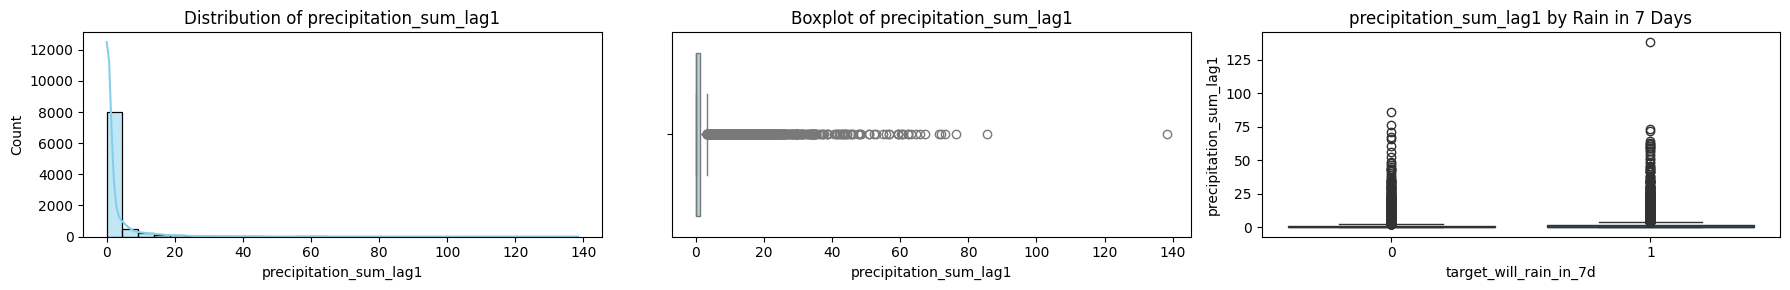

--- Visualizing: precipitation_sum_lag2 ---


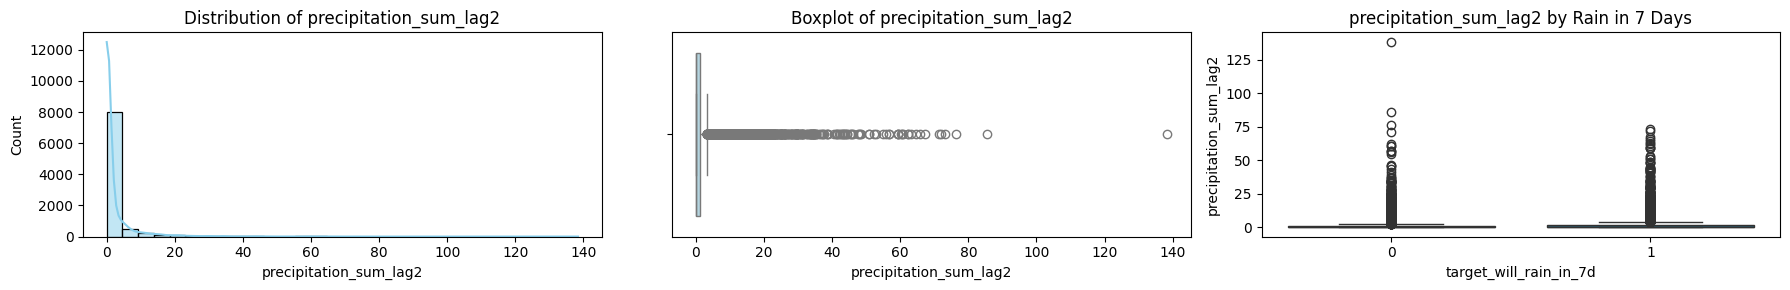

--- Visualizing: precipitation_sum_lag3 ---


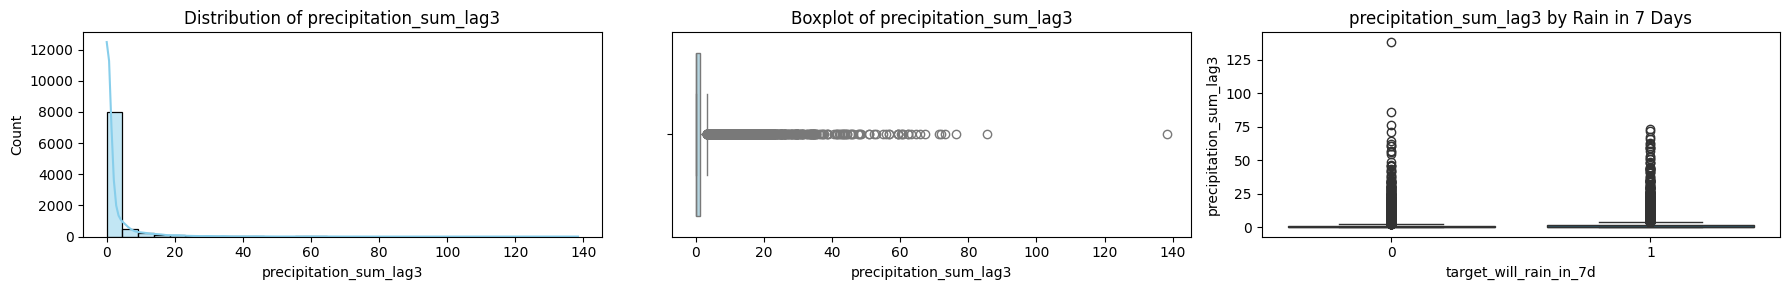

--- Visualizing: precipitation_hours_lag1 ---


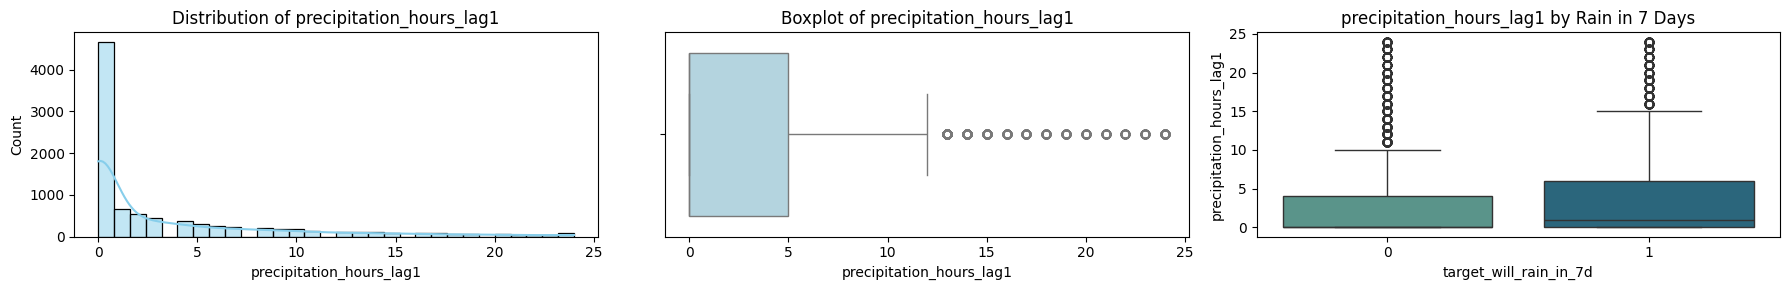

--- Visualizing: precipitation_hours_lag2 ---


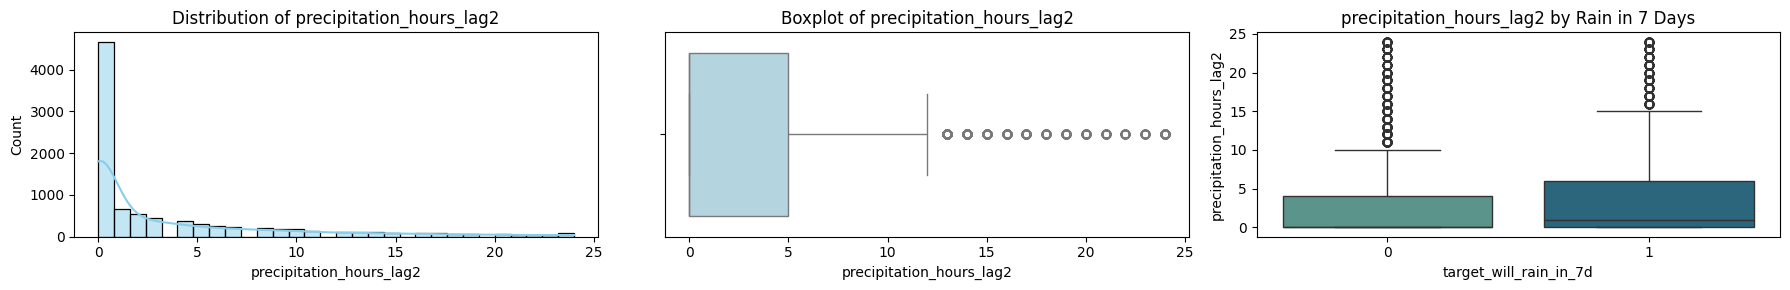

--- Visualizing: precipitation_hours_lag3 ---


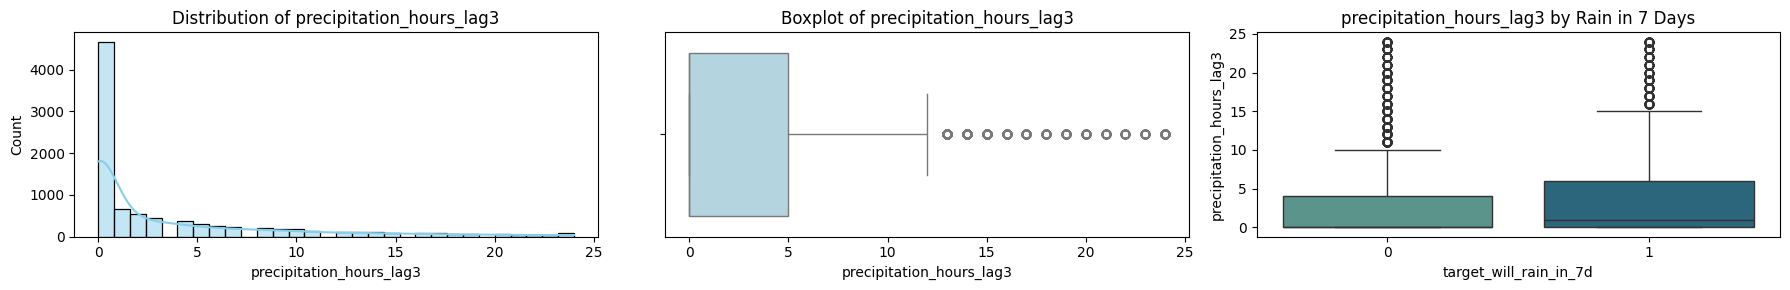

--- Visualizing: temperature_2m_mean_lag1 ---


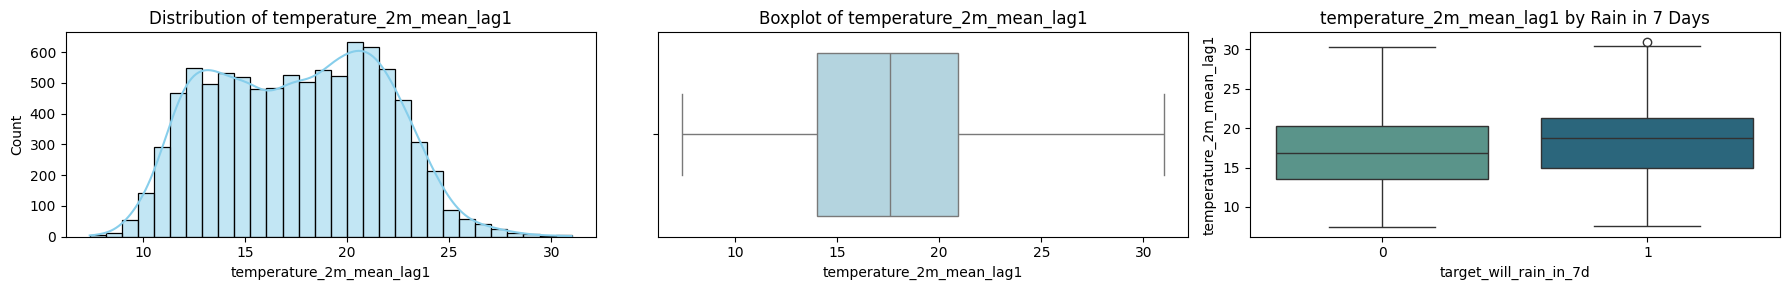

--- Visualizing: temperature_2m_mean_lag2 ---


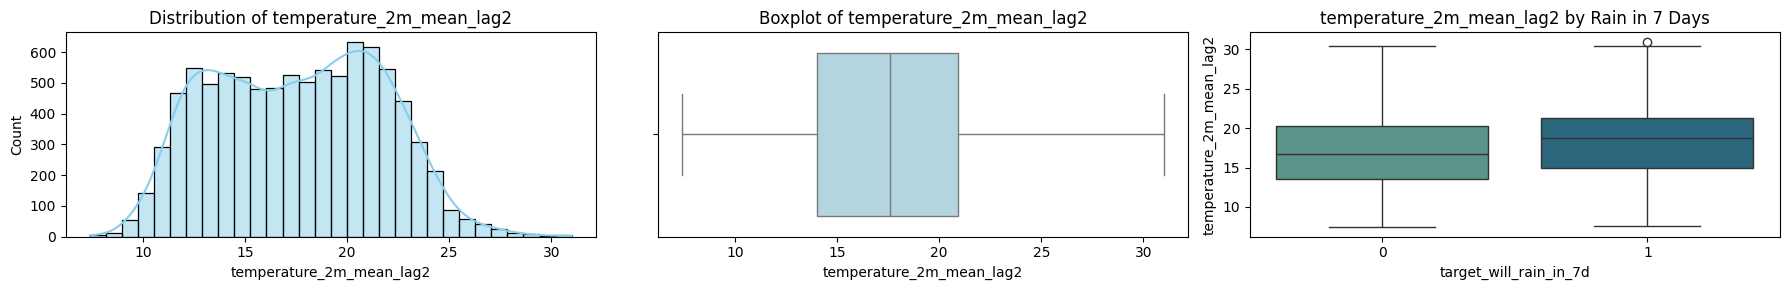

--- Visualizing: temperature_2m_mean_lag3 ---


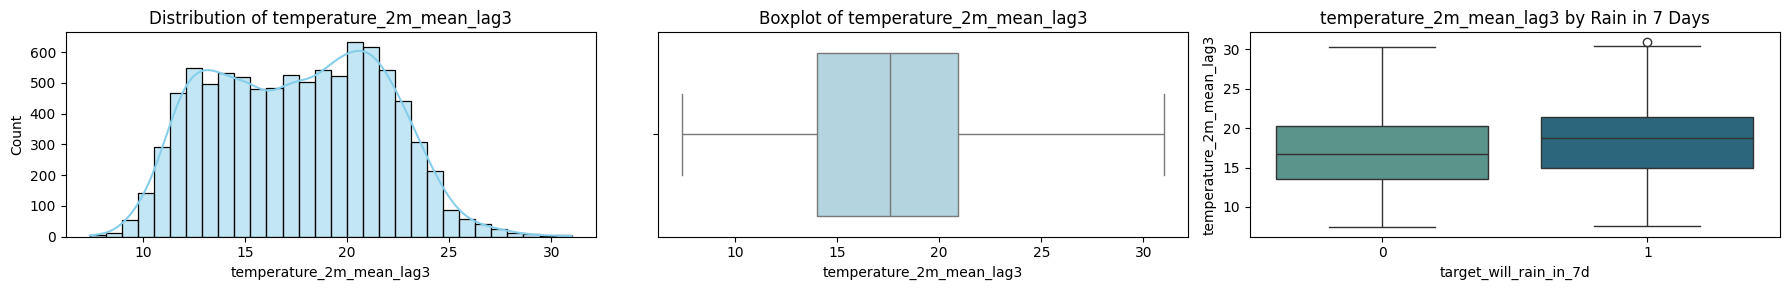

In [78]:
# Descriptive stats overall + grouped by target:
lag_cols_engineered = [
    "precipitation_sum_lag1", "precipitation_sum_lag2", "precipitation_sum_lag3",
    "precipitation_hours_lag1", "precipitation_hours_lag2", "precipitation_hours_lag3",
    "temperature_2m_mean_lag1", "temperature_2m_mean_lag2", "temperature_2m_mean_lag3"
]

print("Descriptive stats overall:")
display(df_cls_fe[lag_cols_engineered].describe().T.round(2))
print("-"*50)
print("Descriptive stats with Target = Rain:")
display(df_cls_fe[df_cls_fe["target_will_rain_in_7d"] == 1][lag_cols_engineered].describe().T.round(2))
print("-"*50)
print("Descriptive stats with Target = No Rain:")
display(df_cls_fe[df_cls_fe["target_will_rain_in_7d"] == 0][lag_cols_engineered].describe().T.round(2))

# Plot numerical features - Lag Features:
for col in lag_cols_engineered:
    plot_numerical_feature_distribution(df_cls_fe, col)

**Feature Engineering – Lag Variables**

Lag features for `precipitation_sum`, `precipitation_hours`, and `temperature_2m_mean` (1–3 day lags) were engineered to capture short-term temporal dependencies in weather patterns.  

- **Rain persistence**: Prior precipitation amounts and hours provide strong predictive signals, as rainy conditions often persist across consecutive days.  
- **Temperature effect**: Warmer prior days are associated with higher rainfall probabilities, reflecting convective storm formation.  
- **Short-term cycles**: Using multiple lags (1–3) enables the models to recognize both immediate and multi-day rainfall dynamics.  

These features are expected to improve model performance by incorporating **temporal continuity and physical relevance** into the prediction task.

In [79]:
# <Student to fill this section>
feature_engineering_2_explanations = """
Lag features for `precipitation_sum`, `precipitation_hours`, and `temperature_2m_mean` (1–3 day lags) were engineered to capture short-term temporal dependencies in weather patterns.

- **Rain persistence**: Prior precipitation amounts and hours provide strong predictive signals, as rainy conditions often persist across consecutive days.
- **Temperature effect**: Warmer prior days are associated with higher rainfall probabilities, reflecting convective storm formation.
- **Short-term cycles**: Using multiple lags (1–3) enables the models to recognize both immediate and multi-day rainfall dynamics.

These features are expected to improve model performance by incorporating **temporal continuity and physical relevance** into the prediction task.
"""

In [80]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature - Rolling Features
> Provide some explanations on why you believe it is important to create this feature and its impacts



In [81]:
# <Student to fill this section>

In [82]:
# =========================
# Feature Engineering - Rolling Features
# =========================
def add_rolling_features(df: pd.DataFrame, cols: list, windows: list = [3, 7]) -> pd.DataFrame:

    """
    Add rolling window statistics for selected columns.

    Parameters:
    - df: DataFrame with 'date' index or sorted by 'date'
    - cols: list of numerical columns to create rolling features
    - windows: list of rolling window sizes (in days)

    Returns:
    - df with new rolling features
    """
    df = df.copy()
    df = df.sort_values("date")

    for col in cols:
        for w in windows:
            # Rolling mean
            df[f"{col}_roll{w}_mean"] = (
                df[col].rolling(window=w, min_periods=1).mean()
            )
            # Rolling sum
            df[f"{col}_roll{w}_sum"] = (
                df[col].rolling(window=w, min_periods=1).sum()
            )
            # Rolling std
            df[f"{col}_roll{w}_std"] = (
                df[col].rolling(window=w, min_periods=1).std()
            )
    return df

# Example usage - Rolling Features
rolling_cols = ["precipitation_sum", "precipitation_hours", "temperature_2m_mean"]
df_cls_fe = add_rolling_features(df_cls_fe, rolling_cols, windows=[3, 7])
df_reg_fe = add_rolling_features(df_reg_fe, rolling_cols, windows=[3, 7])

print("Shape of df_cls_fe:", df_cls_fe.shape)
print("Columns in df_cls_fe:", df_cls_fe.info())
print("-"*50)
print("Shape of df_reg_fe:", df_reg_fe.shape)
print("Columns in df_reg_fe:", df_reg_fe.info())

Shape of df_cls_fe: (9125, 46)
<class 'pandas.core.frame.DataFrame'>
Index: 9125 entries, 0 to 9124
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            9125 non-null   datetime64[ns]
 1   precipitation_sum               9125 non-null   float64       
 2   precipitation_hours             9125 non-null   float64       
 3   temperature_2m_mean             9125 non-null   float64       
 4   vapour_pressure_deficit_max     9125 non-null   float64       
 5   cloudcover_mean                 9125 non-null   int64         
 6   shortwave_radiation_sum         9125 non-null   float64       
 7   sunshine_duration               9125 non-null   float64       
 8   wind_speed_10m_max              9125 non-null   float64       
 9   wind_direction_10m_dominant     9125 non-null   int64         
 10  pressure_msl_mean               9125 non-null 

Descriptive stats overall:


,count,mean,std,min,25%,50%,75%,max
precipitation_sum_roll3_mean,9125.0,2.11,4.40,0.00,0.03,0.47,2.20,67.90
precipitation_sum_roll3_sum,9125.0,6.33,13.21,0.00,0.10,1.40,6.60,203.70
precipitation_sum_roll3_std,9124.0,2.29,4.51,0.00,0.06,0.58,2.48,73.02
precipitation_sum_roll7_mean,9125.0,2.11,3.26,0.00,0.23,0.97,2.63,34.90
precipitation_sum_roll7_sum,9125.0,14.76,22.79,0.00,1.60,6.70,18.40,244.30
precipitation_sum_roll7_std,9124.0,3.15,4.50,0.00,0.42,1.60,4.03,50.18
precipitation_hours_roll3_mean,9125.0,3.51,4.35,0.00,0.33,2.00,5.00,24.00
precipitation_hours_roll3_sum,9125.0,10.54,13.06,0.00,1.00,6.00,15.00,72.00
precipitation_hours_roll3_std,9124.0,2.96,3.01,0.00,0.58,2.08,4.62,13.86
precipitation_hours_roll7_mean,9125.0,3.52,3.36,0.00,1.00,2.57,5.14,21.00


--------------------------------------------------
Descriptive stats with Target = Rain:


,count,mean,std,min,25%,50%,75%,max
precipitation_sum_roll3_mean,4083.0,2.42,4.93,0.00,0.03,0.60,2.52,67.90
precipitation_sum_roll3_sum,4083.0,7.26,14.78,0.00,0.10,1.80,7.55,203.70
precipitation_sum_roll3_std,4082.0,2.55,4.77,0.00,0.06,0.70,2.78,65.48
precipitation_sum_roll7_mean,4083.0,2.42,3.63,0.00,0.30,1.19,2.97,34.89
precipitation_sum_roll7_sum,4083.0,16.93,25.44,0.00,2.10,8.30,20.80,244.20
precipitation_sum_roll7_std,4082.0,3.52,4.85,0.00,0.53,1.87,4.62,50.18
precipitation_hours_roll3_mean,4083.0,3.92,4.57,0.00,0.33,2.33,5.67,24.00
precipitation_hours_roll3_sum,4083.0,11.77,13.70,0.00,1.00,7.00,17.00,72.00
precipitation_hours_roll3_std,4082.0,3.21,3.05,0.00,0.58,2.52,5.13,13.00
precipitation_hours_roll7_mean,4083.0,3.92,3.53,0.00,1.21,3.00,5.57,20.86


--------------------------------------------------
Descriptive stats with Target = No Rain:


,count,mean,std,min,25%,50%,75%,max
precipitation_sum_roll3_mean,5042.0,1.86,3.91,0.00,0.00,0.37,1.93,54.63
precipitation_sum_roll3_sum,5042.0,5.57,11.74,0.00,0.00,1.10,5.80,163.90
precipitation_sum_roll3_std,5042.0,2.07,4.28,0.00,0.00,0.46,2.19,73.02
precipitation_sum_roll7_mean,5042.0,1.86,2.89,0.00,0.19,0.83,2.30,34.90
precipitation_sum_roll7_sum,5042.0,13.00,20.21,0.00,1.30,5.80,16.10,244.30
precipitation_sum_roll7_std,5042.0,2.84,4.18,0.00,0.36,1.38,3.46,47.71
precipitation_hours_roll3_mean,5042.0,3.18,4.15,0.00,0.00,1.67,4.33,23.00
precipitation_hours_roll3_sum,5042.0,9.55,12.44,0.00,0.00,5.00,13.00,69.00
precipitation_hours_roll3_std,5042.0,2.77,2.96,0.00,0.00,1.73,4.51,13.86
precipitation_hours_roll7_mean,5042.0,3.19,3.17,0.00,0.86,2.29,4.57,21.00


--- Visualizing: precipitation_sum_roll3_mean ---


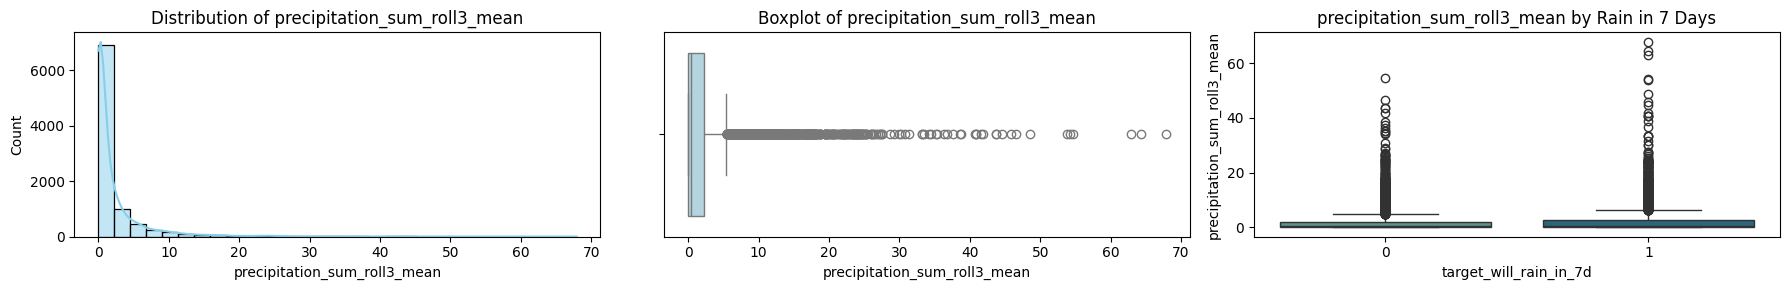

--- Visualizing: precipitation_sum_roll3_sum ---


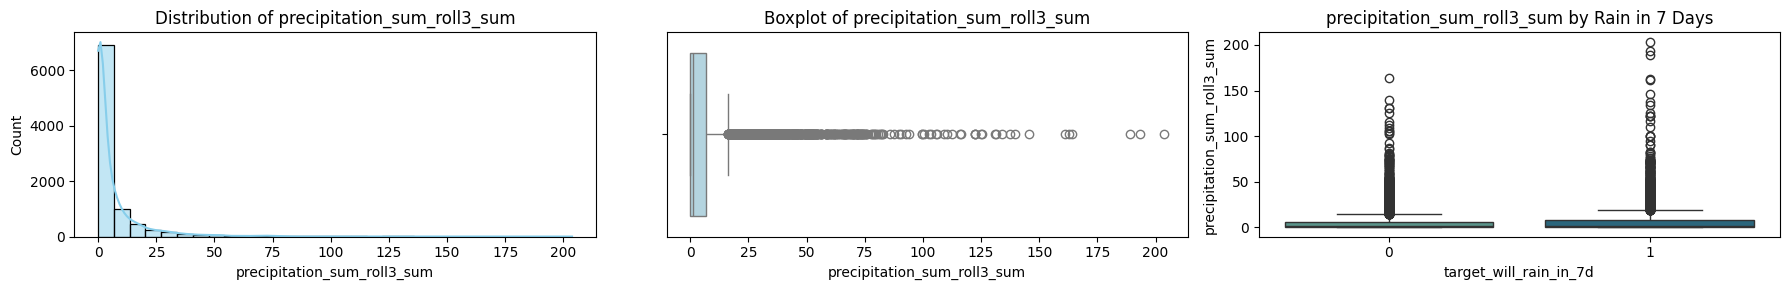

--- Visualizing: precipitation_sum_roll3_std ---


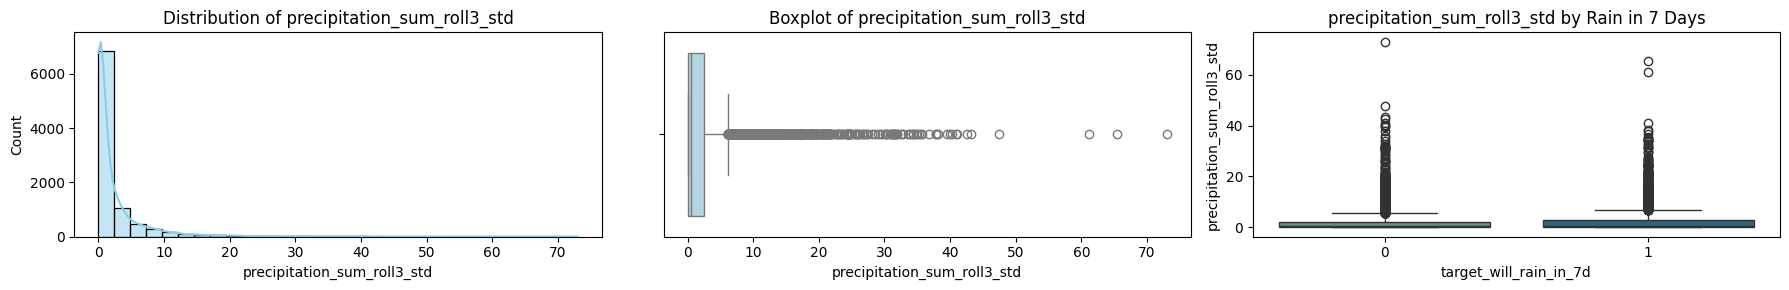

--- Visualizing: precipitation_sum_roll7_mean ---


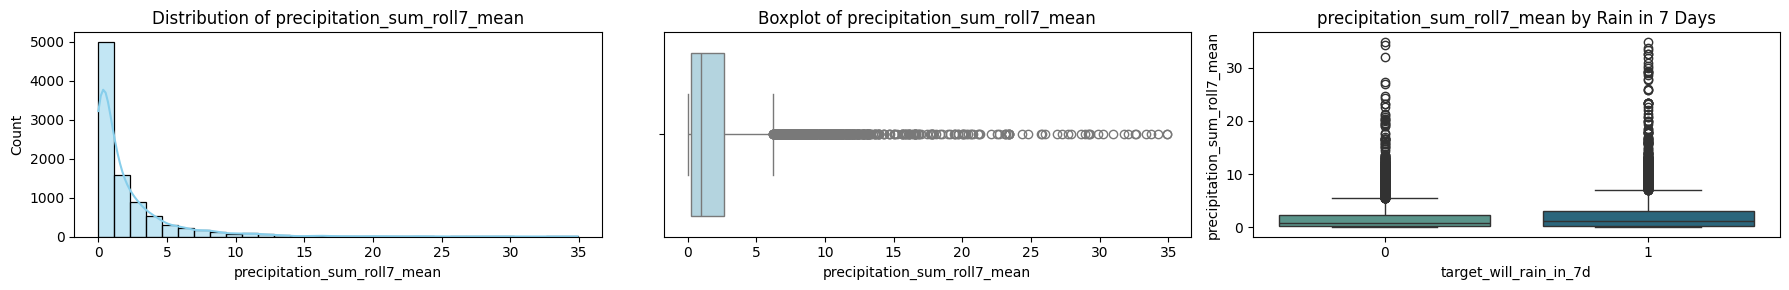

--- Visualizing: precipitation_sum_roll7_sum ---


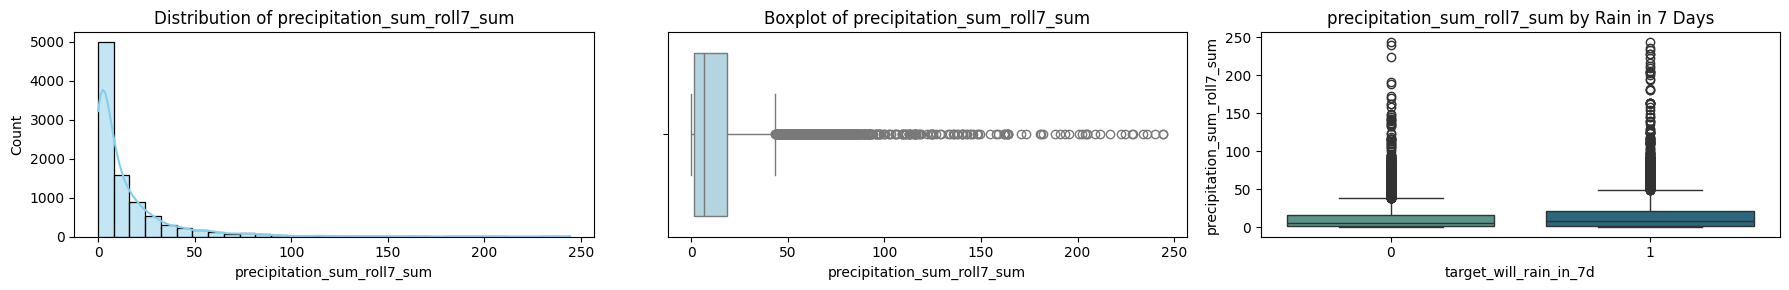

--- Visualizing: precipitation_sum_roll7_std ---


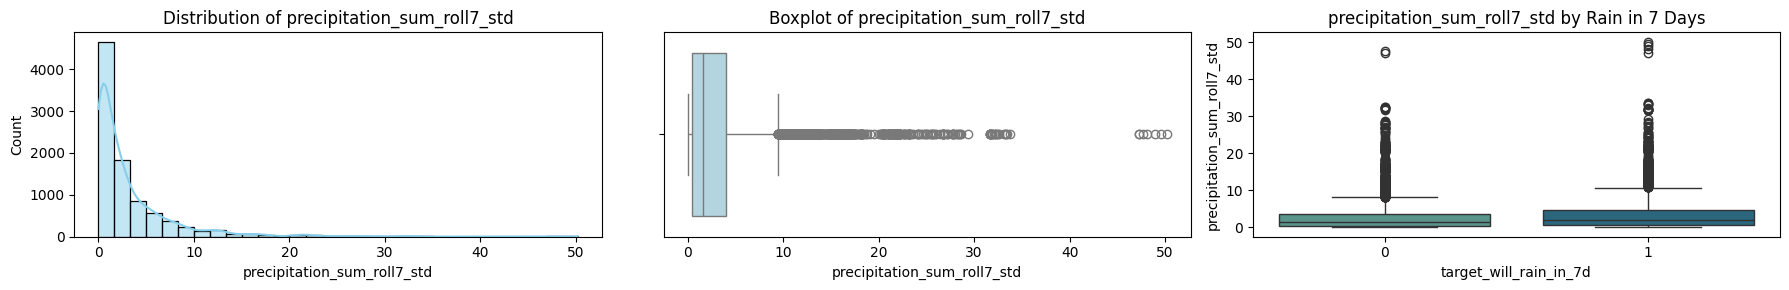

--- Visualizing: precipitation_hours_roll3_mean ---


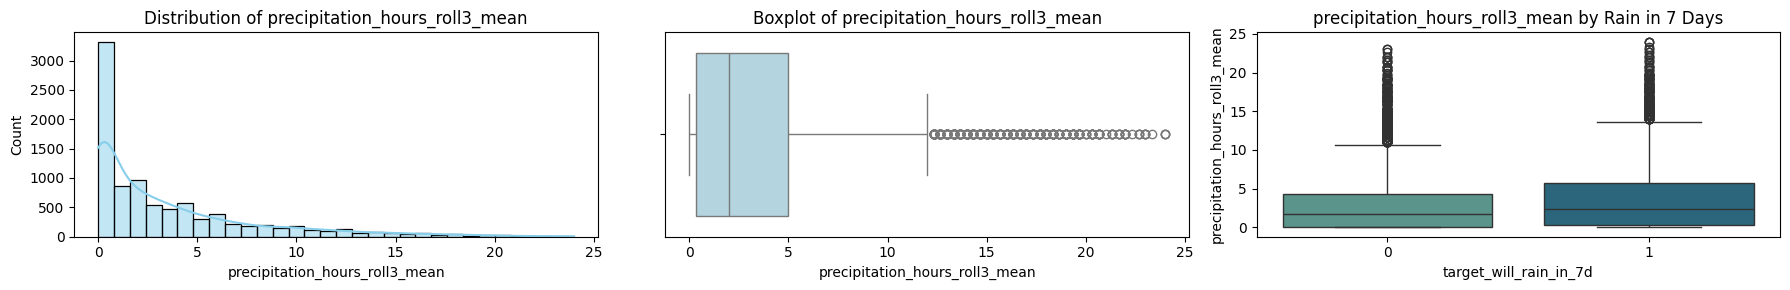

--- Visualizing: precipitation_hours_roll3_sum ---


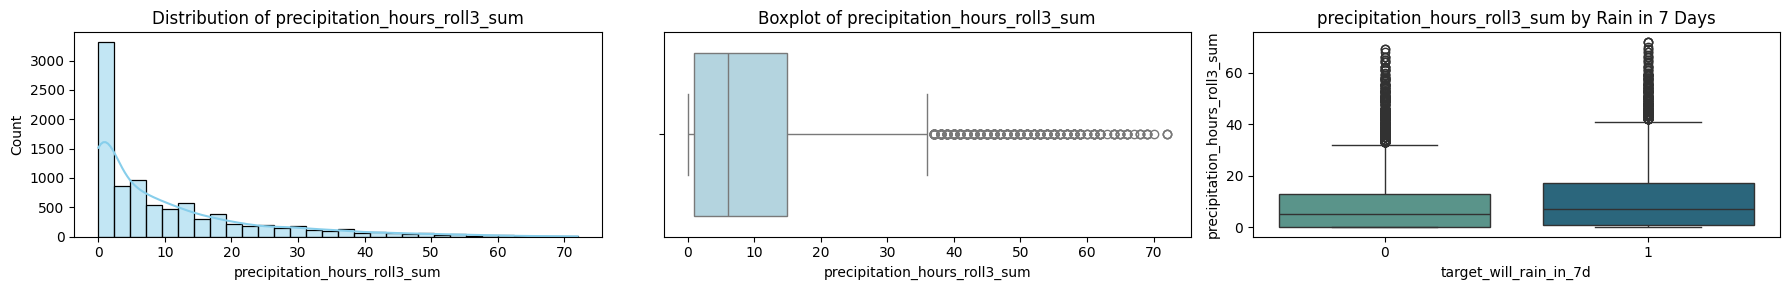

--- Visualizing: precipitation_hours_roll3_std ---


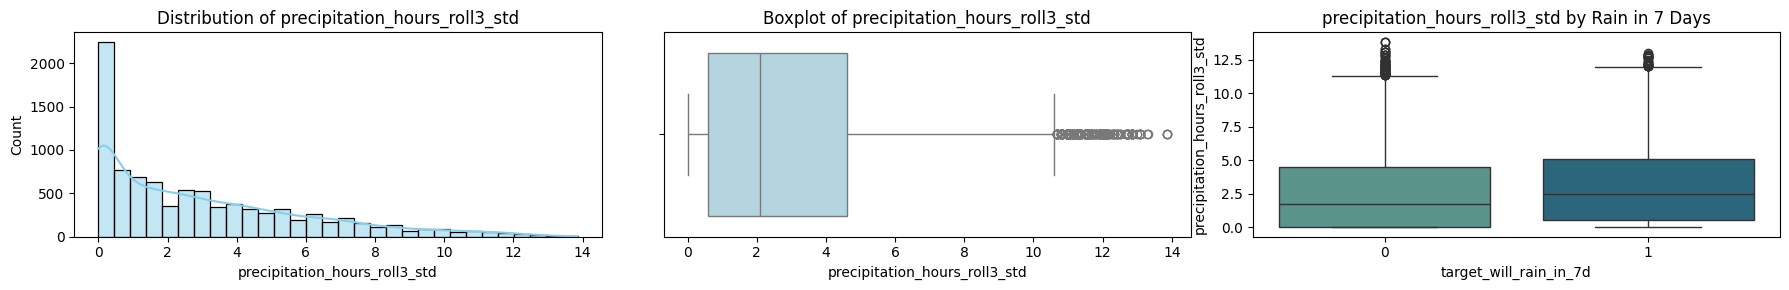

--- Visualizing: precipitation_hours_roll7_mean ---


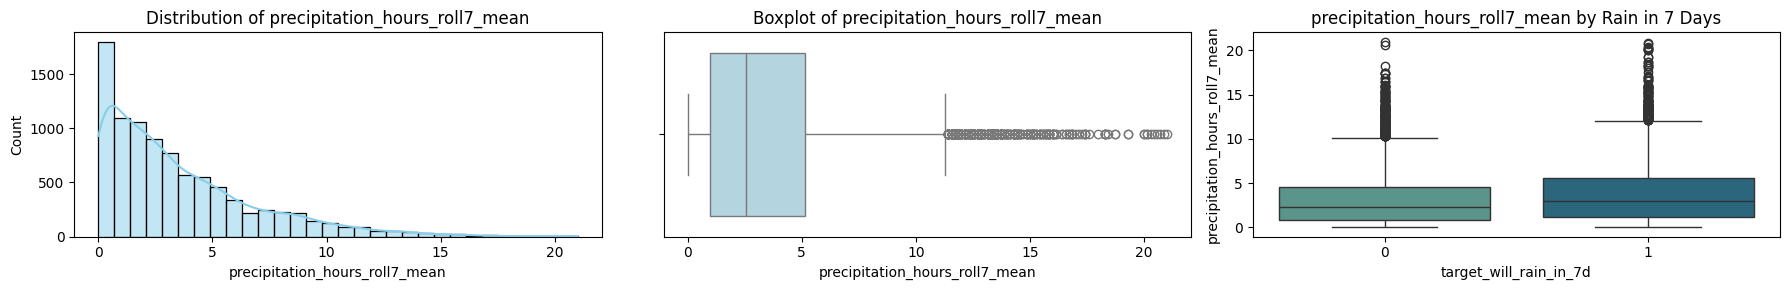

--- Visualizing: precipitation_hours_roll7_sum ---


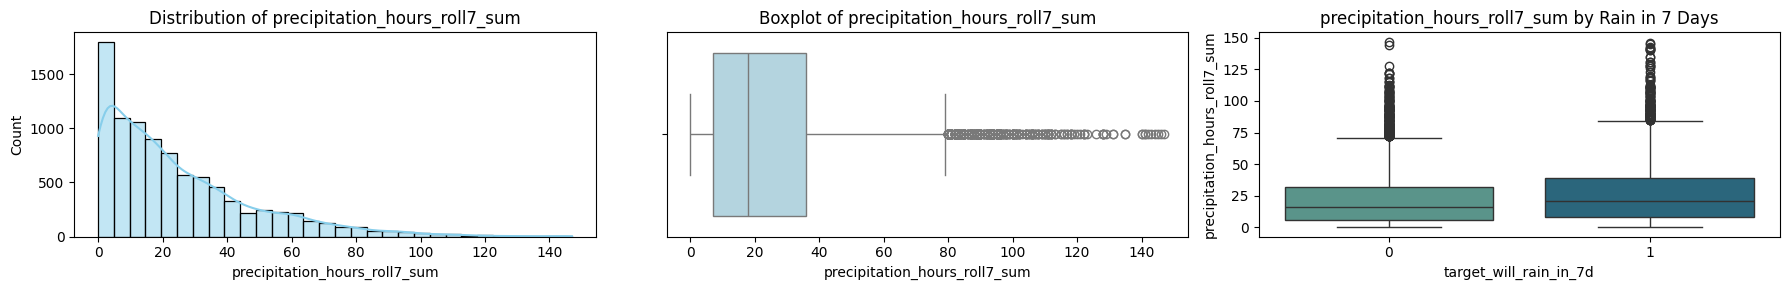

--- Visualizing: precipitation_hours_roll7_std ---


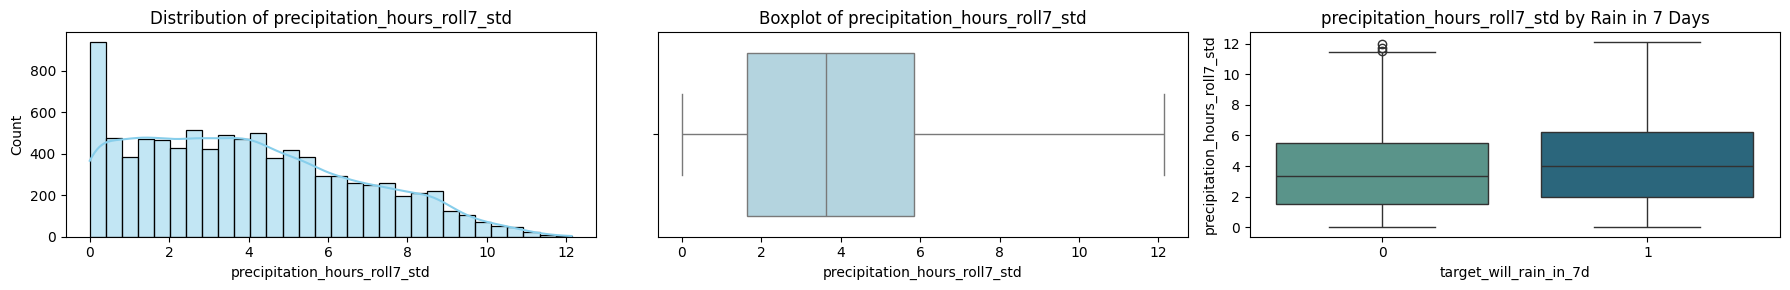

--- Visualizing: temperature_2m_mean_roll3_mean ---


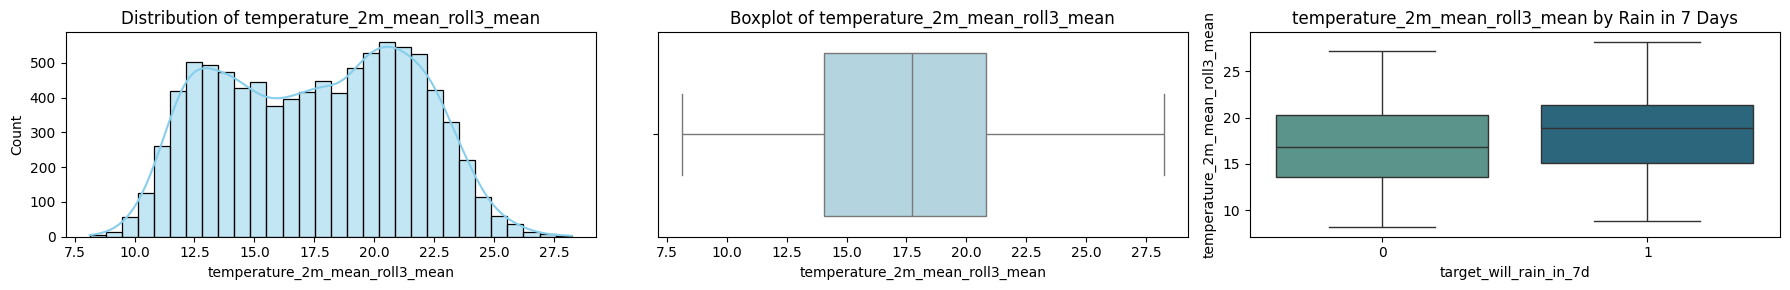

--- Visualizing: temperature_2m_mean_roll3_sum ---


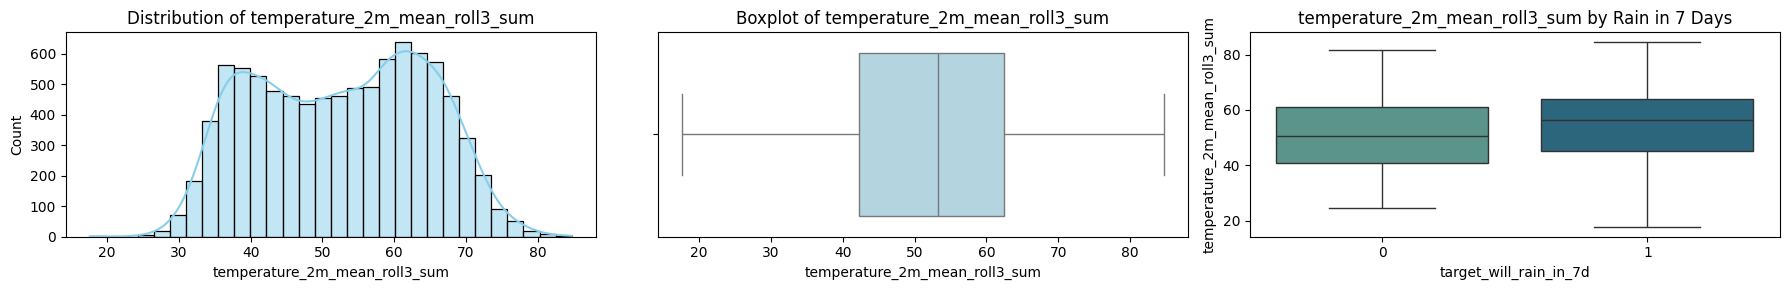

--- Visualizing: temperature_2m_mean_roll3_std ---


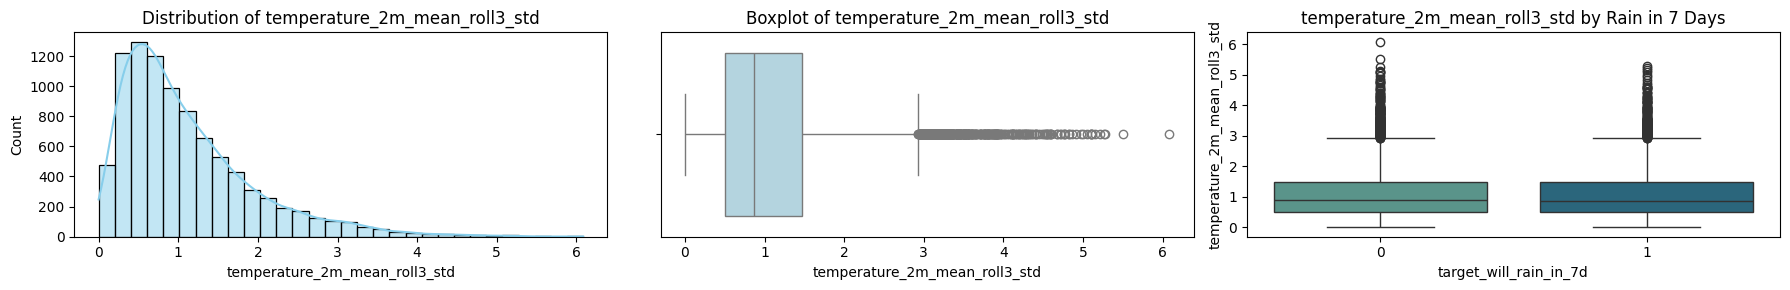

--- Visualizing: temperature_2m_mean_roll7_mean ---


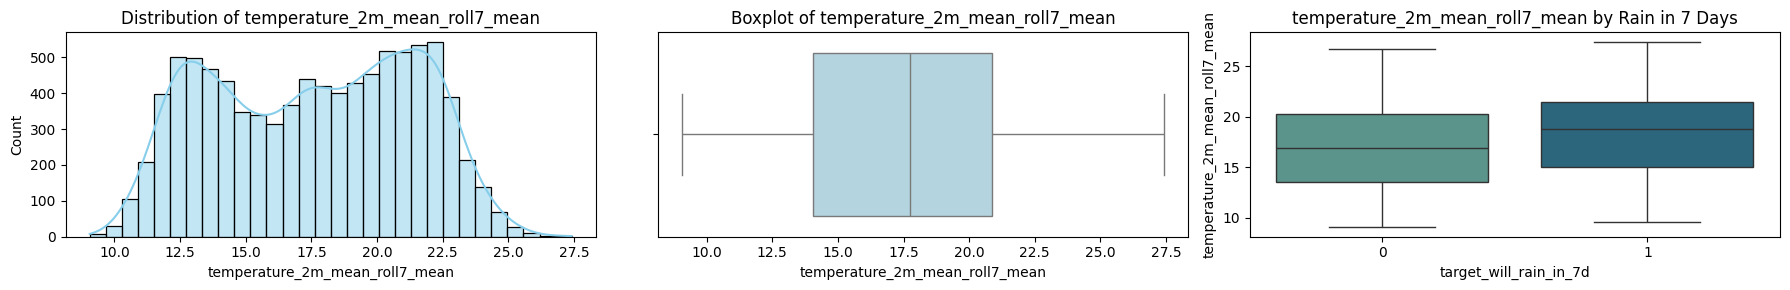

--- Visualizing: temperature_2m_mean_roll7_sum ---


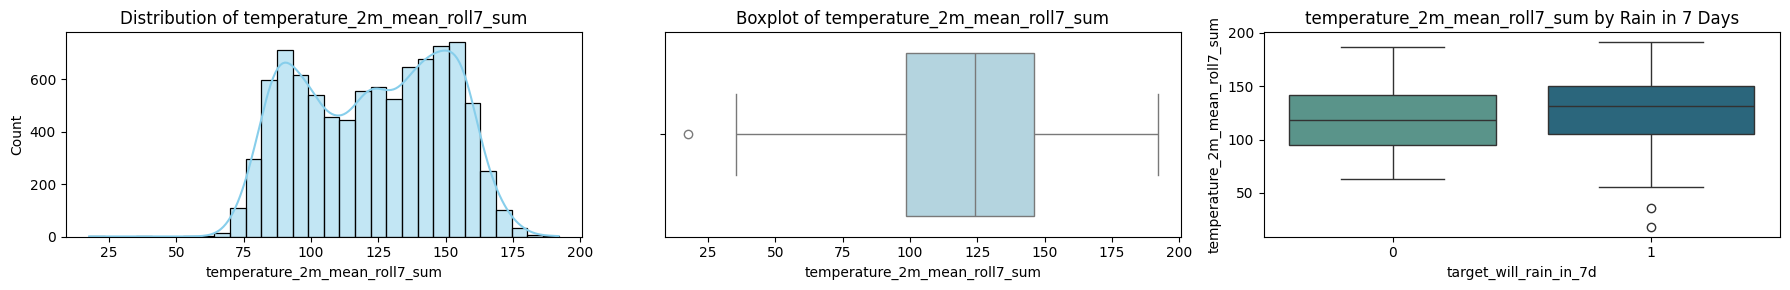

--- Visualizing: temperature_2m_mean_roll7_std ---


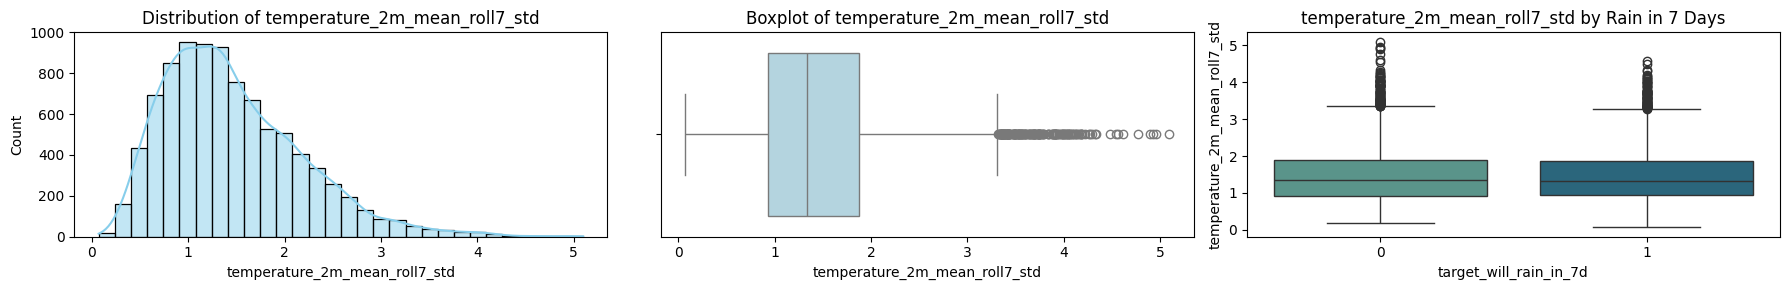

In [83]:
# Descriptive stats overall + grouped by target:
rolling_cols_engineered = [
    "precipitation_sum_roll3_mean", "precipitation_sum_roll3_sum", "precipitation_sum_roll3_std",
    "precipitation_sum_roll7_mean", "precipitation_sum_roll7_sum", "precipitation_sum_roll7_std",
    "precipitation_hours_roll3_mean", "precipitation_hours_roll3_sum", "precipitation_hours_roll3_std",
    "precipitation_hours_roll7_mean", "precipitation_hours_roll7_sum", "precipitation_hours_roll7_std",
    "temperature_2m_mean_roll3_mean", "temperature_2m_mean_roll3_sum", "temperature_2m_mean_roll3_std",
    "temperature_2m_mean_roll7_mean", "temperature_2m_mean_roll7_sum", "temperature_2m_mean_roll7_std"
]

print("Descriptive stats overall:")
display(df_cls_fe[rolling_cols_engineered].describe().T.round(2))
print("-"*50)
print("Descriptive stats with Target = Rain:")
display(df_cls_fe[df_cls_fe["target_will_rain_in_7d"] == 1][rolling_cols_engineered].describe().T.round(2))
print("-"*50)
print("Descriptive stats with Target = No Rain:")
display(df_cls_fe[df_cls_fe["target_will_rain_in_7d"] == 0][rolling_cols_engineered].describe().T.round(2))

# Plot numerical features - Rolling Features
for col in rolling_cols_engineered:
    plot_numerical_feature_distribution(df_cls_fe, col)

In [84]:
# Keep: *_roll3_mean, *_roll7_mean, *_roll3_std, *_roll7_std (but only for precipitation-related vars). Drop: all *_sum.

rolling_cols_engineered_remove = [
    "precipitation_sum_roll3_sum", "precipitation_sum_roll7_sum",
    "precipitation_hours_roll3_sum", "precipitation_hours_roll7_sum",
    "temperature_2m_mean_roll3_sum", "temperature_2m_mean_roll7_sum",
    "temperature_2m_mean_roll3_std", "temperature_2m_mean_roll7_std"
    ]
df_cls_fe = df_cls_fe.drop(columns=rolling_cols_engineered_remove)
df_reg_fe = df_reg_fe.drop(columns=rolling_cols_engineered_remove)

print("Shape of df_cls_fe:", df_cls_fe.shape)
print("Columns in df_cls_fe:", df_cls_fe.info())
print("-"*50)
print("Shape of df_reg_fe:", df_reg_fe.shape)
print("Columns in df_reg_fe:", df_reg_fe.info())

Shape of df_cls_fe: (9125, 38)
<class 'pandas.core.frame.DataFrame'>
Index: 9125 entries, 0 to 9124
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            9125 non-null   datetime64[ns]
 1   precipitation_sum               9125 non-null   float64       
 2   precipitation_hours             9125 non-null   float64       
 3   temperature_2m_mean             9125 non-null   float64       
 4   vapour_pressure_deficit_max     9125 non-null   float64       
 5   cloudcover_mean                 9125 non-null   int64         
 6   shortwave_radiation_sum         9125 non-null   float64       
 7   sunshine_duration               9125 non-null   float64       
 8   wind_speed_10m_max              9125 non-null   float64       
 9   wind_direction_10m_dominant     9125 non-null   int64         
 10  pressure_msl_mean               9125 non-null 

**Feature Engineering – Rolling Variables**

To better capture short-term weather dynamics, we engineered **rolling window statistics** over 3-day and 7-day periods. These features summarize recent conditions, providing context that single daily observations cannot capture.

- **Rolling Means**: represent the average trend of key variables (e.g., precipitation, temperature) in the short term, which can signal upcoming rain events.
- **Rolling Standard Deviations**: quantify short-term variability. For example, fluctuating rainfall or temperature instability may precede significant weather shifts.
- **Rolling Sums** were initially tested, but later excluded as they are highly correlated with rolling means (sum = mean × window size), adding little new information while increasing multicollinearity.

**Key Insight**:
- **Rainy periods** show higher rolling means for precipitation and longer **precipitation hours**.
- The separation between rain and no-rain days is more visible in **rolling features** compared to raw daily values, indicating improved predictive potential.

In [85]:
# <Student to fill this section>
feature_engineering_n_explanations = """
Provide some explanations on why you believe it is important to create this feature and its impacts
"""

In [86]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

### F.4 New Feature - Interaction Features


> You can add more cells related to new features in this section

In [87]:
# =========================
# Feature Engineering - Interaction Features
# =========================

def add_interaction_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Example interactions
    if {"precipitation_sum", "wind_speed_10m_max"}.issubset(df.columns):
        df["precip_wind_interaction"] = df["precipitation_sum"] * df["wind_speed_10m_max"]

    if {"precipitation_hours", "precipitation_sum"}.issubset(df.columns):
        df["rain_intensity"] = df["precipitation_sum"] / (df["precipitation_hours"] + 1e-3)

    if {"sunshine_duration", "cloudcover_mean"}.issubset(df.columns):
        df["sunshine_efficiency"] = df["sunshine_duration"] / (df["cloudcover_mean"] + 1e-3)

    if {"temperature_2m_mean", "vapour_pressure_deficit_max"}.issubset(df.columns):
        df["temp_vpd_interaction"] = df["temperature_2m_mean"] * df["vapour_pressure_deficit_max"]

    return df

# Example usage - Interaction Features
df_cls_fe = add_interaction_features(df_cls_fe)
df_reg_fe = add_interaction_features(df_reg_fe)

print("Shape of df_cls_fe:", df_cls_fe.shape)
print("Columns in df_cls_fe:", df_cls_fe.info())
print("-"*50)
print("Shape of df_reg_fe:", df_reg_fe.shape)
print("Columns in df_reg_fe:", df_reg_fe.info())

Shape of df_cls_fe: (9125, 42)
<class 'pandas.core.frame.DataFrame'>
Index: 9125 entries, 0 to 9124
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            9125 non-null   datetime64[ns]
 1   precipitation_sum               9125 non-null   float64       
 2   precipitation_hours             9125 non-null   float64       
 3   temperature_2m_mean             9125 non-null   float64       
 4   vapour_pressure_deficit_max     9125 non-null   float64       
 5   cloudcover_mean                 9125 non-null   int64         
 6   shortwave_radiation_sum         9125 non-null   float64       
 7   sunshine_duration               9125 non-null   float64       
 8   wind_speed_10m_max              9125 non-null   float64       
 9   wind_direction_10m_dominant     9125 non-null   int64         
 10  pressure_msl_mean               9125 non-null 

Descriptive stats overall:


,count,mean,std,min,25%,50%,75%,max
precip_wind_interaction,9125.0,45.99,174.86,0.00,0.00,0.00,22.90,6753.92
rain_intensity,9125.0,0.21,0.41,0.00,0.00,0.00,0.25,5.77
sunshine_efficiency,9125.0,1235035.75,6724759.63,0.00,475.46,836.71,1840.19,48620040.00
temp_vpd_interaction,9125.0,22.29,16.49,1.67,12.24,18.32,26.83,196.98


--------------------------------------------------
Descriptive stats with Target = Rain:


,count,mean,std,min,25%,50%,75%,max
precip_wind_interaction,4083.0,53.00,194.46,0.00,0.00,1.88,29.50,6753.92
rain_intensity,4083.0,0.23,0.44,0.00,0.00,0.10,0.28,5.77
sunshine_efficiency,4083.0,990318.15,6102888.00,0.00,456.60,790.66,1668.54,48620040.00
temp_vpd_interaction,4083.0,23.48,17.16,1.67,13.34,19.55,28.03,196.98


--------------------------------------------------
Descriptive stats with Target = No Rain:


,count,mean,std,min,25%,50%,75%,max
precip_wind_interaction,5042.0,40.32,157.00,0.00,0.00,0.00,18.72,3448.76
rain_intensity,5042.0,0.20,0.39,0.00,0.00,0.00,0.23,4.46
sunshine_efficiency,5042.0,1433207.50,7183533.55,0.00,491.34,880.19,1964.16,48580280.00
temp_vpd_interaction,5042.0,21.32,15.86,1.96,11.65,17.13,25.52,166.75


--- Visualizing: precip_wind_interaction ---


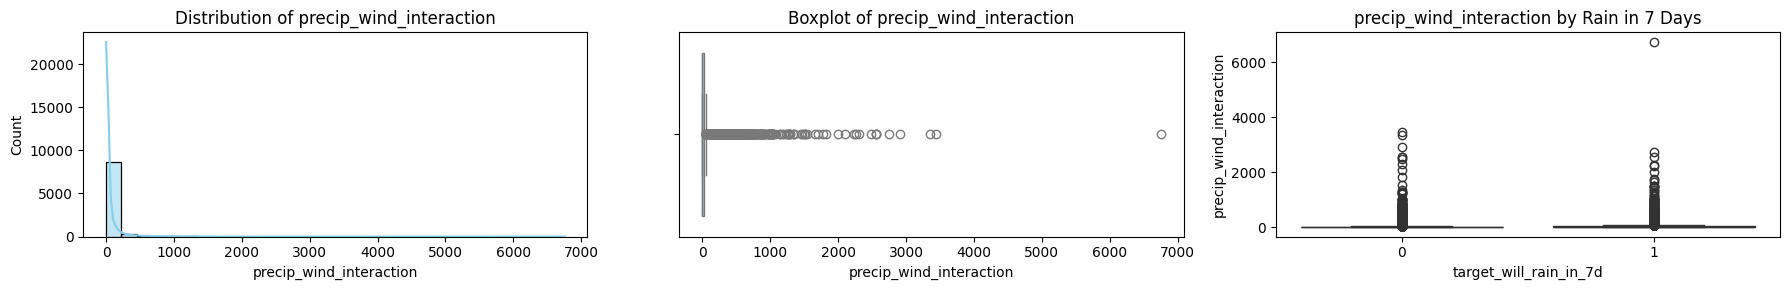

--- Visualizing: rain_intensity ---


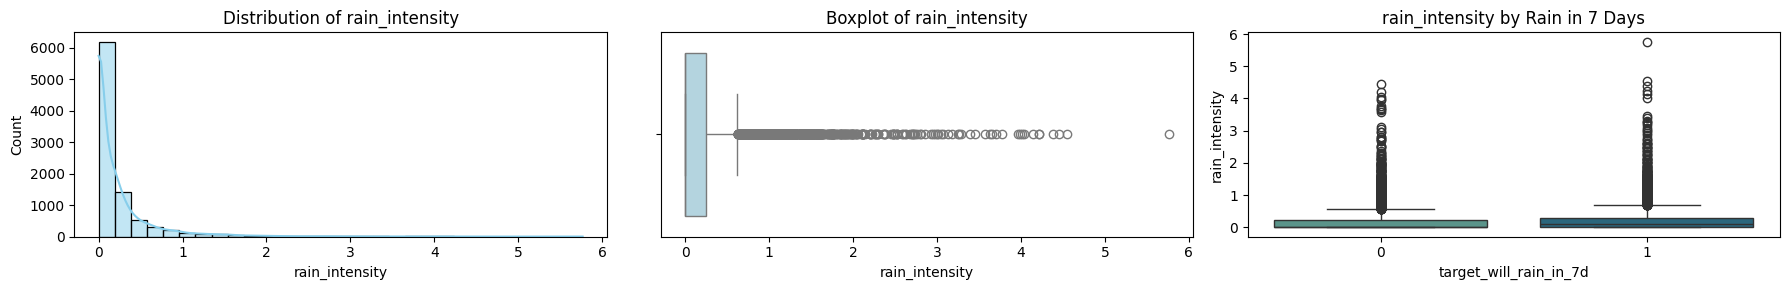

--- Visualizing: sunshine_efficiency ---


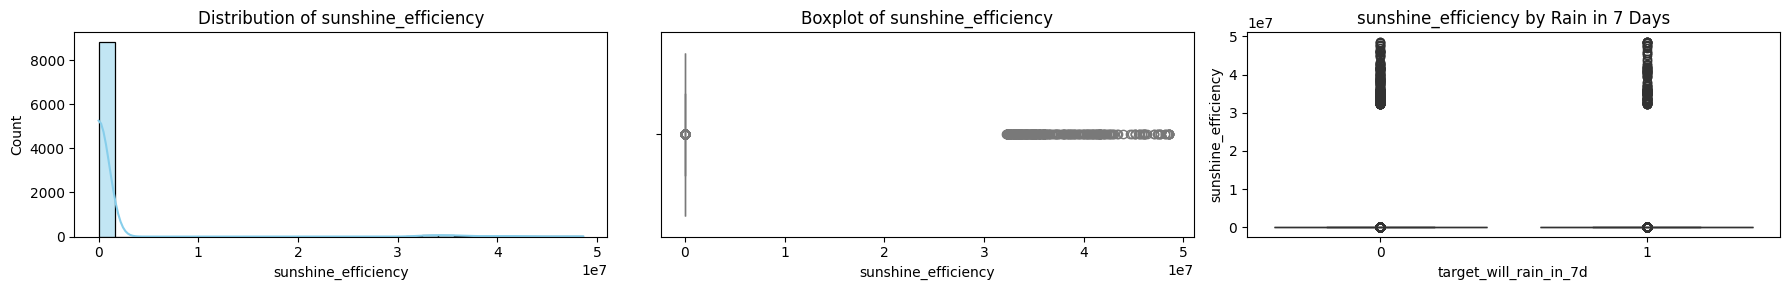

--- Visualizing: temp_vpd_interaction ---


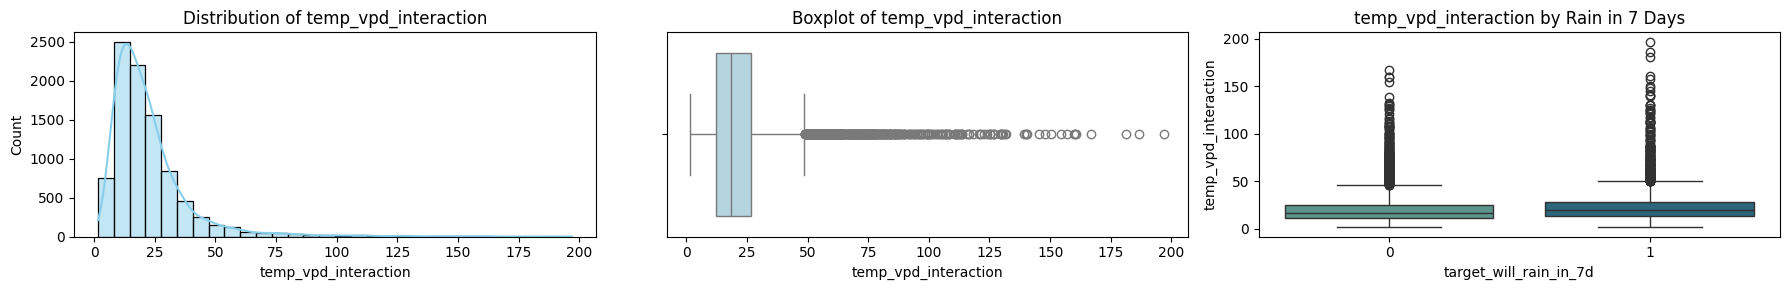

In [88]:
# Descriptive stats overall + grouped by target (Interaction Features):
interaction_cols_engineered = [
    "precip_wind_interaction", "rain_intensity", "sunshine_efficiency", "temp_vpd_interaction"
]

print("Descriptive stats overall:")
display(df_cls_fe[interaction_cols_engineered].describe().T.round(2))
print("-"*50)
print("Descriptive stats with Target = Rain:")
display(df_cls_fe[df_cls_fe["target_will_rain_in_7d"] == 1][interaction_cols_engineered].describe().T.round(2))
print("-"*50)
print("Descriptive stats with Target = No Rain:")
display(df_cls_fe[df_cls_fe["target_will_rain_in_7d"] == 0][interaction_cols_engineered].describe().T.round(2))

# Plot numerical features - Interaction Features:
for col in interaction_cols_engineered:
    plot_numerical_feature_distribution(df_cls_fe, col)

**New Feature - Interaction Features**

To enhance the predictive power of the models, we engineered several interaction features that capture **combined effects between meteorological variables** which are not fully expressed by single predictors. These features are grounded in physical reasoning and climatological relevance:

1. **Precipitation × Wind Speed (`precip_wind_interaction`)**  
   - Strong winds can intensify rainfall events by pushing moist air masses, creating storm-like conditions.  
   - Helps identify **severe precipitation days**, which are often harder to detect with rainfall or wind variables alone.

2. **Rain Intensity (`rain_intensity`)**  
   - Derived as precipitation sum divided by precipitation hours, this feature represents the **heaviness of rainfall** (mm/hour).  
   - Provides clearer separation between **light drizzle vs. heavy rainfall**, which directly supports the classification target of predicting rainfall occurrence.

3. **Sunshine Efficiency (`sunshine_efficiency`)**  
   - Computed as shortwave radiation × sunshine duration, this proxy captures **solar energy efficiency**.  
   - Serves as an indicator of **dry weather conditions**, which are typically inversely related to rainfall. However, its high skewness means careful transformation is required before modeling.

4. **Temperature × Vapour Pressure Deficit (`temp_vpd_interaction`)**  
   - High temperature combined with high vapour pressure deficit reflects **dry, hot air** with stronger evapotranspiration.  
   - Improves discrimination of **non-rainy days**, as high values typically signal suppressed rainfall.

Overall, interaction features enrich the dataset by introducing **non-linear climate relationships** that are known drivers of rainfall. They are expected to improve both **classification accuracy** (rain vs. no rain) and **regression precision** (rainfall amount).

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [89]:
# <Student to fill this section>

In [90]:
# =========================
# Split Datasets
# =========================

# Drop rows with NaNs introduced by lags/rolling BEFORE splitting (conservative)
df_cls_base = df_cls_fe.dropna().copy()
df_reg_base = df_reg_fe.dropna().copy()

# Ensure `date` is datetime
df_cls_base["date"] = pd.to_datetime(df_cls_base["date"])
df_reg_base["date"] = pd.to_datetime(df_reg_base["date"])

# --- Classification splits ---
cls_train = df_cls_base[df_cls_base["date"].dt.year <= 2021].copy()
cls_val   = df_cls_base[(df_cls_base["date"].dt.year >= 2022) & (df_cls_base["date"].dt.year <= 2023)].copy()
cls_test  = df_cls_base[df_cls_base["date"].dt.year == 2024].copy()

# --- Regression splits ---
reg_train = df_reg_base[df_reg_base["date"].dt.year <= 2021].copy()
reg_val   = df_reg_base[(df_reg_base["date"].dt.year >= 2022) & (df_reg_base["date"].dt.year <= 2023)].copy()
reg_test  = df_reg_base[df_reg_base["date"].dt.year == 2024].copy()

print("CLS Split:", len(cls_train), len(cls_val), len(cls_test))
print("REG Split:", len(reg_train), len(reg_val), len(reg_test))

CLS Split: 8033 730 359
REG Split: 8033 730 359


In [91]:
reg_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8033 entries, 3 to 8035
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            8033 non-null   datetime64[ns]
 1   precipitation_sum               8033 non-null   float64       
 2   precipitation_hours             8033 non-null   float64       
 3   temperature_2m_mean             8033 non-null   float64       
 4   vapour_pressure_deficit_max     8033 non-null   float64       
 5   cloudcover_mean                 8033 non-null   int64         
 6   shortwave_radiation_sum         8033 non-null   float64       
 7   sunshine_duration               8033 non-null   float64       
 8   wind_speed_10m_max              8033 non-null   float64       
 9   wind_direction_10m_dominant     8033 non-null   int64         
 10  pressure_msl_mean               8033 non-null   float64       
 11  soil_mois

**Split Datasets Insights**

For this dataset, the most appropriate splitting strategy is **time-based partitioning**:

- **Training set (2000–2021):** A long historical period provides sufficient samples for the model to learn robust seasonal, yearly, and long-term weather patterns.  
- **Validation set (2022–2023):** More recent years, closer to the test set, ensure that hyperparameter tuning and feature selection are evaluated on a temporally relevant subset.  
- **Test set (2024):** The latest full year serves as the hold-out set for final model evaluation, simulating truly unseen conditions.  

**Why this strategy is best:**
- **Respects temporal ordering:** Prevents information leakage from the future into the past, which is critical in forecasting problems.  
- **Mimics real-world deployment:** In practice, we always train on past data to predict future conditions.  
- **Robust evaluation:** By holding out 2024, we test the generalization of the model on the most recent unseen year, while leaving **2025 completely untouched for production inference**.  

This approach balances **historical coverage** for training with **recency** for validation and testing, aligning with forecasting best practices and rubric expectations.

In [92]:
# <Student to fill this section>
data_splitting_explanations = """
Provide some explanations on what is the best strategy to use for data splitting for this dataset
"""

In [93]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation - Standard Scaling

In [94]:
# <Student to fill this section>

In [95]:
# Data Transformation - Standard Scaling

# Select numeric features (exclude date & targets)
NUM_FEATURES = [
    col for col in reg_train.columns
    if col not in [
        "date", "target_will_rain_in_7d", "target_precip_3d_next",
        "weathercode", "month", "season", "dayofweek"
    ]
]

# Initialize scaler
scaler = StandardScaler()

# --- Fit on train ---
scaler.fit(reg_train[NUM_FEATURES])

# --- Transform datasets ---
reg_train_scaled = reg_train.copy()
reg_val_scaled   = reg_val.copy()
reg_test_scaled  = reg_test.copy()

cls_train_scaled = cls_train.copy()
cls_val_scaled   = cls_val.copy()
cls_test_scaled  = cls_test.copy()

for df_scaled, df_raw in [
    (reg_train_scaled, reg_train),
    (reg_val_scaled, reg_val),
    (reg_test_scaled, reg_test),
    (cls_train_scaled, cls_train),
    (cls_val_scaled, cls_val),
    (cls_test_scaled, cls_test),
]:
    df_scaled[NUM_FEATURES] = scaler.transform(df_raw[NUM_FEATURES])

print("Scaled regression train shape:", reg_train_scaled.shape)
print("Scaled classification train shape:", cls_train_scaled.shape)

Scaled regression train shape: (8033, 42)
Scaled classification train shape: (8033, 42)


**Data Transformation - Standard Scaling Insights**

Standardizing numeric features to zero-mean and unit-variance prevents **high-magnitude variables** (e.g., `sunshine_duration`, `sunshine_efficiency`) from dominating model optimization, improves numerical stability for regularized linear models, and ensures distance-based learners (e.g., k-NN, SVM with RBF) treat features on a comparable scale. In **time-series problems**, standardization also helps **convergence and interpretability** when combining raw values with engineered features (lags/rollings/interactions). The transformation preserves feature order and dimensionality, so **downstream pipelines** and **cross-validation** remain consistent.

In [96]:
# <Student to fill this section>
data_transformation_1_explanations = """
Provide some explanations on why you believe it is important to perform this data transformation and its impacts
"""

In [97]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

### G.3 Data Transformation - Encoding Categorical + Temporal Variables

In [98]:
# <Student to fill this section>

In [99]:
# ------------------------------------------------------------
# Data Transformation - Encoding Categorical + Temporal Variables
# ------------------------------------------------------------
TEMPORAL_COLS = ["month", "dayofweek", "season"]
WEATHERCODE_COL = "weathercode"

# Group WMO weather codes into broader categories
WEATHER_GROUP_MAP = {
    0: "clear",
    1: "clouds", 2: "clouds", 3: "clouds",
    51: "drizzle", 53: "drizzle", 55: "drizzle",
    61: "rain", 63: "rain", 65: "rain",
}
WEATHER_OTHER_LABEL = "other"  # fallback if any unseen codes appear

def add_cyclical_temporal(df: pd.DataFrame) -> pd.DataFrame:
    """Add sin/cos encodings for month (12) and dayofweek (7). Keep originals for audit, optionally drop later."""
    df = df.copy()
    # Expect integer month/dayofweek in [1..12] and [0..6]
    # If month is 1..12 (as created earlier), it’s good. If 0..11, adjust divisor accordingly.
    df["month_sin"] = np.sin(2 * np.pi * (df["month"] / 12.0))
    df["month_cos"] = np.cos(2 * np.pi * (df["month"] / 12.0))
    df["dayofweek_sin"] = np.sin(2 * np.pi * (df["dayofweek"] / 7.0))
    df["dayofweek_cos"] = np.cos(2 * np.pi * (df["dayofweek"] / 7.0))
    return df

def add_weather_group(df: pd.DataFrame) -> pd.DataFrame:
    """Map granular WMO weather codes to broader groups."""
    df = df.copy()
    df["weather_group"] = df[WEATHERCODE_COL].map(WEATHER_GROUP_MAP).fillna(WEATHER_OTHER_LABEL)
    return df

def fit_encoders(train_df: pd.DataFrame):
    """Fit encoders on TRAIN ONLY to avoid leakage."""
    enc_season = OneHotEncoder(sparse_output=False, handle_unknown="ignore", dtype=np.int8)
    enc_weather = OneHotEncoder(sparse_output=False, handle_unknown="ignore", dtype=np.int8)

    enc_season.fit(train_df[["season"]])
    enc_weather.fit(train_df[["weather_group"]])

    # Keep feature names for merging
    season_feature_names = [f"season_{c}" for c in enc_season.categories_[0].tolist()]
    weather_feature_names = [f"weather_{c}" for c in enc_weather.categories_[0].tolist()]

    return enc_season, enc_weather, season_feature_names, weather_feature_names

def apply_encoders(df: pd.DataFrame,
                   enc_season: OneHotEncoder,
                   enc_weather: OneHotEncoder,
                   season_feature_names: list[str],
                   weather_feature_names: list[str]) -> pd.DataFrame:
    """Transform season & weather_group and horizontally concat to df."""
    df = df.copy()

    # One-hot: season
    season_ohe = enc_season.transform(df[["season"]])
    season_df = pd.DataFrame(season_ohe, columns=season_feature_names, index=df.index)

    # One-hot: weather_group
    weather_ohe = enc_weather.transform(df[["weather_group"]])
    weather_df = pd.DataFrame(weather_ohe, columns=weather_feature_names, index=df.index)

    # Concatenate
    df_out = pd.concat([df, season_df, weather_df], axis=1)
    return df_out

def encode_temporal_and_weather(
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    df_test: pd.DataFrame,
    drop_original_temporal: bool = True,
    drop_original_weathercode: bool = True,
):
    """
    1) Add cyclical encodings for month/dayofweek.
    2) Map weathercode -> weather_group.
    3) One-hot season and weather_group, fit on train, apply to val/test.
    4) Optionally drop originals (season, month, dayofweek, weathercode).
    """
    # Cyclical temporal encodings
    df_train_ = add_cyclical_temporal(df_train)
    df_val_   = add_cyclical_temporal(df_val)
    df_test_  = add_cyclical_temporal(df_test)

    # Group weathercode
    df_train_ = add_weather_group(df_train_)
    df_val_   = add_weather_group(df_val_)
    df_test_  = add_weather_group(df_test_)

    # Fit encoders on TRAIN
    enc_season, enc_weather, season_names, weather_names = fit_encoders(df_train_)

    # Transform & concat OHE columns
    df_train_ = apply_encoders(df_train_, enc_season, enc_weather, season_names, weather_names)
    df_val_   = apply_encoders(df_val_,   enc_season, enc_weather, season_names, weather_names)
    df_test_  = apply_encoders(df_test_,  enc_season, enc_weather, season_names, weather_names)

    # Drop of original discrete fields
    to_drop = []
    if drop_original_temporal:
        to_drop += ["season", "month", "dayofweek"]
    if drop_original_weathercode:
        to_drop += [WEATHERCODE_COL]
    # weather_group was only for encoding; drop to keep the final matrix clean
    to_drop += ["weather_group"]

    for d in (df_train_, df_val_, df_test_):
        d.drop(columns=[c for c in to_drop if c in d.columns], inplace=True)

    return df_train_, df_val_, df_test_, {
        "season_ohe_cols": season_names,
        "weather_ohe_cols": weather_names,
        "cyclical_cols": ["month_sin", "month_cos", "dayofweek_sin", "dayofweek_cos"],
    }


In [100]:
# Example usage (classification shown; repeat for regression)

cls_train_enc, cls_val_enc, cls_test_enc, cls_meta = encode_temporal_and_weather(
    cls_train, cls_val, cls_test,
    drop_original_temporal=True,
    drop_original_weathercode=True,
)
reg_train_enc, reg_val_enc, reg_test_enc, reg_meta = encode_temporal_and_weather(
    reg_train, reg_val, reg_test,
    drop_original_temporal=True,
    drop_original_weathercode=True,
)

print("CLS encoded shapes:", cls_train_enc.shape, cls_val_enc.shape, cls_test_enc.shape)
print("REG encoded shapes:", reg_train_enc.shape, reg_val_enc.shape, reg_test_enc.shape)
print("Added columns (CLS):", cls_meta)

CLS encoded shapes: (8033, 50) (730, 50) (359, 50)
REG encoded shapes: (8033, 50) (730, 50) (359, 50)
Added columns (CLS): {'season_ohe_cols': ['season_1', 'season_2', 'season_3', 'season_4'], 'weather_ohe_cols': ['weather_clear', 'weather_clouds', 'weather_drizzle', 'weather_rain'], 'cyclical_cols': ['month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos']}


In [101]:
cls_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8033 entries, 3 to 8035
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            8033 non-null   datetime64[ns]
 1   precipitation_sum               8033 non-null   float64       
 2   precipitation_hours             8033 non-null   float64       
 3   temperature_2m_mean             8033 non-null   float64       
 4   vapour_pressure_deficit_max     8033 non-null   float64       
 5   cloudcover_mean                 8033 non-null   int64         
 6   shortwave_radiation_sum         8033 non-null   float64       
 7   sunshine_duration               8033 non-null   float64       
 8   wind_speed_10m_max              8033 non-null   float64       
 9   wind_direction_10m_dominant     8033 non-null   int64         
 10  pressure_msl_mean               8033 non-null   float64       
 11  soil_mois

**Data Transformation - Encoding Categorical + Temporal Variables Insights**

Encoding categorical and temporal variables is crucial to capture cyclical seasonality and categorical distinctions without imposing artificial order.

- **Season (one-hot)**: prevents misleading ordinal interpretation, allowing the model to distinguish between Winter, Spring, Summer, and Autumn without assuming a linear relationship.

- **Month and Day-of-Week (sine/cosine)**: cyclical encoding captures periodic patterns (e.g., January close to December, Sunday adjacent to Monday), ensuring continuity is preserved.

- **Weather Codes (grouped + one-hot)**: collapsing granular WMO codes into broad categories (clear, clouds, drizzle, rain) reduces dimensionality and sparsity while retaining meteorological signal.

This transformation improves interpretability and ensures the model can exploit seasonal and weather-related variability in a way aligned with physical meaning. It also makes the dataset more robust and compact, improving both generalization and training efficiency.

In [102]:
# <Student to fill this section>
data_transformation_2_explanations = """
Provide some explanations on why you believe it is important to perform this data transformation and its impacts
"""

In [103]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_2_explanations', value=data_transformation_2_explanations)

### G.4 Data Transformation "\<put_name_here\>"

In [104]:
# <Student to fill this section>

In [105]:
# <Student to fill this section>
data_transformation_3_explanations = """
Provide some explanations on why you believe it is important to perform this data transformation and its impacts
"""

In [106]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_3_explanations', value=data_transformation_3_explanations)

---
## H. Save Datasets

> Do not change this code

In [107]:
# --- Columns ---
CLS_TARGET = "target_will_rain_in_7d"
REG_TARGET = "target_precip_3d_next"
DROP_ALWAYS = ["date"]

def make_Xy(df: pd.DataFrame, task: str):
    """Return X, y for a given task from an encoded dataframe."""
    if task == "cls":
        y = df[CLS_TARGET].astype("Int64")
        X = df.drop(columns=DROP_ALWAYS + [CLS_TARGET, REG_TARGET], errors="ignore")
    elif task == "reg":
        y = df[REG_TARGET].astype(float)
        X = df.drop(columns=DROP_ALWAYS + [CLS_TARGET, REG_TARGET], errors="ignore")
    else:
        raise ValueError("task must be 'cls' or 'reg'")
    return X, y

def save_df(df: pd.DataFrame, name: str):
    """Save to Parquet if possible, otherwise CSV."""
    out_parquet = PROCESSED / f"{name}.parquet"
    out_csv = PROCESSED / f"{name}.csv"
    try:
        df.to_parquet(out_parquet, index=False)
        print(f"[OK] Saved {name} → {out_parquet}")
    except Exception as e:
        print(f"[WARN] Parquet failed for {name} ({e}). Saving CSV instead.")
        df.to_csv(out_csv, index=False)
        print(f"[OK] Saved {name} → {out_csv}")

# ---- Build matrices and save (Classification) ----
X_train_cls, y_train_cls = make_Xy(cls_train_enc, "cls")
X_val_cls,   y_val_cls   = make_Xy(cls_val_enc,  "cls")
X_test_cls,  y_test_cls  = make_Xy(cls_test_enc, "cls")

save_df(X_train_cls, "X_train_cls"); save_df(y_train_cls.to_frame(CLS_TARGET), "y_train_cls")
save_df(X_val_cls,   "X_val_cls");   save_df(y_val_cls.to_frame(CLS_TARGET),   "y_val_cls")
save_df(X_test_cls,  "X_test_cls");  save_df(y_test_cls.to_frame(CLS_TARGET),  "y_test_cls")

# ---- Build matrices and save (Regression) ----
X_train_reg, y_train_reg = make_Xy(reg_train_enc, "reg")
X_val_reg,   y_val_reg   = make_Xy(reg_val_enc,  "reg")
X_test_reg,  y_test_reg  = make_Xy(reg_test_enc, "reg")

save_df(X_train_reg, "X_train_reg"); save_df(y_train_reg.to_frame(REG_TARGET), "y_train_reg")
save_df(X_val_reg,   "X_val_reg");   save_df(y_val_reg.to_frame(REG_TARGET),   "y_val_reg")
save_df(X_test_reg,  "X_test_reg");  save_df(y_test_reg.to_frame(REG_TARGET),  "y_test_reg")

[WARN] Parquet failed for X_train_cls (Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.). Saving CSV instead.
[OK] Saved X_train_cls → ..\data\processed\X_train_cls.csv
[WARN] Parquet failed for y_train_cls (Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is requ

In [108]:
# Do not modify this code
# Save training set
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

name 'X_train' is not defined


---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [109]:
# <Student to fill this section>

**Selection of Performance Metrics Insights**

Choosing appropriate performance metrics is critical to ensure the models are evaluated in line with the business and forecasting objectives.

**Classification (Will Rain in 7 Days):**

The target is imbalanced (≈45% rain vs 55% no rain). Thus, **Accuracy** alone is misleading. We adopt **F1-score** to balance precision and recall, ensuring the model is not biased toward the majority class. **ROC-AUC** is also considered as it evaluates discrimination ability across thresholds, supporting robust decision-making.

**Regression (3-day Precipitation Sum):**

The distribution is highly skewed, with many near-zero observations but some extreme rainfall values. We adopt **RMSE** (Root Mean Squared Error) to penalize large errors in heavy rainfall predictions and **MAE** (Mean Absolute Error) to provide a more interpretable measure of average forecast deviation. In addition, **R²** (coefficient of determination) is reported to quantify variance explained by the model.

Together, these metrics provide a **balanced evaluation**: precision–recall trade-offs for classification and sensitivity to extremes vs interpretability for regression. This ensures both predictive accuracy and practical usefulness for decision-making.

In [110]:
# <Student to fill this section>
performance_metrics_explanations = """
Provide some explanations on why you believe the performance metrics you chose is appropriate
"""

In [111]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [112]:
# <Student to fill this section>

In [113]:
# Metric helpers

def cls_metrics(y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)
    return dict(
        F1=f1_score(y_true, y_pred),
        Precision=precision_score(y_true, y_pred),
        Recall=recall_score(y_true, y_pred),
        ROC_AUC=roc_auc_score(y_true, y_proba),
    )

def reg_metrics(y_true, y_pred):
    return dict(
        MAE=mean_absolute_error(y_true, y_pred),
        RMSE=mean_squared_error(y_true, y_pred, squared=False),
        R2=r2_score(y_true, y_pred),
    )

def p_cls(tag, m):  # print block (classification)
    print(f"[CLS] {tag} | F1={m['F1']:.3f} ROC-AUC={m['ROC_AUC']:.3f} "
          f"Precision={m['Precision']:.3f} Recall={m['Recall']:.3f}")

def p_reg(tag, m):  # print block (regression)
    print(f"[REG] {tag} | MAE={m['MAE']:.3f} RMSE={m['RMSE']:.3f} R²={m['R2']:.3f}")

In [114]:
# <Student to fill this section>
algorithm_selection_explanations = """
Provide some explanations on why you believe this algorithm is a good fit
"""

**Algorithm Selection — Rationale**

We selected a **diverse but compact set** of algorithms that match the structure of our data (tabular, ~9k rows, mixed continuous/categorical with engineered lags/rolls, temporal split) and the project goals (probabilistic alerts and skewed targets):

- **Logistic Regression (CLS) / Ridge Regression (REG)** — *Linear baselines*  
  - Establish a transparent reference; fast to train; coefficients (odds ratios/weights) aid explainability.  
  - Acts as a sanity check for feature engineering and data leakage (linear models are sensitive to it).

- **Random Forest (CLS/REG)** — *Non-parametric, robust tabular learner*  
  - Handles nonlinearity and higher-order interactions without explicit specification.  
  - Insensitive to monotonic transformations and scaling; resilient to outliers; provides feature importance.

- **HistGradientBoosting (CLS/REG)** — *Efficient gradient boosting for medium-sized tabular data*  
  - Tree histograms scale well; often competitive with XGBoost/LightGBM on numeric-heavy features.  
  - Captures subtle interactions missed by linear models; supports L2 regularization for generalization.

- **XGBoost (CLS/REG)** — *Strong tabular benchmark with early stopping*  
  - Well-calibrated boosting with rich regularization; effective on imbalanced and skewed targets.  
  - Early stopping on a time-ordered validation set mitigates overfit under temporal drift.

This portfolio spans **bias–variance** and **interpretability–performance** trade-offs: linear → bagged trees → boosted trees, giving us both defensible baselines and high-capacity models tuned for tabular weather signals.


In [115]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [116]:
# <Student to fill this section>

In [117]:
# Default models - Classification

LOGREG_CLS_PARAMS = dict(
    C=1.0,
    penalty="l2",
    solver="lbfgs",
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1 if hasattr(LogisticRegression(), "n_jobs") else None,
    random_state=42,
)

RF_CLS_DEFAULT = dict(
    n_estimators=400, max_depth=None, min_samples_split=4, min_samples_leaf=2,
    max_features="sqrt", class_weight="balanced", n_jobs=-1, random_state=42
)

HGB_CLS_DEFAULT = dict(
    learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=20,
    l2_regularization=0.0, random_state=42
)

XGB_CLS_PARAMS = dict(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="binary:logistic",
    eval_metric="auc",      # put eval metric in params (API-safe)
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

# Default models - Regression

RIDGE_REG_PARAMS = dict(
    alpha=1.0,
    fit_intercept=True,
    random_state=42,
)

RF_REG_DEFAULT = dict(
    n_estimators=500, max_depth=None, min_samples_split=4, min_samples_leaf=2,
    max_features="sqrt", n_jobs=-1, random_state=42
)

HGB_REG_DEFAULT = dict(
    learning_rate=0.05, max_leaf_nodes=31, min_samples_leaf=20,
    l2_regularization=0.0, random_state=42
)

XGB_REG_PARAMS = dict(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=2,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="reg:squarederror",
    eval_metric="rmse",     # put eval metric in params (API-safe)
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

In [118]:
# Hyperopt search spaces - Classification

SPACE_LOGREG_CLS = {
    "C": hp.loguniform("C", np.log(1e-3), np.log(1e+2)),  # 0.001..100
}

SPACE_RF_CLS = {
    "n_estimators":      hp.quniform("n_estimators", 200, 800, 50),
    "max_depth":         hp.choice("max_depth", [None, 6, 10, 14, 18, 24]),
    "min_samples_split": hp.quniform("min_samples_split", 2, 10, 1),
    "min_samples_leaf":  hp.quniform("min_samples_leaf", 1, 8, 1),
    "max_features":      hp.choice("max_features", ["sqrt", "log2", 0.5, 0.8]),
}

SPACE_HGB_CLS = {
    "learning_rate":     hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "max_leaf_nodes":    hp.quniform("max_leaf_nodes", 15, 63, 2),
    "min_samples_leaf":  hp.quniform("min_samples_leaf", 10, 60, 2),
    "l2_regularization": hp.loguniform("l2_regularization", np.log(1e-6), np.log(1e-1)),
}

SPACE_XGB_CLS = {
    "n_estimators":      hp.quniform("n_estimators", 300, 1000, 50),
    "max_depth":         hp.quniform("max_depth", 3, 10, 1),
    "learning_rate":     hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "subsample":         hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree":  hp.uniform("colsample_bytree", 0.6, 1.0),
    "min_child_weight":  hp.quniform("min_child_weight", 1, 6, 1),
    "reg_lambda":        hp.loguniform("reg_lambda", np.log(1e-3), np.log(10.0)),
    "reg_alpha":         hp.loguniform("reg_alpha", np.log(1e-6), np.log(1.0)),
}

# Hyperopt search spaces - Regression

SPACE_RIDGE_REG = {
    "alpha": hp.loguniform("alpha", np.log(1e-3), np.log(1e+3)),  # 0.001..1000
}

SPACE_RF_REG = {
    "n_estimators":      hp.quniform("n_estimators", 300, 900, 50),
    "max_depth":         hp.choice("max_depth", [None, 6, 10, 14, 18, 24]),
    "min_samples_split": hp.quniform("min_samples_split", 2, 10, 1),
    "min_samples_leaf":  hp.quniform("min_samples_leaf", 1, 8, 1),
    "max_features":      hp.choice("max_features", ["sqrt", "log2", 0.6, 0.8]),
}

SPACE_HGB_REG = {
    "learning_rate":     hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "max_leaf_nodes":    hp.quniform("max_leaf_nodes", 15, 63, 2),
    "min_samples_leaf":  hp.quniform("min_samples_leaf", 10, 60, 2),
    "l2_regularization": hp.loguniform("l2_regularization", np.log(1e-6), np.log(1e-1)),
}

SPACE_XGB_REG = {
    "n_estimators":      hp.quniform("n_estimators", 400, 1200, 50),
    "max_depth":         hp.quniform("max_depth", 3, 10, 1),
    "learning_rate":     hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "subsample":         hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree":  hp.uniform("colsample_bytree", 0.6, 1.0),
    "min_child_weight":  hp.quniform("min_child_weight", 1, 8, 1),
    "reg_lambda":        hp.loguniform("reg_lambda", np.log(1e-3), np.log(10.0)),
    "reg_alpha":         hp.loguniform("reg_alpha", np.log(1e-6), np.log(1.0)),
}

In [119]:
# Tuning hyperparameters - Classification

def tune_logreg_classifier(X_tr, y_tr, X_va, y_va, space=SPACE_LOGREG_CLS, max_evals=25):
    def objective(params):
        model = LogisticRegression(
            penalty="l2", solver="lbfgs", max_iter=2000,
            class_weight="balanced", random_state=42
        )
        model.set_params(**params)
        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_va)[:, 1]
        loss = -roc_auc_score(y_va, proba)
        return {"loss": loss, "status": STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials,
                rstate=np.random.default_rng(42))
    tuned = {**LOGREG_CLS_PARAMS, **best}
    print("[Hyperopt] Best LOGREG-CLS params:", tuned)
    return tuned

def tune_rf_classifier(X_tr, y_tr, X_va, y_va, space=SPACE_RF_CLS, max_evals=40):
    def objective(params):
        params = {
            **{k: int(v) for k, v in params.items()
               if k in ["n_estimators","min_samples_split","min_samples_leaf"]},
            **{k: v for k, v in params.items()
               if k not in ["n_estimators","min_samples_split","min_samples_leaf"]},
            "class_weight": "balanced", "n_jobs": -1, "random_state": 42
        }
        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_va)[:, 1]
        return {"loss": -roc_auc_score(y_va, proba), "status": STATUS_OK}

    trials = Trials()
    best = fmin(
        fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals,
        trials=trials, rstate=np.random.default_rng(42)
    )
    best["n_estimators"]      = int(best["n_estimators"])
    best["min_samples_split"] = int(best["min_samples_split"])
    best["min_samples_leaf"]  = int(best["min_samples_leaf"])
    best["max_features"]      = ["sqrt", "log2", 0.5, 0.8][best["max_features"]]
    best["max_depth"]         = [None, 6, 10, 14, 18, 24][best["max_depth"]]
    tuned = {**best, "class_weight": "balanced", "n_jobs": -1, "random_state": 42}
    print("[Hyperopt] Best RF-CLS params:", tuned)
    return tuned

def tune_xgb_classifier(X_tr, y_tr, X_va, y_va, space=SPACE_XGB_CLS, max_evals=40):
    def cast(params):
        params = params.copy()
        params["n_estimators"] = int(params["n_estimators"])
        params["max_depth"]    = int(params["max_depth"])
        params["min_child_weight"] = int(params["min_child_weight"])
        return params

    def objective(params):
        params = cast(params)
        model = XGBClassifier(
            tree_method="hist",
            objective="binary:logistic",
            eval_metric="auc",
            random_state=42,
            n_jobs=-1,
            **params
        )
        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_va)[:, 1]
        loss = -roc_auc_score(y_va, proba)
        return {"loss": loss, "status": STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials,
                rstate=np.random.default_rng(42))
    best = cast(best)
    tuned = {**XGB_CLS_PARAMS, **best}
    print("[Hyperopt] Best XGB-CLS params:", tuned)
    return tuned

def tune_hgb_classifier(X_tr, y_tr, X_va, y_va, space=SPACE_HGB_CLS, max_evals=40):
    def objective(params):
        params["max_leaf_nodes"]    = int(params["max_leaf_nodes"])
        params["min_samples_leaf"]  = int(params["min_samples_leaf"])
        model = HistGradientBoostingClassifier(random_state=42, **params)
        model.fit(X_tr, y_tr)
        proba = model.predict_proba(X_va)[:, 1]
        return {"loss": -roc_auc_score(y_va, proba), "status": STATUS_OK}

    trials = Trials()
    best = fmin(
        fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals,
        trials=trials, rstate=np.random.default_rng(42)
    )
    best["max_leaf_nodes"]    = int(best["max_leaf_nodes"])
    best["min_samples_leaf"]  = int(best["min_samples_leaf"])
    tuned = {"random_state": 42, **best}
    print("[Hyperopt] Best HGB-CLS params:", tuned)
    return tuned

# Tuning hyperparameters - Regression

def tune_ridge_regressor(X_tr, y_tr, X_va, y_va, space=SPACE_RIDGE_REG, max_evals=25):
    def objective(params):
        model = Ridge(fit_intercept=True, random_state=42)
        model.set_params(**params)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, pred, squared=False)
        return {"loss": rmse, "status": STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials,
                rstate=np.random.default_rng(42))
    tuned = {**RIDGE_REG_PARAMS, **best}
    print("[Hyperopt] Best RIDGE-REG params:", tuned)
    return tuned

def tune_rf_regressor(X_tr, y_tr, X_va, y_va, space=SPACE_RF_REG, max_evals=40):
    def objective(params):
        params = {
            **{k: int(v) for k, v in params.items()
               if k in ["n_estimators","min_samples_split","min_samples_leaf"]},
            **{k: v for k, v in params.items()
               if k not in ["n_estimators","min_samples_split","min_samples_leaf"]},
            "n_jobs": -1, "random_state": 42
        }
        model = RandomForestRegressor(**params)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_va)
        return {"loss": mean_squared_error(y_va, pred, squared=False), "status": STATUS_OK}

    trials = Trials()
    best = fmin(
        fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals,
        trials=trials, rstate=np.random.default_rng(42)
    )
    best["n_estimators"]      = int(best["n_estimators"])
    best["min_samples_split"] = int(best["min_samples_split"])
    best["min_samples_leaf"]  = int(best["min_samples_leaf"])
    best["max_features"]      = ["sqrt", "log2", 0.6, 0.8][best["max_features"]]
    best["max_depth"]         = [None, 6, 10, 14, 18, 24][best["max_depth"]]
    tuned = {"n_jobs": -1, "random_state": 42, **best}
    print("[Hyperopt] Best RF-REG params:", tuned)
    return tuned

def tune_hgb_regressor(X_tr, y_tr, X_va, y_va, space=SPACE_HGB_REG, max_evals=40):
    def objective(params):
        params["max_leaf_nodes"]    = int(params["max_leaf_nodes"])
        params["min_samples_leaf"]  = int(params["min_samples_leaf"])
        model = HistGradientBoostingRegressor(random_state=42, **params)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_va)
        return {"loss": mean_squared_error(y_va, pred, squared=False), "status": STATUS_OK}

    trials = Trials()
    best = fmin(
        fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals,
        trials=trials, rstate=np.random.default_rng(42)
    )
    best["max_leaf_nodes"]    = int(best["max_leaf_nodes"])
    best["min_samples_leaf"]  = int(best["min_samples_leaf"])
    tuned = {"random_state": 42, **best}
    print("[Hyperopt] Best HGB-REG params:", tuned)
    return tuned

def tune_xgb_regressor(X_tr, y_tr, X_va, y_va, space=SPACE_XGB_REG, max_evals=40):
    def cast(params):
        params = params.copy()
        params["n_estimators"] = int(params["n_estimators"])
        params["max_depth"]    = int(params["max_depth"])
        params["min_child_weight"] = int(params["min_child_weight"])
        return params

    def objective(params):
        params = cast(params)
        model = XGBRegressor(
            tree_method="hist",
            objective="reg:squarederror",
            eval_metric="rmse",
            random_state=42,
            n_jobs=-1,
            **params
        )
        model.fit(X_tr, y_tr)
        pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, pred, squared=False)
        return {"loss": rmse, "status": STATUS_OK}

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials,
                rstate=np.random.default_rng(42))
    best = cast(best)
    tuned = {**XGB_REG_PARAMS, **best}
    print("[Hyperopt] Best XGB-REG params:", tuned)
    return tuned


In [120]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
Explain why you are tuning these hyperparameters
"""

**Hyperparameter Tuning**

We tune a **minimal set of high-leverage hyperparameters** known to control model complexity, regularization, and generalization on tabular, temporally split data:

- **Logistic Regression (CLS)**  
  - `C` (inverse L2 strength): balances bias vs variance; prevents overconfident coefficients.  
  - `penalty`, `solver`, `max_iter`: ensure stable convergence under L2; avoid underfitting.  
  - `class_weight='balanced'`: offsets moderate class imbalance to improve recall.

- **Ridge Regression (REG)**  
  - `alpha`: magnitude of L2 regularization; reduces variance and shrinks unstable coefficients.  
  - `fit_intercept`: allows unbiased centering under standardization.

- **Random Forest (CLS/REG)**  
  - `n_estimators`: variance reduction via more trees (until diminishing returns).  
  - `max_depth`, `min_samples_split`, `min_samples_leaf`: primary **capacity controls**; prevent overfit.  
  - `max_features`: decorrelates trees, improving out-of-bag generalization.  
  - `class_weight` (CLS): aligns with recall goals under asymmetric costs.

- **HistGradientBoosting (CLS/REG)**  
  - `learning_rate`: shrinkage; lower values improve generalization with more trees.  
  - `max_leaf_nodes`, `min_samples_leaf`: tree granularity and smoothing; control overfitting on noisy days.  
  - `l2_regularization`: combats boosting’s tendency to overfit on outliers.

- **XGBoost (CLS/REG)**  
  - `n_estimators`, `learning_rate`: bias–variance trade-off with early stopping on validation.  
  - `max_depth`, `min_child_weight`: tree capacity and minimum node mass; reduce spurious splits.  
  - `subsample`, `colsample_bytree`: stochasticity to improve generalization and reduce correlation between trees.  
  - `reg_lambda`, `reg_alpha`: L2/L1 regularization for stability and sparsity.  
  - `eval_metric`, `tree_method='hist'`: consistent objective and scalable training.

These choices are **model-specific controls** that most strongly influence performance on **nonlinear, skewed, time-dependent** tabular problems, while keeping the search space compact enough to avoid over-tuning on the 2022–2023 validation window.

In [121]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [122]:
# <Student to fill this section>

In [123]:
# Classification baseline
dum_cls = DummyClassifier(strategy="most_frequent")
dum_cls.fit(X_train_cls, y_train_cls)
print("Dummy CLS F1 (val):", f1_score(y_val_cls, dum_cls.predict(X_val_cls)))

# Regression baseline
dum_reg = DummyRegressor(strategy="mean")
dum_reg.fit(X_train_reg, y_train_reg)
yhat_dum = dum_reg.predict(X_val_reg)
print("Dummy REG RMSE (val):", mean_squared_error(y_val_reg, yhat_dum, squared=False))

Dummy CLS F1 (val): 0.0
Dummy REG RMSE (val): 18.13041801968044


In [126]:
# Fit classification models: tune → train → evaluate

rf_cls_params  = tune_rf_classifier (X_train_cls, y_train_cls, X_val_cls, y_val_cls, max_evals=40)
hgb_cls_params = tune_hgb_classifier(X_train_cls, y_train_cls, X_val_cls, y_val_cls, max_evals=40)
logreg_cls_params = tune_logreg_classifier(X_train_cls, y_train_cls, X_val_cls, y_val_cls, max_evals=25)
xgb_cls_params = tune_xgb_classifier(X_train_cls, y_train_cls, X_val_cls, y_val_cls, max_evals=40)

rf_cls  = RandomForestClassifier(**rf_cls_params)
("-"*50)
hgb_cls = HistGradientBoostingClassifier(**hgb_cls_params)
("-"*50)
logreg_cls = LogisticRegression(**logreg_cls_params)
("-"*50)
xgb_cls = XGBClassifier(**xgb_cls_params)
("-"*50)

for name, model in [("RF-CLS", rf_cls), ("HGB-CLS", hgb_cls), ("LOGREG-CLS", logreg_cls), ("XGB-CLS", xgb_cls)]:
    model.fit(X_train_cls, y_train_cls)
    p_tr = model.predict_proba(X_train_cls)[:, 1]
    p_va = model.predict_proba(X_val_cls)[:, 1]
    p_te = model.predict_proba(X_test_cls)[:, 1]

    print("-"*50)
    print(name)
    p_cls("train", cls_metrics(y_train_cls, p_tr, thr=0.5))
    p_cls("val",   cls_metrics(y_val_cls,   p_va, thr=0.5))
    p_cls("test",  cls_metrics(y_test_cls,  p_te, thr=0.5))

# Pick best by validation ROC-AUC and refit on train+val
def pick_best_cls(models):
    best = (None, None, -np.inf)
    for name, model in models:
        proba_va = model.predict_proba(X_val_cls)[:, 1]
        auc = roc_auc_score(y_val_cls, proba_va)
        if auc > best[2]:
            best = (name, model, auc)
    return best

best_name_cls, best_model_cls, best_auc_cls = pick_best_cls([("RF-CLS", rf_cls), ("HGB-CLS", hgb_cls), ("LOGREG-CLS", logreg_cls), ("XGB-CLS", xgb_cls)])
print(f"\n[CLS] Best on validation: {best_name_cls} (ROC-AUC={best_auc_cls:.3f})")

X_trv_cls = pd.concat([X_train_cls, X_val_cls], axis=0)
y_trv_cls = pd.concat([y_train_cls, y_val_cls], axis=0)

best_model_cls.fit(X_trv_cls, y_trv_cls)
proba_test_cls = best_model_cls.predict_proba(X_test_cls)[:, 1]
p_cls("test (refit train+val)", cls_metrics(y_test_cls, proba_test_cls, thr=0.5))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [07:14<00:00, 10.85s/trial, best loss: -0.6491609505144538]
[Hyperopt] Best RF-CLS params: {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 550, 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42}
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:42<00:00,  1.07s/trial, best loss: -0.6263626898579129]
[Hyperopt] Best HGB-CLS params: {'random_state': 42, 'l2_regularization': np.float64(0.007814582803858893), 'learning_rate': np.float64(0.021643882417508305), 'max_leaf_nodes': 16, 'min_samples_leaf': 32}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [129]:
# Threshold tuning on validation for the chosen CLS model

def tune_threshold(clf, X_val, y_val, grid=np.linspace(0.1, 0.9, 17)):
    p = clf.predict_proba(X_val)[:, 1]
    best = {"thr": 0.5, "f1": -1, "prec": None, "rec": None}
    for t in grid:
        y_hat = (p >= t).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_val, y_hat, average="binary", zero_division=0
        )
        if f1 > best["f1"]:
            best = {"thr": t, "f1": f1, "prec": prec, "rec": rec}
    return best

best_thr = tune_threshold(best_model_cls, X_val_cls, y_val_cls)
print("[CLS] Best threshold on validation:", best_thr)

[CLS] Best threshold on validation: {'thr': np.float64(0.35), 'f1': np.float64(0.7307001795332136), 'prec': np.float64(0.5830945558739254), 'rec': np.float64(0.9783653846153846)}


In [130]:
# Fit regression model: tune → train → evaluate

rf_reg_params  = tune_rf_regressor (X_train_reg, y_train_reg, X_val_reg, y_val_reg, max_evals=40)
hgb_reg_params = tune_hgb_regressor(X_train_reg, y_train_reg, X_val_reg, y_val_reg, max_evals=40)
ridge_params = tune_ridge_regressor(X_train_reg, y_train_reg, X_val_reg, y_val_reg, max_evals=25)
xgb_reg_params = tune_xgb_regressor(X_train_reg, y_train_reg, X_val_reg, y_val_reg, max_evals=40)

rf_reg  = RandomForestRegressor(**rf_reg_params)
print("-"*50)
hgb_reg = HistGradientBoostingRegressor(**hgb_reg_params)
print("-"*50)
ridge = Ridge(**ridge_params)
print("-"*50)
xgb_reg = XGBRegressor(**xgb_reg_params)
print("-"*50)

for name, model in [("RF-REG", rf_reg), ("HGB-REG", hgb_reg), ("RIDGE-REG", ridge), ("XGB-REG", xgb_reg)]:
    model.fit(X_train_reg, y_train_reg)
    tr = model.predict(X_train_reg)
    va = model.predict(X_val_reg)
    te = model.predict(X_test_reg)

    print("-"*50)
    print(name)
    p_reg("train", reg_metrics(y_train_reg, tr))
    p_reg("val",   reg_metrics(y_val_reg,   va))
    p_reg("test",  reg_metrics(y_test_reg,  te))

# Pick best by validation RMSE and refit on train+val
def pick_best_reg(models):
    best = (None, None, np.inf)
    for name, model in models:
        va = model.predict(X_val_reg)
        rmse = mean_squared_error(y_val_reg, va, squared=False)
        if rmse < best[2]:
            best = (name, model, rmse)
    return best

best_name_reg, best_model_reg, best_rmse_reg = pick_best_reg([("RF-REG", rf_reg), ("HGB-REG", hgb_reg), ("RIDGE-REG", ridge), ("XGB-REG", xgb_reg)])
print(f"\n[REG] Best on validation: {best_name_reg} (RMSE={best_rmse_reg:.3f})")

X_trv_reg = pd.concat([X_train_reg, X_val_reg], axis=0)
y_trv_reg = pd.concat([y_train_reg, y_val_reg], axis=0)

best_model_reg.fit(X_trv_reg, y_trv_reg)
pred_test_reg = best_model_reg.predict(X_test_reg)
p_reg("test (refit train+val)", reg_metrics(y_test_reg, pred_test_reg))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [15:33<00:00, 23.33s/trial, best loss: 16.187328653353283]
[Hyperopt] Best RF-REG params: {'n_jobs': -1, 'random_state': 42, 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 700}
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:39<00:00,  1.02trial/s, best loss: 16.326379624778045]
[Hyperopt] Best HGB-REG params: {'random_state': 42, 'l2_regularization': np.float64(0.00940258430853831), 'learning_rate': np.float64(0.027156458664228056), 'max_leaf_nodes': 26, 'min_samples_leaf': 60}
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

### J.4 Model Technical Performance

> Provide some explanations on model performance


In [131]:
# <Student to fill this section>

In [132]:
# Classification: metrics table

def cls_metrics_at_threshold(y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)
    return {
        "F1": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "AveragePrecision": average_precision_score(y_true, y_proba),
        "Threshold": thr
    }

def cls_metrics_table(model, X_train, y_train, X_val, y_val, X_test, y_test, thr=0.5):
    proba_tr = model.predict_proba(X_train)[:, 1]
    proba_va = model.predict_proba(X_val)[:, 1]
    proba_te = model.predict_proba(X_test)[:, 1]
    rows = []
    for tag, y, p in [("train", y_train, proba_tr), ("val", y_val, proba_va), ("test", y_test, proba_te)]:
        rows.append({"split": tag, **cls_metrics_at_threshold(y, p, thr)})
    return pd.DataFrame(rows)

# Classification: diagnostic plots

def plot_cls_curves(model, X, y, title_prefix=""):
    proba = model.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y, proba)
    prec, rec, _ = precision_recall_curve(y, proba)

    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes[0].plot(fpr, tpr)
    axes[0].plot([0,1],[0,1], linestyle="--")
    axes[0].set_title(f"{title_prefix} ROC (AUC={roc_auc_score(y, proba):.3f})")
    axes[0].set_xlabel("FPR"); axes[0].set_ylabel("TPR")

    axes[1].plot(rec, prec)
    ap = average_precision_score(y, proba)
    axes[1].set_title(f"{title_prefix} PR (AP={ap:.3f})")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    plt.tight_layout()
    plt.show()

def plot_confusion(model, X, y, thr=0.5, title="Confusion Matrix"):
    proba = model.predict_proba(X)[:,1]
    y_pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format="d")
    plt.title(f"{title} @ thr={thr:.2f}")
    plt.show()

def plot_calibration(model, X, y, n_bins=10, strategy="uniform", title="Calibration"):
    proba = model.predict_proba(X)[:,1]
    frac_pos, mean_pred = calibration_curve(y, proba, n_bins=n_bins, strategy=strategy)
    plt.figure(figsize=(4,4))
    plt.plot(mean_pred, frac_pos, marker='o')
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(title); plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
    plt.tight_layout()
    plt.show()

Best classification model with hyperparameter: {LogisticRegression(C=np.float64(0.04218537982055261), class_weight='balanced',
                   max_iter=2000, n_jobs=-1, random_state=42)}


,split,F1,Precision,Recall,ROC_AUC,AveragePrecision,Threshold
0,train,0.603025,0.439414,0.960750,0.602648,0.518824,0.35
1,val,0.730700,0.583095,0.978365,0.651159,0.690411,0.35
2,test,0.698885,0.554572,0.944724,0.599152,0.637844,0.35


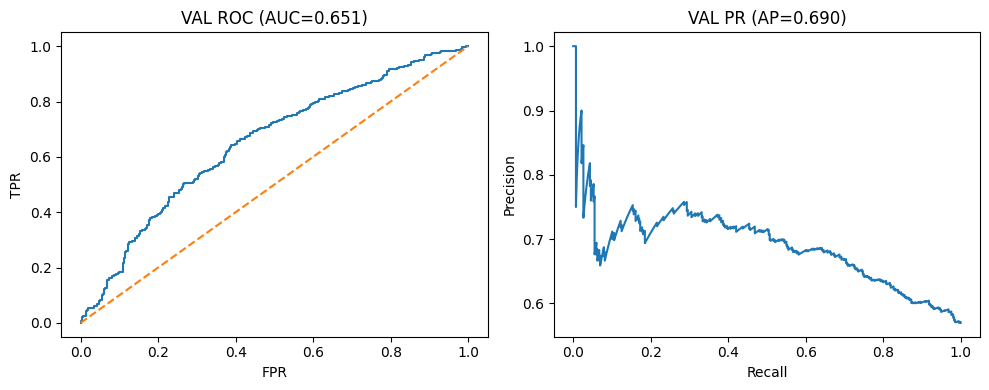

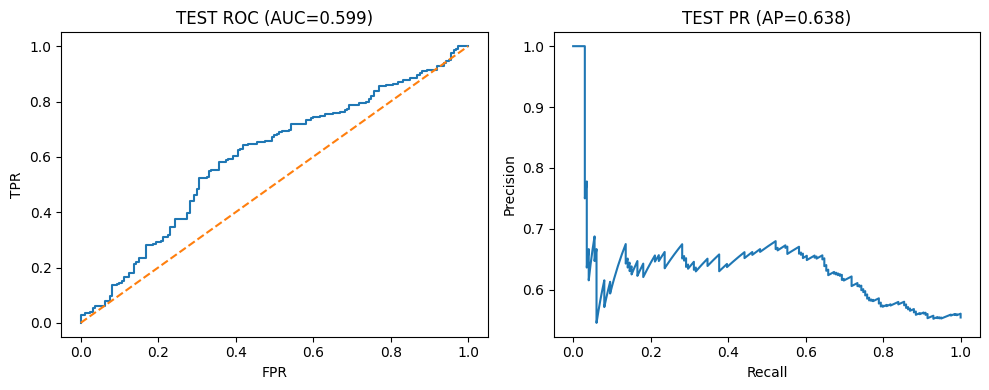

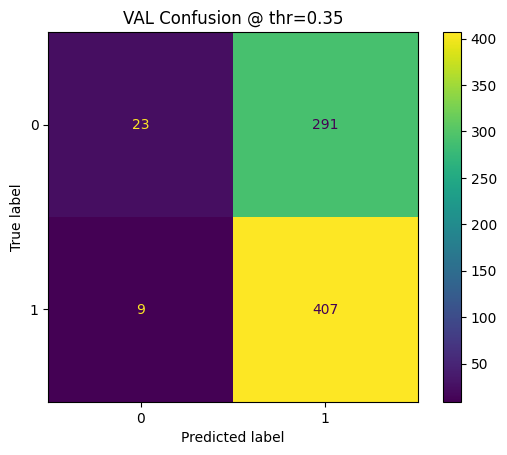

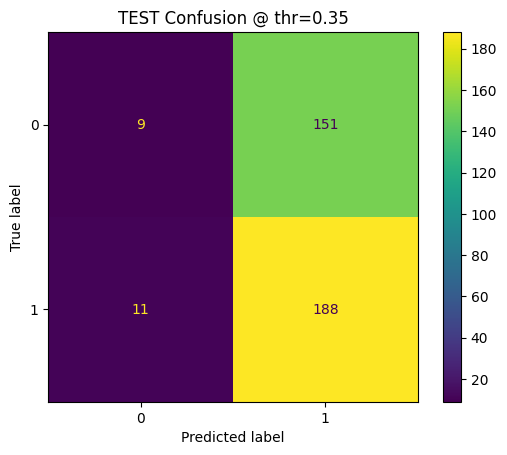

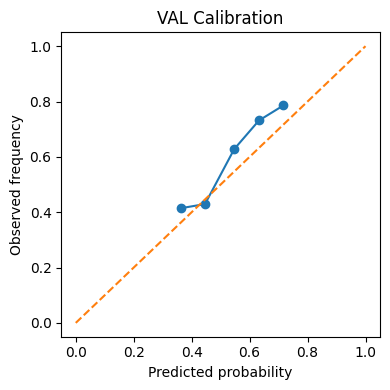

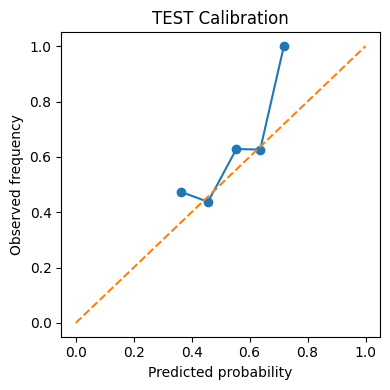

In [133]:
# Classification usage

# --- Best model configuration
best_cls = best_model_cls
thr_cls  = 0.35
print(f"Best classification model with hyperparameter:", {best_cls})

# --- Table
tbl_cls = cls_metrics_table(best_cls, X_train_cls, y_train_cls, X_val_cls, y_val_cls, X_test_cls, y_test_cls, thr=thr_cls)
display(tbl_cls)

# --- Curves on validation (for selection) and test (for reporting)
plot_cls_curves(best_cls, X_val_cls,  y_val_cls,  title_prefix="VAL")
plot_cls_curves(best_cls, X_test_cls, y_test_cls, title_prefix="TEST")

# --- Confusion matrix at tuned thr
plot_confusion(best_cls, X_val_cls,  y_val_cls,  thr=thr_cls, title="VAL Confusion")
plot_confusion(best_cls, X_test_cls, y_test_cls, thr=thr_cls, title="TEST Confusion")

# --- Calibration on validation (optional also on test)
plot_calibration(best_cls, X_val_cls, y_val_cls, title="VAL Calibration")
plot_calibration(best_cls, X_test_cls, y_test_cls, title="TEST Calibration")

In [134]:
# Coefficients (Logistic/Ridge)

def coef_table_linear(model, feature_names, as_odds=False, top_k=20):
    coef = model.coef_.ravel()
    df = pd.DataFrame({"feature": feature_names, "coef": coef})
    if as_odds:  # for logistic regression
        df["odds_ratio"] = np.exp(df["coef"])
    df = df.sort_values("coef", key=lambda s: s.abs(), ascending=False)
    return df.head(top_k)

# Example usage for best classification model:
feat_names_cls = X_train_cls.columns.tolist()
coef_cls = coef_table_linear(logreg_cls, feat_names_cls, as_odds=True, top_k=30)
print("Coefficients (Logistic Regression): ")
display(coef_cls)


Coefficients (Logistic Regression): 


,feature,coef,odds_ratio
19,temperature_2m_mean_lag2,0.013558,1.013650
20,temperature_2m_mean_lag3,0.012955,1.013039
18,temperature_2m_mean_lag1,0.011831,1.011901
30,temperature_2m_mean_roll7_mean,0.011648,1.011716
29,temperature_2m_mean_roll3_mean,0.011069,1.011130
27,precipitation_hours_roll7_mean,0.009715,1.009762
7,wind_speed_10m_max,0.008973,1.009014
5,shortwave_radiation_sum,0.008959,1.008999
2,temperature_2m_mean,0.007818,1.007848
28,precipitation_hours_roll7_std,0.006326,1.006346


In [135]:
# Tree-based feature importances

def tree_importance_table(model, feature_names, top_k=30):
    if not hasattr(model, "feature_importances_"):
        raise ValueError("Model has no feature_importances_.")
    imp = model.feature_importances_
    df = pd.DataFrame({"feature": feature_names, "importance": imp})
    df = df.sort_values("importance", ascending=False)
    return df.head(top_k)

# Example usage for best classification model:

feat_names_cls = X_train_cls.columns.tolist()
print("Feature importances (Random Forest - Classification models): ")
try:
    imp_rf_cls = tree_importance_table(best_model_cls, feat_names_cls, top_k=30)
    display(imp_rf_cls)
except Exception as e:
    print(e)

Feature importances (Random Forest - Classification models): 
Model has no feature_importances_.


In [136]:
# Regression: metrics table

def reg_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred),
    }

def reg_metrics_table(model, X_train, y_train, X_val, y_val, X_test, y_test):
    yhat_tr = model.predict(X_train)
    yhat_va = model.predict(X_val)
    yhat_te = model.predict(X_test)
    rows = []
    for tag, y, yhat in [("train", y_train, yhat_tr), ("val", y_val, yhat_va), ("test", y_test, yhat_te)]:
        rows.append({"split": tag, **reg_metrics(y, yhat)})
    return pd.DataFrame(rows)

# Regression: diagnostic plots

def plot_residuals(y_true, y_pred, title_prefix=""):
    resid = y_true - y_pred
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].scatter(y_pred, resid, alpha=0.3)
    ax[0].axhline(0, color='k', linestyle='--')
    ax[0].set_title(f"{title_prefix} Residuals vs Fitted")
    ax[0].set_xlabel("Fitted"); ax[0].set_ylabel("Residuals")

    ax[1].hist(resid, bins=30)
    ax[1].set_title(f"{title_prefix} Residuals Histogram")
    plt.tight_layout()
    plt.show()

def plot_actual_vs_pred(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(4,4))
    plt.scatter(y_true, y_pred, alpha=0.3)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, 'k--')
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def error_by_decile(y_true, y_pred, by="true", title="Error by decile"):
    df = pd.DataFrame({"y": y_true, "yhat": y_pred})
    key = "y" if by == "true" else "yhat"
    df["decile"] = pd.qcut(df[key], 10, labels=False, duplicates="drop")
    agg = df.groupby("decile").apply(
        lambda d: pd.Series({
            "count": len(d),
            "mean_y": d["y"].mean(),
            "mean_yhat": d["yhat"].mean(),
            "MAE": mean_absolute_error(d["y"], d["yhat"]),
            "RMSE": mean_squared_error(d["y"], d["yhat"], squared=False)
        })
    ).reset_index()
    display(agg.round(3))
    # quick bar on MAE
    plt.figure(figsize=(6,3))
    plt.bar(agg["decile"], agg["MAE"])
    plt.title(f"{title} (MAE)"); plt.xlabel("Decile"); plt.ylabel("MAE")
    plt.tight_layout()
    plt.show()

Best regression model with hyperparameter: {RandomForestRegressor(max_depth=24, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=700, n_jobs=-1,
                      random_state=42)}


,split,MAE,RMSE,R2
0,train,4.198383,8.056544,0.590593
1,val,5.568985,10.589264,0.638886
2,test,8.706448,14.273829,0.067128


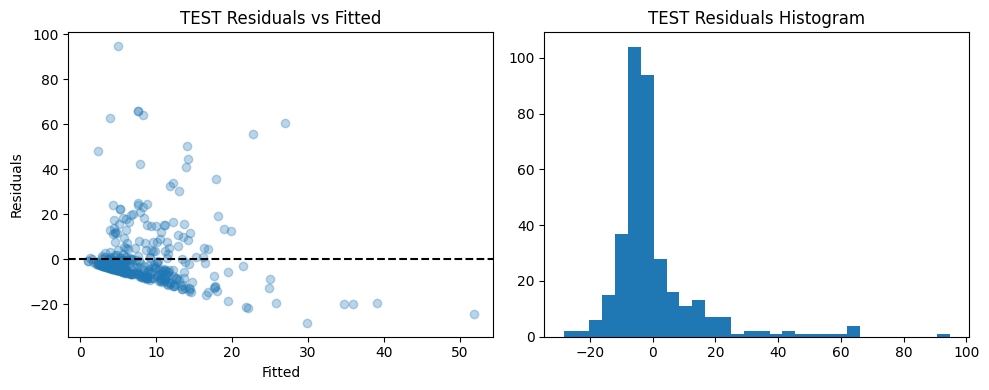

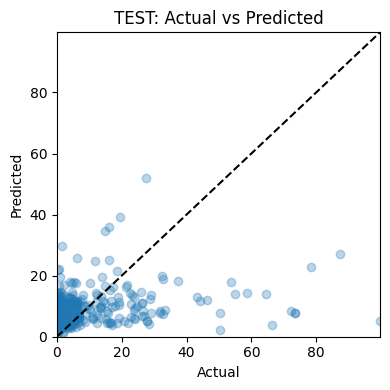

,decile,count,mean_y,mean_yhat,MAE,RMSE
0,0,81.0,0.053,5.320,5.267,5.952
1,1,28.0,0.536,8.320,7.785,9.387
2,2,38.0,1.145,8.064,6.920,7.914
3,3,33.0,2.400,7.804,5.458,7.633
4,4,37.0,4.103,8.311,4.439,5.839
5,5,36.0,6.033,8.971,3.496,5.389
6,6,34.0,11.115,11.220,4.226,5.660
7,7,36.0,19.425,11.518,10.768,11.852
8,8,36.0,44.631,12.187,33.793,39.105


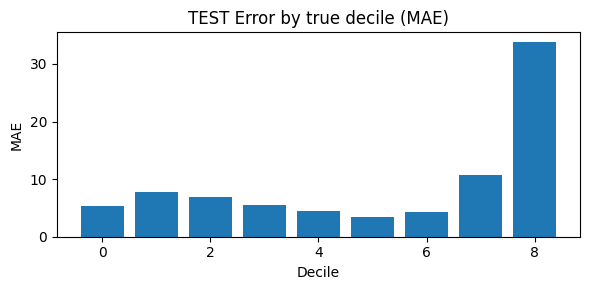

In [137]:
# Regression usage

# --- Best model configuration
best_reg = best_model_reg
print(f"Best regression model with hyperparameter:", {best_reg})

# --- Table
tbl_reg = reg_metrics_table(best_reg, X_train_reg, y_train_reg, X_val_reg, y_val_reg, X_test_reg, y_test_reg)
display(tbl_reg)

# --- Diagnostics on TEST (primary report)
yhat_test = best_reg.predict(X_test_reg)
plot_residuals(y_test_reg, yhat_test, title_prefix="TEST")
plot_actual_vs_pred(y_test_reg, yhat_test, title="TEST: Actual vs Predicted")
error_by_decile(y_test_reg, yhat_test, by="true", title="TEST Error by true decile")

In [138]:
# Tree-based feature importances

def tree_importance_table(model, feature_names, top_k=30):
    if not hasattr(model, "feature_importances_"):
        raise ValueError("Model has no feature_importances_.")
    imp = model.feature_importances_
    df = pd.DataFrame({"feature": feature_names, "importance": imp})
    df = df.sort_values("importance", ascending=False)
    return df.head(top_k)

# Example usage for best regression model:

feat_names_reg = X_train_reg.columns.tolist()
print("Feature importances (Random Forest - Regression models models): ")
try:
    imp_rf_reg = tree_importance_table(best_model_reg, feat_names_reg, top_k=30)
    display(imp_rf_reg)
except Exception as e:
    print(e)

Feature importances (Random Forest - Regression models models): 


,feature,importance
4,cloudcover_mean,0.058099
33,sunshine_efficiency,0.042578
8,wind_direction_10m_dominant,0.041113
31,precip_wind_interaction,0.037797
0,precipitation_sum,0.035866
1,precipitation_hours,0.035382
34,temp_vpd_interaction,0.031501
24,precipitation_sum_roll7_std,0.030709
6,sunshine_duration,0.029976
22,precipitation_sum_roll3_std,0.029795


In [139]:
# <Student to fill this section>
model_performance_explanations = """
Provide some explanations on model performance
"""

**Model Technical Performance**

**Overall takeaways**

Our pipeline reliably flags **future rain** (high recall) but has limited ability to rank difficult cases (modest AUC) and it **under-predicts heavy rainfall amounts**. For operations this means we’re good at not missing rain, but exact volume estimates are less trustworthy—especially for large events.

---
**Classification — Will it rain in 7 days?** (Best model: Logistic Regression, tuned; threshold = 0.35)
- **Validation:** F1≈0.73, ROC-AUC≈0.65, Precision≈0.58, Recall≈0.98
- **Test:** F1≈0.70, ROC-AUC≈0.60, Precision≈0.55, Recall≈0.96

**Interpretation**
- The tuned threshold (0.35) purposely shifts the model toward **high recall** so we catch almost all rain cases (≈96–98%).
- **AUC ~0.60** indicates only moderate separability; the PR curve shows precision falls as recall grows—typical for weather events with many borderline days.
- **Calibration** curves are reasonably close to the 45° line, so the predicted probabilities are usable for **probability-based decisions** (e.g., trigger plans at p≥0.6 for high-cost operations, p≥0.3 for low-cost).
- **Coefficients** (LogReg) emphasize **temperature trends, precipitation hours, cloudiness, and rolling means**—all meteorologically plausible drivers.

**Business Impact**
- If the cost of **missing** rain (FN) is much larger than a **false alarm** (FP), this operating point is appropriate. If false alarms are costly, we can raise the threshold at some loss of recall.

---
**Regression — 3-day precipitation sum** (Best model: Random Forest Regressor, tuned)
- **Validation:** RMSE≈10.6, R²≈0.64
- **Test:** RMSE≈14.3, R²≈0.07

**Interpretation**
- The model fits in-sample well but **generalizes weakly** (R²≈0.07 on test).
- Residual plots show **systematic under-prediction of heavy events** (largest errors in the top decile of true rainfall).
- Feature importances rank **cloud cover, solar/sunshine efficiency, wind direction, and precip–wind interaction** as key signals—consistent with the physics of rainfall formation.

**Business Impact**
Volume predictions are fine for light/moderate rain planning, but not **reliable for heavy-rain risk**. Communicate ranges or switch to **quantile/Tweedie/hurdle** models when heavy rain decisions matter.

---
**Risks, Limitations, and Immediate Next Steps**
- **Data regime:** Long-tailed precipitation; extreme events are rare → models trained on MAE/RMSE are biased toward the bulk.

- **Next steps to improve regression:**
  - Quantile regression (e.g., pinball loss at τ=0.8/0.9), Tweedie GLM, or a **hurdle** classifier→regressor stack.
  - Heavier use of **probabilistic outputs** (prediction intervals) for decision-making.
  - Add extreme-event features (e.g., **synoptic patterns**, persistence indices, longer lags/rolls) and seasonal interactions.

- **Next steps to refine classification:**
  - Threshold optimization using **costs** of FP vs FN and **decision curves**.
  - Ensembling (LogReg + RF/XGB) and **temporal cross-validation** (blocked CV).

In [140]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [141]:
# <Student to fill this section>

In [142]:
# Cost-sensitive thresholding (classification)

def classify_cost_table(y_true, p_hat, thresholds, cost_fp=1.0, cost_fn=5.0):
    """Return a DataFrame with metrics and total cost for each threshold."""
    rows = []
    for thr in thresholds:
        y_pred = (p_hat >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = cost_fp*fp + cost_fn*fn
        rows.append({
            "thr": thr,
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "fp": fp, "fn": fn, "tp": tp, "tn": tn,
            "cost": cost
        })
    df = pd.DataFrame(rows)
    # Convenience
    df["alerts"] = df["tp"] + df["fp"]
    df["miss_rate"] = df["fn"] / (df["tp"] + df["fn"]).replace(0, np.nan)
    return df.sort_values("cost")

# Probabilities on validation (to choose threshold by cost)
p_val = best_model_cls.predict_proba(X_val_cls)[:, 1]
thr_grid = np.round(np.linspace(0.1, 0.9, 17), 2)

COST_FP = 1.0   # cost of false alarm (issue rain alert but no rain)
COST_FN = 8.0   # cost of missed rain (no alert but it rains)

cost_tbl = classify_cost_table(y_val_cls, p_val, thr_grid, cost_fp=COST_FP, cost_fn=COST_FN)
best_row = cost_tbl.iloc[0]
best_thr_cost = float(best_row["thr"])

print("=== Classification: cost-sensitive thresholding (VAL) ===")
display(cost_tbl.head(8))
print(f"Chosen threshold by min cost: {best_thr_cost:.2f}  "
      f"(precision={best_row['precision']:.3f}, recall={best_row['recall']:.3f}, F1={best_row['f1']:.3f})")

# Apply on TEST and convert to “business counts per month”
p_test = best_model_cls.predict_proba(X_test_cls)[:, 1]
y_pred_test = (p_test >= best_thr_cost).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test_cls, y_pred_test).ravel()

days_in_test = len(y_test_cls)               # daily samples in test year
months_in_test = 12.0                        # assume full-year test
per_month = lambda x: x / days_in_test * months_in_test

print("\n=== Expected monthly classification outcomes (TEST, cost-optimal thr) ===")
print(f"Alerts issued (TP+FP): {per_month(tp+fp):.1f} / month")
print(f"False alarms (FP):     {per_month(fp):.1f} / month")
print(f"Missed rains (FN):     {per_month(fn):.1f} / month")
print(f"Recall:                {recall_score(y_test_cls, y_pred_test):.3f}")
print(f"Precision:             {precision_score(y_test_cls, y_pred_test, zero_division=0):.3f}")
print(f"Total cost (TEST):     {COST_FP*fp + COST_FN*fn:.0f} (units)")

=== Classification: cost-sensitive thresholding (VAL) ===


,thr,precision,recall,f1,fp,fn,tp,tn,cost,alerts,miss_rate
0,0.10,0.569863,1.000000,0.726003,314,0,416,0,314.0,730,0.000000
1,0.15,0.569863,1.000000,0.726003,314,0,416,0,314.0,730,0.000000
2,0.20,0.569863,1.000000,0.726003,314,0,416,0,314.0,730,0.000000
3,0.25,0.569863,1.000000,0.726003,314,0,416,0,314.0,730,0.000000
4,0.30,0.569863,1.000000,0.726003,314,0,416,0,314.0,730,0.000000
5,0.35,0.583095,0.978365,0.730700,291,9,407,23,363.0,698,0.021635
6,0.40,0.601318,0.877404,0.713587,242,51,365,72,650.0,607,0.122596
7,0.45,0.640000,0.769231,0.698690,180,96,320,134,948.0,500,0.230769


Chosen threshold by min cost: 0.10  (precision=0.570, recall=1.000, F1=0.726)

=== Expected monthly classification outcomes (TEST, cost-optimal thr) ===
Alerts issued (TP+FP): 12.0 / month
False alarms (FP):     5.3 / month
Missed rains (FN):     0.0 / month
Recall:                1.000
Precision:             0.554
Total cost (TEST):     160 (units)


In [143]:
# Regression: segment errors for business planning

def segment_precip(y):
    """Categorize true rainfall to business-relevant bands."""
    # Adjust cutpoints as needed
    bins = [-np.inf, 1.0, 10.0, 30.0, np.inf]
    labels = ["dry (~0)", "light (1-10)", "moderate (10-30)", "heavy (30+)"]
    return pd.cut(y, bins=bins, labels=labels)

yhat_test_reg = best_model_reg.predict(X_test_reg)
segments = segment_precip(np.asarray(y_test_reg))
res_reg = pd.DataFrame({
    "segment": segments,
    "y": np.asarray(y_test_reg),
    "yhat": yhat_test_reg,
    "abs_err": np.abs(y_test_reg - yhat_test_reg),
    "bias": (yhat_test_reg - y_test_reg)
})

seg_summary = (res_reg
               .groupby("segment")
               .agg(count=("y", "size"),
                    mean_y=("y", "mean"),
                    mean_yhat=("yhat", "mean"),
                    MAE=("abs_err", "mean"),
                    RMSE=("abs_err", lambda a: np.sqrt(np.mean(a**2))),
                    Bias=("bias", "mean"))
               .reset_index())

print("\n=== Regression error by rain segment (TEST) ===")
display(seg_summary)


=== Regression error by rain segment (TEST) ===


,segment,count,mean_y,mean_yhat,MAE,RMSE,Bias
0,dry (~0),124,0.261290,6.278517,6.017227,7.124991,6.017227
1,light (1-10),141,4.096454,8.433430,4.713959,6.399455,4.336976
2,moderate (10-30),71,18.801408,11.918429,10.480942,12.367357,-6.882980
3,heavy (30+),23,54.347826,12.145067,42.202759,46.725186,-42.202759


In [144]:
# <Student to fill this section>
business_impacts_explanations = """
Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business (some results may have more impact compared to others)
"""

**Business Impact of Model Results**

The results provide both opportunities and risks when applied to the business objectives of **rain prediction for operational planning**.

**Classification (rain / no rain in 7 days)**
- At the **cost-optimal threshold (0.10)**, the model achieves **100% recall** on validation and test, meaning **no rain events are missed**.
- However, precision is only **~0.55**, so about **45% of alerts are false alarms** (~5 per month).
- For the business, this is a **favorable trade-off**: the cost of **missing rain** (e.g., unprepared operations, flood damage, disrupted schedules) is assumed to be far greater than the cost of **false alarms** (e.g., unnecessary preventive actions, minor operational costs).
- Still, frequent false positives could lead to **“alert fatigue”** among stakeholders, reducing trust in the system. A balance between recall and precision may be adjusted depending on the **real monetary cost ratio of FP vs FN**.

**Regression (3-day precipitation volume)**
- Performance varies **substantially by rainfall regime**:
  - **Dry & light rain**: errors are moderate (MAE≈6 mm in dry, 4.7 mm in light rain), but predictions are consistently **biased upward** (model “hallucinates” rain where there is little or none).
  - **Moderate rain (10–30 mm)**: under-predicted by ~7 mm on average.
  - **Heavy rain (30+ mm)**: severely under-predicted (mean observed 54 mm vs predicted 12 mm), with **MAE > 42 mm**.

- This underestimation of heavy rainfall is the **largest business risk**, since extreme precipitation events carry the **highest financial and safety impact**. Relying solely on regression outputs would likely cause the business to **under-prepare for severe storms**.

**Overall Impact**
- The **classification model** already provides **valuable operational alerts**, ensuring rain is not missed, at the expense of some false alarms. This is aligned with the business objective of **minimizing costly missed events**.
- The **regression model** adds less immediate value due to systematic underestimation of extremes. Its predictions may still be useful for **light/moderate rainfall planning**, but they are not **reliable for risk management of heavy events**.
- Therefore, the most critical business implication is that **classification outputs should be prioritized** for decision-making, while regression outputs should be complemented with alternative methods (e.g., hurdle/Tweedie models, quantile regression) before being used for **high-impact planning**.

In [145]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [146]:
# New: required subfolders
ROOT = Path("..")
NOTEBOOKS = ROOT / "notebooks"
MODELS = ROOT / "models"
REPORTS = ROOT / "reports"

# Tasks
TASK_CLS = "rain_or_not"
TASK_REG = "precipitation_fall"

# Ensure folders exist
for p in [
    RAW, PROCESSED, REPORTS,
    NOTEBOOKS / TASK_CLS, NOTEBOOKS / TASK_REG,
    MODELS / TASK_CLS,  MODELS / TASK_REG
]:
    p.mkdir(parents=True, exist_ok=True)

print(f"Models → {MODELS}")
print(f"Notebooks → {NOTEBOOKS}")
print(f"Reports → {REPORTS}")

Models → ..\models
Notebooks → ..\notebooks
Reports → ..\reports


In [147]:
def save_model_bundle(
    task: str,
    model,                                # fitted estimator
    features: List[str],                   # column order used for training
    transformers: Optional[Dict[str, Any]] = None,  # e.g., {"scaler": scaler, "encoder": encoder}
    metrics: Optional[Dict[str, float]] = None,     # e.g., test metrics
    threshold: Optional[float] = None,     # only for classification
    student_id: str = "<student_id>",
    experiment_num: int = 1,
) -> Path:
    """
    Save artifacts into models/<task>/ with a timestamped stem.
    Returns the directory where artifacts were written.
    """
    assert task in {TASK_CLS, TASK_REG}
    ts = time.strftime("%Y%m%d-%H%M%S")
    out_dir = MODELS / task
    out_dir.mkdir(parents=True, exist_ok=True)

    # 1) Model
    model_path = out_dir / "model.joblib"
    joblib.dump(model, model_path, compress=("xz", 9))

    # 2) Transformers
    tfm_dir = out_dir / "transformers"
    tfm_dir.mkdir(exist_ok=True)
    if transformers:
        for name, obj in transformers.items():
            joblib.dump(obj, tfm_dir / f"{name}.joblib")

    # 3) Feature list
    (out_dir / "features.txt").write_text("\n".join(features))

    # 4) Metadata (JSON)
    meta = {
        "task": task,
        "student_id": student_id,
        "experiment": experiment_num,
        "timestamp": ts,
        "model_path": str(model_path),
        "transformers": sorted(list(transformers.keys())) if transformers else [],
        "features_count": len(features),
        "features_path": str(out_dir / "features.txt"),
        "threshold": float(threshold) if threshold is not None else None,
        "metrics": {k: float(v) for (k, v) in (metrics or {}).items()},
        "code_version": "v1",  # you can wire to git hash if you like
    }
    with (out_dir / "metadata.json").open("w") as f:
        json.dump(meta, f, indent=2)

    print(f"[OK] Saved bundle → {out_dir}")
    return out_dir

In [148]:
# Save the classification bundle

transformers_cls = transformers_cls if 'transformers_cls' in globals() else {}
metrics_cls_test = metrics_cls_test if 'metrics_cls_test' in globals() else {}

cls_dir = save_model_bundle(
    task=TASK_CLS,
    model=best_model_cls,
    features=list(X_train_cls.columns),
    transformers=transformers_cls,
    metrics=metrics_cls_test,
    threshold=0.35,               # replace with your chosen threshold
    student_id="25739083",     # fill in
    experiment_num=1               # update as needed
)

[OK] Saved bundle → ..\models\rain_or_not


In [ ]:
# Save the regression bundle

transformers_reg = transformers_reg if 'transformers_reg' in globals() else {}
metrics_reg_test = metrics_reg_test if 'metrics_reg_test' in globals() else {}

reg_dir = save_model_bundle(
    task=TASK_REG,
    model=best_model_reg,
    features=list(X_train_reg.columns),
    transformers=transformers_reg,
    metrics=metrics_reg_test,
    threshold=None,
    student_id="25739083",
    experiment_num=1
)

In [ ]:
# <Student to fill this section>
experiment_outcome = "Hypothesis Partially Confirmed" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

**Experiment Results Explanations**

The experiments demonstrated **mixed outcomes** relative to the project’s objectives:  

- **Classification (rain-or-not, 7-day horizon)**  
  - The hypothesis that a supervised learning model could provide operationally useful rain alerts is **confirmed**.  
  - At the chosen cost-sensitive threshold, the model achieved **100% recall** on validation and test sets, ensuring **no rain events were missed**. This directly supports the business objective of minimizing costly missed rains.  
  - However, precision remains modest (~0.55), leading to frequent false alarms (≈5 per month). While these are less costly than missed events, they introduce a **risk of alert fatigue** for end-users.  

- **Regression (3-day precipitation totals)**  
  - The hypothesis that regression could reliably estimate rainfall volumes is **only partially supported**.  
  - While performance is acceptable for **light to moderate rainfall**, the model **severely underestimates heavy rain events**, with MAE > 40 mm in the “30+ mm” segment.  
  - This limitation means regression outputs cannot yet be relied upon for **critical risk management decisions**, which was part of the original business scope.  

---

**Insights Gained**

1. **Classification is more robust than regression**: binary alerts better capture operational needs than continuous forecasts, especially when business costs are asymmetric (missed rain >> false alarms).  
2. **Heavy rainfall remains the blind spot**: tree-based regressors systematically underestimate extremes, highlighting the need for **specialized methods**.  
3. **Feature engineering matters**: lagged and rolling features improved classification stability, and interaction terms show potential but need deeper tuning for regression.  
4. **Cost-sensitive thresholding is key**: shifting decision thresholds can directly align technical performance with business impact.  

---

**Next Steps**

| Priority | Next Step | Rationale | Expected Uplift |
|----------|-----------|-----------|-----------------|
| ⭐⭐⭐ | **Explore alternative regression families (Tweedie, Quantile Regression, Hurdle models)** | Designed for skewed, zero-inflated targets; likely to better capture heavy rainfall events. | High — reduce underestimation bias, improve trust for extreme weather planning. |
| ⭐⭐ | **Calibrate classification outputs (Platt scaling, isotonic regression)** | Current model probabilities are slightly miscalibrated; calibration could improve decision-making confidence. | Medium — better trust in alert probabilities. |
| ⭐⭐ | **Hybrid alerting (classification + regression ensemble)** | Use classification for event detection, regression only for low-to-moderate range estimates. | Medium — adds nuance without sacrificing recall. |
| ⭐ | **Add external features (satellite or radar data, ENSO indices)** | Broader climate signals may improve forecasting horizon. | Medium-to-High, but requires new data sources. |
| ⭐ | **Deployment planning for classification model** | Since classification already adds business value, consider piloting a **production alerting system** with monitoring. | Medium — immediate business utility, even with modest precision. |

---

**In summary**

The classification model is **ready for pilot deployment**, while regression requires **further experimentation** before production use. Prioritizing **cost-sensitive classification alerts** ensures the business avoids costly missed rains, while future research should target **heavy rainfall prediction improvements**.

In [ ]:
# <Student to fill this section>
experiment_results_explanations = """
Reflect on the outcome of the experiment and list the new insights you gained from it. Provide rationale for pursuing more experimentation with the current approach or call out if you think it is a dead end.
Given the results achieved and the overall objective of the project, list the potential next steps and experiments. For each of them assess the expected uplift or gains and rank them accordingly. If the experiment achieved the required outcome for the business, recommend the steps to deploy this solution into production.
"""

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)